# Code for Section 8.6.1 Classification of the Used Processivity factors

##extracting Foldseek Alignment Results

To gain further insights into the family background of each factor, structural similarities to other proteins were investigated using Foldseek (https://search.foldseek.com/search). The results from the Foldseek web server search were downloaded as a JSON file and further processed with this notebook. Initially, the descriptions column from the obtained results was analyzed for word combinations using the feature extraction tool from the scikit-learn library.


In [4]:
import pandas as pd
import json

# Load the JSON file
with open('/content/Foldseek_2025_02_15_20_46_42.json', 'r') as file:
    data = json.load(file)

# Convert JSON to DataFrame
df_alignment = pd.json_normalize(data)



df_expanded = df_alignment['results'].explode().apply(pd.Series)
json_data = df_expanded['alignments'].iloc[0]  # Access first row

# Check structure before proceeding
#print(json.dumps(json_data, indent=4))

# Initialize an empty list to store all alignment data
all_alignment_data = []

# Iterate over the keys in the json_data (e.g., "998", "999", etc.)
for key in json_data:
    alignment_data = json_data.get(key, [])
    all_alignment_data.extend(alignment_data)  # Add alignments from each key

# Convert to DataFrame
df_alignment = pd.DataFrame(all_alignment_data)

# Display DataFrame


df_alignment['href'] = df_alignment['href'].apply(lambda x: x[0] if isinstance(x, list) and x else x)

# Extract fields safely
df_alignment[['DataBase', 'accession', 'href']] = df_alignment['href'].apply(lambda x: pd.Series(x) if isinstance(x, dict) else pd.Series([None, None, None]))

# Display the updated DataFrame
print(df_alignment)



    query        target  seqId  alnLength  missmatches  gapsopened  qStartPos  \
0     job    A0A6J5SZN5   26.9         63           45           1         11   
1     job    A0A6J5M7K2   25.4         59           43           1         10   
2     job    A0A6J5RQV5   22.7         79           46           2          1   
3     job    A0A6J5QA65   20.8         72           55           2          3   
4     job    A0A6J5LPW1   29.8         67           45           2          1   
..    ...           ...    ...        ...          ...         ...        ...   
995   job        D5L2B5   10.9         64           44           4         18   
996   job    A0A2S0SZ95   20.0         35           28           0         25   
997   job    A0A5K0U9V4   17.0         88           55           4          1   
998   job  A0A516MA22_2   19.4         72           42           3         16   
999   job    A0A6J5RIP7   13.9         43           34           1         30   

     qEndPos  dbStartPos  d

In [5]:
import pandas as pd
import json

# Load the JSON file
with open('/content/Foldseek_2025_02_15_20_46_42.json', 'r') as file:
    data = json.load(file)

# Convert JSON to DataFrame
df = pd.json_normalize(data)

# Display the first few rows of the DataFrame
print(df.columns)


Index(['queries', 'mode', 'results', 'query.pdb', 'query.qCa'], dtype='object')


In [6]:
#df["results"][0]

##Merching Foldseek Alignment Results with Uniprot Data
The results were then filtered for the afdb-swissprot database, and the corresponding UniProt entries were downloaded via the UniProt API. These entries were merged with the Foldseek results using the common UniProt identifier.

####extracting the data from the Foldseek hits

In [7]:
import json
import pandas as pd

# Load JSON file
with open("/content/Foldseek_2025_02_15_20_46_42.json", "r") as file:
    data = json.load(file)

# Extract relevant information
rows = []
for result in data[0]["results"]:
    db_name = result["db"]
    for key, alignments in result["alignments"].items():
        for aln in alignments:
            rows.append({
                "Database": db_name,
                "Query": aln["query"],
                "Target": aln["target"],
                "Sequence Identity (%)": aln["seqId"],
                "Alignment Length": aln["alnLength"],
                "Mismatches": aln["missmatches"],
                "Gaps Opened": aln["gapsopened"],
                "Query Start": aln["qStartPos"],
                "Query End": aln["qEndPos"],
                "DB Start": aln["dbStartPos"],
                "DB End": aln["dbEndPos"],
                "Probability": aln["prob"],
                "E-value": aln["eval"],
                "Score": aln["score"],
                "Query Length": aln["qLen"],
                "Database Length": aln["dbLen"],
                "Description":aln["description"],
                #"taxId":aln["taxId"],
                #"taxName":aln["taxName"]

            })

# Convert to Pandas DataFrame
df = pd.DataFrame(rows)

# Display the DataFrame
print(df)

# Save as CSV if needed
df.to_csv("output.csv", index=False)

     Database Query              Target  Sequence Identity (%)  \
0        BFVD   job          A0A6J5SZN5                   26.9   
1        BFVD   job          A0A6J5M7K2                   25.4   
2        BFVD   job          A0A6J5RQV5                   22.7   
3        BFVD   job          A0A6J5QA65                   20.8   
4        BFVD   job          A0A6J5LPW1                   29.8   
...       ...   ...                 ...                    ...   
4240   pdb100   job   7oyc-assembly1_K2                   15.7   
4241   pdb100   job  2qz8-assembly1_B-2                   14.2   
4242   pdb100   job    5o6i-assembly1_A                    6.4   
4243   pdb100   job  6nqt-assembly3_E-2                    8.3   
4244   pdb100   job    5fr0-assembly1_A                   11.4   

      Alignment Length  Mismatches  Gaps Opened  Query Start  Query End  \
0                   63          45            1           11         73   
1                   59          43            1          

In [8]:
#df

In [9]:
#df["Description"].value_counts()

In [10]:
#values_count.index.tolist()

###analysing the Description of the Foldseek hits

In [11]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import CountVectorizer

# Convert descriptions to lowercase and remove NaNs
descriptions = df['Description'].dropna().str.lower()

# Get top 10 most common descriptions
values_count = df["Description"].value_counts().rename_axis("Description").reset_index(name="Count")
values_count.iloc[0, 0] = "Unnamed"
values_count=values_count[:10]# Rename the first index

# Function to extract n-grams
def extract_ngrams(n, top_n=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    X = vectorizer.fit_transform(descriptions)

    # Get the most common n-grams
    sum_words = X.toarray().sum(axis=0)
    words_freq = [(word, sum_words[idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    return words_freq

# Extract n-grams
bigrams = extract_ngrams(2)
trigrams = extract_ngrams(3)
fourgrams = extract_ngrams(4)

# Extract words and counts for each category
bigram_words, bigram_counts = zip(*bigrams) if bigrams else ([], [])
trigram_words, trigram_counts = zip(*trigrams) if trigrams else ([], [])
fourgram_words, fourgram_counts = zip(*fourgrams) if fourgrams else ([], [])

# Create subplots (1 row, 4 columns)
fig = make_subplots(rows=2, cols=2, subplot_titles=["Description Value Counts", "Bigrams", "Trigrams", "Fourgrams"])

# Add bars
fig.add_trace(go.Bar(x=values_count["Description"], y=values_count["Count"], name="Value_counts"), row=1, col=1)
fig.add_trace(go.Bar(x=bigram_words, y=bigram_counts, name="Bigrams"), row=1, col=2)
fig.add_trace(go.Bar(x=trigram_words, y=trigram_counts, name="Trigrams"), row=2, col=1)
fig.add_trace(go.Bar(x=fourgram_words, y=fourgram_counts, name="Fourgrams"), row=2, col=2)

# Update layout
fig.update_layout(
    #title="Most Common N-grams in Descriptions",
    showlegend=False,
    height=3000,
    width=2000,
    template="plotly_white"
)

# Rotate x-axis labels, increase font size, and change font family
fig.update_xaxes(
    tickangle=-45,
    tickfont=dict(
        size=32,  # Adjust font size
        family="Tahoma",  # Change font family
        color="black"  # Optional: Adjust font color
    )
)

fig.update_yaxes(

    tickfont=dict(
        size=32,  # Adjust font size
        family="Tahoma",  # Change font family
        color="black"  # Optional: Adjust font color
    )
)

# Increase font size of subplot titles
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=40, family="Tahoma", color="black")



# Show plot
fig.show()


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Sample DataFrame (Replace with your actual dataset)


# Convert descriptions to lowercase and remove NaNs
descriptions = df['Description'].dropna().str.lower()

# Function to extract n-grams
def extract_ngrams(n):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    X = vectorizer.fit_transform(descriptions)

    # Get the most common n-grams
    sum_words = X.toarray().sum(axis=0)
    words_freq = [(word, sum_words[idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq

# Extract and print separately
bigrams = extract_ngrams(2)
trigrams = extract_ngrams(3)
fourgrams = extract_ngrams(4)

print("Most common bigrams:", bigrams[:10])
print("Most common trigrams:", trigrams[:10])
print("Most common fourgrams:", fourgrams[:10])



Most common bigrams: [('transcriptional regulator', np.int64(592)), ('alpa family', np.int64(354)), ('family transcriptional', np.int64(284)), ('regulatory protein', np.int64(218)), ('uncharacterized protein', np.int64(204)), ('merr family', np.int64(170)), ('family phage', np.int64(152)), ('phage regulatory', np.int64(152)), ('crystal structure', np.int64(113)), ('domain containing', np.int64(110))]
Most common trigrams: [('family transcriptional regulator', np.int64(284)), ('alpa family transcriptional', np.int64(163)), ('alpa family phage', np.int64(152)), ('family phage regulatory', np.int64(152)), ('phage regulatory protein', np.int64(152)), ('merr family transcriptional', np.int64(116)), ('domain containing protein', np.int64(109)), ('transcriptional regulator alpa', np.int64(76)), ('hth type transcriptional', np.int64(70)), ('type transcriptional regulator', np.int64(62))]
Most common fourgrams: [('alpa family transcriptional regulator', np.int64(163)), ('alpa family phage regul

###filter the results for Uniprot Database

In [13]:
df1=df[df["Database"]=="afdb-swissprot"]
print(len(df1))
df1["Uniprot"] = df1["Target"].str.split("-").str[1]

251


<ipython-input-13-e70bb1ad7f6e>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



###exporting the Uniprot Identifiers of the corresponding entries

In [14]:
li=df1["Uniprot"].values.tolist()

In [15]:
with open("uniprot_list.txt", "w") as f:
    f.write("\t".join(df1["Uniprot"].astype(str).tolist()))

###Downloading Uniprot/Swissprot entries

The data were filtered for the afdb-swissprot database, and corresponding UniProt entries were retrieved via the UniProt API and merged with Foldseek results using the UniProt identifiers.
The hits were filtered for the afdb-swissprot database, to include values with manually curated annotation

In [16]:
pip install requests

In [17]:
import requests
import json

def get_uniprot_entries_json(uniprot_ids):
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    query = " OR ".join([f"accession:{uid}" for uid in uniprot_ids])
    params = {
        "query": query,
        "format": "json",
        "size": 251  # Increase the number of results per request (max = 500)
    }

    all_results = []
    next_cursor = None  # Cursor for pagination

    while True:
        if next_cursor:
            params["cursor"] = next_cursor  # Add cursor if paginating

        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            data = response.json()
            all_results.extend(data.get("results", []))  # Collect results

            # Check if there's a next page
            next_cursor = data.get("nextCursor")
            if not next_cursor:
                break  # No more pages, exit loop
        else:
            print(f"Error: Status code {response.status_code}")
            break

    return {"results": all_results}

# Example usage
uniprot_ids = li  # List of UniProt IDs
entries_data = get_uniprot_entries_json(uniprot_ids)

# Save to a JSON file
with open("uniprot_entries.json", "w") as f:
    json.dump(entries_data, f, indent=4)

print(f"Retrieved {len(entries_data['results'])} UniProt entries.")


Retrieved 251 UniProt entries.


In [18]:
import json
import pandas as pd

# Load JSON file
with open("/content/uniprot_entries.json", "r") as file:
    data = json.load(file)

# Normalize the JSON structure
df = pd.json_normalize(data["results"],
                       meta=["primaryAccession", "uniProtkbId"],
                       record_prefix="entry_",
                       sep="_")

# Display the first few rows
print(df.head())


                         entryType primaryAccession  \
0  UniProtKB reviewed (Swiss-Prot)           O95365   
1  UniProtKB reviewed (Swiss-Prot)           Q9NUJ1   
2  UniProtKB reviewed (Swiss-Prot)           Q99L45   
3  UniProtKB reviewed (Swiss-Prot)           P0A9G4   
4  UniProtKB reviewed (Swiss-Prot)           Q45666   

                secondaryAccessions  uniProtkbId  annotationScore  \
0  [D6W619, O00456, Q14D41, Q5XG86]  ZBT7A_HUMAN              5.0   
1  [B7Z6A8, C9IZX5, D3DN63, Q8TCF9]  ABHDA_HUMAN              5.0   
2                  [Q9CSH6, Q9CT12]   IF2B_MOUSE              5.0   
3                  [P77565, Q2MBU0]   CUER_ECOLI              5.0   
4                               NaN   TNRA_BACSU              5.0   

               proteinExistence  \
0  1: Evidence at protein level   
1  1: Evidence at protein level   
2  1: Evidence at protein level   
3  1: Evidence at protein level   
4  1: Evidence at protein level   

                                           

In [19]:
li_dict = df.set_index("primaryAccession")["features"].to_dict()


In [20]:
import ast

# Convert string to actual dictionary (if needed)
if isinstance(li_dict, str):
    li_dict = ast.literal_eval(li_dict)

# Recursive function to extract keys at all levels
def extract_keys(obj, parent_key="root", keys_dict=None):
    if keys_dict is None:
        keys_dict = {}

    if isinstance(obj, dict):
        for key, value in obj.items():
            full_key = f"{parent_key} -> {key}"
            keys_dict.setdefault(full_key, set()).add(type(value).__name__)  # Store data types for context
            extract_keys(value, full_key, keys_dict)

    elif isinstance(obj, list):
        for i, item in enumerate(obj):  # Keep track of list indexes
            list_key = f"{parent_key} -> list[{i}]"
            extract_keys(item, list_key, keys_dict)

    return keys_dict

# Extract all keys from the nested structure
all_keys = {}

for features in li_dict.values():
    for feature in features:
        extract_keys(feature, "feature", all_keys)

# Print all discovered keys and their levels
for key, value in sorted(all_keys.items()):
    print(f"{key}: {value}")


feature -> alternativeSequence: {'dict'}
feature -> alternativeSequence -> alternativeSequences: {'list'}
feature -> alternativeSequence -> originalSequence: {'str'}
feature -> description: {'str'}
feature -> evidences: {'list'}
feature -> evidences -> list[0] -> evidenceCode: {'str'}
feature -> evidences -> list[0] -> id: {'str'}
feature -> evidences -> list[0] -> source: {'str'}
feature -> evidences -> list[1] -> evidenceCode: {'str'}
feature -> evidences -> list[1] -> id: {'str'}
feature -> evidences -> list[1] -> source: {'str'}
feature -> evidences -> list[2] -> evidenceCode: {'str'}
feature -> evidences -> list[2] -> id: {'str'}
feature -> evidences -> list[2] -> source: {'str'}
feature -> evidences -> list[3] -> evidenceCode: {'str'}
feature -> evidences -> list[3] -> id: {'str'}
feature -> evidences -> list[3] -> source: {'str'}
feature -> featureCrossReferences: {'list'}
feature -> featureCrossReferences -> list[0] -> database: {'str'}
feature -> featureCrossReferences -> list

###Merching Foldseek Hits with Uniprot Data

In [21]:
import pandas as pd

# Assuming df1 is the DataFrame with RMSD scores
# And assuming df2 is the new DataFrame with columns like 'entryType', 'primaryAccession', etc.

# Load your second DataFrame (the one with 'primaryAccession' column)
df2 =df   # Adjust path as needed

# Merge df1 and df2 based on Uniprot from df1 and primaryAccession from df2
merged_df = pd.merge(df1, df2, left_on="Uniprot", right_on="primaryAccession", how="left")

# Save the merged DataFrame
merged_df.to_csv("/content/merged_df_Foldseek_uniprot.csv", index=False)

print(f"Merged DataFrame saved as '/content/drive/MyDrive/merged_df_with_rmsd.csv'")


Merged DataFrame saved as '/content/drive/MyDrive/merged_df_with_rmsd.csv'


In [22]:
import pandas as pd
import json
import ast

def extract_feature_data(feature_str):
    try:
        # Ensure feature_str is a valid Python object (list of dictionaries)
        if isinstance(feature_str, str):
            feature_list = ast.literal_eval(feature_str)  # Safer than `json.loads()`
        elif isinstance(feature_str, list):
            feature_list = feature_str  # Already a list
        else:
            return []  # Return empty list if invalid

        # Extract relevant fields
        extracted_data = [
            {
                'Feature_Type': feature.get('type'),
                'Feature_start_value': feature.get('location', {}).get('start', {}).get('value'),
                'Feature_start_modifier': feature.get('location', {}).get('start', {}).get('modifier'),
                'Feature_end_value': feature.get('location', {}).get('end', {}).get('value'),
                'Feature_end_modifier': feature.get('location', {}).get('end', {}).get('modifier'),
                'Feature_description': feature.get('description'),
                'featureId': feature.get('featureId')
            }
            for feature in feature_list
        ]

        return extracted_data if extracted_data else []
    except (ValueError, SyntaxError) as e:
        print(f"Parsing error: {e}")
        return []

# Apply extraction function to the 'features' column
merged_df['extracted_features'] = merged_df['features'].apply(extract_feature_data)

# Explode list of features into separate rows
df_exploded = merged_df.explode('extracted_features', ignore_index=True)

# Normalize the extracted data into separate columns
df_extracted = pd.json_normalize(df_exploded['extracted_features']).add_prefix("feature_")

# Merge extracted data back with original DataFrame
df_final = pd.concat([df_exploded.drop(columns='extracted_features'), df_extracted], axis=1)

# Display the final DataFrame
print(df_final)


            Database Query                 Target  Sequence Identity (%)  \
0     afdb-swissprot   job  AF-P15482-F1-model_v4                   10.9   
1     afdb-swissprot   job  AF-Q2EES9-F1-model_v4                   19.6   
2     afdb-swissprot   job  AF-Q2EES9-F1-model_v4                   19.6   
3     afdb-swissprot   job  AF-Q2EES9-F1-model_v4                   19.6   
4     afdb-swissprot   job  AF-Q2EES9-F1-model_v4                   19.6   
...              ...   ...                    ...                    ...   
1206  afdb-swissprot   job  AF-P0AD21-F1-model_v4                    9.8   
1207  afdb-swissprot   job  AF-P0AD21-F1-model_v4                    9.8   
1208  afdb-swissprot   job  AF-P0AD21-F1-model_v4                    9.8   
1209  afdb-swissprot   job  AF-P0AD21-F1-model_v4                    9.8   
1210  afdb-swissprot   job  AF-Q3JES6-F1-model_v4                   14.0   

      Alignment Length  Mismatches  Gaps Opened  Query Start  Query End  \
0           

In [23]:
df_final.to_csv("/content/final_df.csv")

##keyword Analysis

In the next step, the Keyword and Feature columns for the Foldseek hits were analyzed. The data were filtered for keyword categories that could provide information about the proteins, protein domains, or biological processes related to DNA in which the proteins might be involved. Each category was subsequently analyzed for keyword names related to DNA binding or processes associated with DNA binding, such as "Transcription".

In [24]:
import pandas as pd
df_final=pd.read_csv("/content/final_df.csv")

In [25]:
#df_final["keywords"].values.tolist()

In [26]:
import pandas as pd
import json
import ast

# Function to clean and extract the JSON data from the 'keywords' column
def extract_keywords_data(keyword_str):
    try:
        if isinstance(keyword_str, str):  # Check if it's a string
            keyword_list = ast.literal_eval(keyword_str)  # Safely convert string to list
        elif isinstance(keyword_str, list):  # Already a list
            keyword_list = keyword_str
        else:
            return []  # Return empty list if invalid

        # Extract the necessary fields
        extracted_data = [
            {
                'id': keyword.get('id'),
                'category': keyword.get('category'),
                'name': keyword.get('name')
            }
            for keyword in keyword_list
        ]

        return extracted_data if extracted_data else []
    except (ValueError, SyntaxError) as e:
        print(f"Parsing error: {e}")
        return []

# Apply extraction function to the 'keywords' column
df_final['extracted_keywords'] = df_final['keywords'].apply(extract_keywords_data)

# Explode the list of keywords into separate rows
df_exploded_keywords = df_final.explode('extracted_keywords', ignore_index=True)

# Drop NaN values before normalization
df_exploded_keywords = df_exploded_keywords.dropna(subset=['extracted_keywords'])

# Normalize the extracted keywords into separate columns
df_extracted_keywords = pd.json_normalize(df_exploded_keywords['extracted_keywords']).add_prefix("keyword_")

# Merge the original DataFrame with the exploded and normalized columns
df_final1 = pd.concat([df_exploded_keywords.drop(columns='extracted_keywords'), df_extracted_keywords], axis=1)

# Display the final DataFrame
#print(df_final1)



In [27]:
entries=df_final["Uniprot"].unique()

In [28]:
df_final["Uniprot"].value_counts()

Uniprot
O95365    98
P15928    30
P39075    28
Q5R4T9    23
P0A4T9    22
          ..
P60219     1
P50728     1
A1AW54     1
Q8KBW7     1
Q3JES6     1
Name: count, Length: 251, dtype: int64

The corresponding UniProt entries were obtained through the UniProt API. Further analysis focused on Foldseek hits containing "keyword" and "feature" annotations, targeting categories related to DNA binding or DNA-associated processes, such as "Transcription"

The 'Feature Type' column was then filtered for features indicating DNA-binding domains or regions, including keywords such as 'Chain,' 'Domain,' ‘Region’ in combination with the annotation 'DNA binding'.

The 'Feature Type' column was then filtered for features indicating DNA-binding domains or regions, including keywords such as 'Chain,' 'Domain,' ‘Region’ in combination with the annotation 'DNA binding'. The remaining hits were analyzed based on their “Feature Description” to determine their family classifications

In [29]:
x=df_final1[df_final1["keyword_category"]=="Biological process"]["keyword_name"].value_counts()
y=df_final1[df_final1["keyword_category"]=="Molecular function"]["keyword_name"].value_counts()
index_list = x.index[:10].delete(2).tolist()
imdex_2=y.index[:6].delete(4)


In [30]:
index_list

['Transcription regulation',
 'Transcription',
 'Differentiation',
 'Mercuric resistance',
 'Cell cycle',
 'Carotenoid biosynthesis',
 'DNA damage',
 'DNA repair',
 'Stress response']

In [31]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# First: Count occurrences of each keyword_category
category_counts = df_final1["keyword_category"].value_counts()

# Second: Count occurrences of each keyword_name within "Molecular function"


#plot column 2
bio_proc_function_counts = df_final1[df_final1["keyword_category"] == "Biological process"]["keyword_name"].value_counts()
molecular_function_counts = df_final1[df_final1["keyword_category"] == "Molecular function"]["keyword_name"].value_counts()
tec_term_counts = df_final1[df_final1["keyword_category"] == "Technical term"]["keyword_name"].value_counts()
domain_counts = df_final1[df_final1["keyword_category"] == "Domain"]["keyword_name"].value_counts()




category_color_map = {
    "Biological process": "#3F4F44",
    "Molecular function": "#740938",
    "Technical term": "#640D5F",
    "Domain": "#71BBB2"
}

# Third: Count occurrences of each feature description within each keyword

#Molecular Function
top_keywords = ["DNA-binding", "Activator", "Repressor", "Initiation factor"]

            # Filter the dataframe for Molecular function
df_filtered_mol_func = df_final1[df_final1["keyword_category"] == "Molecular function"]

            # Further filter for only the rows where keyword_name is in the top_keywords list
df_top_keywords_mol_func = df_filtered_mol_func[df_filtered_mol_func["keyword_name"].isin(top_keywords)]
            # Count occurrences of each feature_Feature_description in the filtered dataset
feature_type_counts_mol_func = df_top_keywords_mol_func["feature_Feature_Type"].value_counts()


# Biological Process
top_keywords1 = index_list
df_filtered_bio_process = df_final1[df_final1["keyword_category"] == "Biological process"]

# Further filter for only the rows where keyword_name is in the top_keywords list
df_top_keywords_bio_process = df_filtered_bio_process[df_filtered_bio_process["keyword_name"].isin(top_keywords1)]

# Count occurrences of each feature_Feature_description in the filtered dataset
feature_type_bio_proce = df_top_keywords_bio_process["feature_Feature_Type"].value_counts()


# Fourth column => Feature description

# keyword Molecular function
important_feature=["Chain","Domain", "DNA binding", "Region"]

feature_describt_counts_mol_func_filter = df_top_keywords_mol_func[df_top_keywords_mol_func["feature_Feature_Type"].isin(important_feature)]
feature_describt_counts_mol_func = feature_describt_counts_mol_func_filter["feature_Feature_description"].value_counts()

# keyword Biological Process

feature_describt_counts_Bio_process_filter = df_top_keywords_bio_process[df_top_keywords_bio_process["feature_Feature_Type"].isin(important_feature)]
feature_describt_counts_Bio_process_filter_final = feature_describt_counts_Bio_process_filter["feature_Feature_description"].value_counts()


# Display the filtered feature description counts

# Create subplot layout (1 row, 3 columns)
fig = make_subplots(rows=4, cols=4, )

# First plot: Keyword Category Distribution
default_color = "rgba(42, 51, 53, 0.3)"   # Correct opacity in rgba format

bar_colors = [category_color_map.get(cat, default_color) for cat in category_counts.index]

fig.add_trace(
    go.Bar(
        x=category_counts.index,
        y=category_counts.values,
        text=category_counts.values,
        textposition='auto',
        marker=dict(color=bar_colors)  # Apply dynamic color mapping
    ),
    row=2, col=1  # Adjust row/col placement
)


fig.add_annotation(
    go.layout.Annotation(
        x=0.5, y=1.05,  # Position the title
        xref="paper", yref="paper",
        text="Keyword Category Distribution",
        showarrow=False,
        font=dict(size=16),
        align="center"
    )
)





# Second plot: Molecular Function Keywords

opacity_list_Bio_process = index_list  # Replace with your actual list of categories

# Apply opacity logic
bar_opacities_bio_Proce = [1 if cat in opacity_list_Bio_process else 0.3 for cat in bio_proc_function_counts.index[:10]]


fig.add_trace(
    go.Bar(x=bio_proc_function_counts.index[:10], y=bio_proc_function_counts.values[:10], text=bio_proc_function_counts.values[:10], textposition='auto', marker=dict(color="#31511E", opacity=bar_opacities_bio_Proce) ),
    row=1, col=2
)



opacity_list_mol_func = imdex_2  # Replace with your actual list of categories

# Apply opacity logic
bar_opacities = [1 if cat in opacity_list_mol_func else 0.3 for cat in molecular_function_counts.index[:10]]

fig.add_trace(
    go.Bar(x=molecular_function_counts.index[:10], y=molecular_function_counts.values[:10], text=molecular_function_counts.values[:10], textposition='auto', marker=dict(color="#AF1740", opacity=bar_opacities) ),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x=tec_term_counts.index[:10], y=tec_term_counts.values[:10], text=tec_term_counts.values[:10], textposition='auto',marker=dict(color="#640D5F", opacity=0.3)),
    row=3, col=2
)

fig.add_trace(
    go.Bar(x=domain_counts.index[:10], y=domain_counts.values[:10], text=domain_counts.values[:10], textposition='auto',marker=dict(color="#71BBB2", opacity=0.3)),
    row=4, col=2
)














# Third plot: Feature Descriptions in Molecular Function
opacity_list_mol_func_2=important_feature

bar_opacities_3 = [1 if cat in opacity_list_mol_func_2  else 0.3 for cat in  feature_type_counts_mol_func.index[:10]]
fig.add_trace(
    go.Bar(x=feature_type_counts_mol_func.index[:10], y=feature_type_counts_mol_func.values[:10], text=feature_type_counts_mol_func.values[:10], textposition='auto', marker=dict(color="#859F3D", opacity=bar_opacities_3)),
    row=1, col=3
)


fig.add_trace(
    go.Bar(x=feature_type_bio_proce.index[:10], y=feature_type_bio_proce.values[:10], text=feature_type_bio_proce.values[:10], textposition='auto', marker=dict(color="#D84040", opacity=bar_opacities_3)),
    row=2, col=3
)












fig.add_trace(
    go.Bar(x=feature_describt_counts_mol_func.index[:10], y=feature_describt_counts_mol_func.values[:10], text=feature_describt_counts_mol_func.values[:10], textposition='auto',marker=dict(color="#B8D576")),
    row=1, col=4
)


fig.add_trace(
    go.Bar(x=feature_describt_counts_Bio_process_filter_final.index[:10], y=feature_describt_counts_Bio_process_filter_final.values[:10], text=feature_describt_counts_Bio_process_filter_final.values[:10], textposition='auto',marker=dict(color="#E195AB")),
    row=2, col=4
)


# Improve layout
fig.update_layout(
    title_text="Overview of Molecular Function Keywords and Features",
    showlegend=False,
    height=3000, width=3000,  # Adjust figure size
    template="plotly_white",

)

# Rotate x-axis labels for readability
fig.update_xaxes(tickangle=30, tickfont=dict(size=24,family="Tahoma"))

# Show figure
fig.show()



In [32]:
fig.write_html(f"/content/keyword_analysis_Foldseek_uniprot_complete.png.html")

In [33]:
df_final1.to_csv("/content/Foldseek_uniprot_with_keywords.csv")

###checking comments column

In [34]:
import ast

# Create a list of possible features for extraction
features = ['texts', 'commentType', 'interactions', 'subcellularLocations']

# Initialize lists to store the extracted values
extracted_values = []

# Loop through the rows and process each 'comments' entry
for _, row in df_final1.iterrows():
    uniprot_id = row['Uniprot']  # Extract Uniprot ID
    comment_data = row['comments']

    # Skip NaN values in the comments column
    if pd.isna(comment_data):
        extracted_values.append({'Uniprot': uniprot_id, 'texts': None, 'commentType': None, 'interactions': None, 'subcellularLocations': None})
        continue

    # Convert the string representation of the list of dictionaries to actual Python objects
    try:
        comment_data = ast.literal_eval(comment_data)
    except (ValueError, SyntaxError):
        print(f"Skipping invalid data for Uniprot ID: {uniprot_id}")
        extracted_values.append({'Uniprot': uniprot_id, 'texts': None, 'commentType': None, 'interactions': None, 'subcellularLocations': None})
        continue

    # Initialize placeholders for the extracted features
    texts = []
    comment_type = []
    interactions = []
    subcellular_locations = []

    # Loop through the list of comments and extract the relevant features
    for comment in comment_data:
        if 'texts' in comment:
            texts.append(comment['texts'])
        if 'commentType' in comment:
            comment_type.append(comment['commentType'])
        if 'interactions' in comment:
            interactions.append(comment['interactions'])
        if 'subcellularLocations' in comment:
            subcellular_locations.append(comment['subcellularLocations'])

    # Append the extracted values along with the Uniprot ID
    extracted_values.append({
        'Uniprot': uniprot_id,
        'texts': texts if texts else None,
        'commentType': comment_type if comment_type else None,
        'interactions': interactions if interactions else None,
        'subcellularLocations': subcellular_locations if subcellular_locations else None
    })

# Convert the extracted values into a DataFrame
extracted_df = pd.DataFrame(extracted_values)

# Display the result
print(extracted_df.head())

  Uniprot                                              texts  \
0  P15482                                               None   
1  P15482                                               None   
2  P15482                                               None   
3  P15482                                               None   
4  Q2EES9  [[{'evidences': [{'evidenceCode': 'ECO:0000269...   

                                    commentType  \
0                                          None   
1                                          None   
2                                          None   
3                                          None   
4  [FUNCTION, SUBUNIT, INTERACTION, SIMILARITY]   

                                        interactions subcellularLocations  
0                                               None                 None  
1                                               None                 None  
2                                               None                 None  
3   

In [35]:
# Initialize an empty list to store keys
all_keys = []

# Loop through each row and extract keys from the first dictionary in the list
for comment in df_final1['comments'].dropna():
    if isinstance(comment, list) and len(comment) > 0:
        all_keys.extend(comment[0].keys())

# Get unique keys
unique_keys = list(set(all_keys))

# Print the list of unique keys
print(unique_keys)


[]


In [36]:
df_final_comments=pd.DataFrame(df_final1[["Uniprot",'comments']])

In [37]:
df_final_comments

Uniprot                                           comments
0     P15482                                                NaN
1     P15482                                                NaN
2     P15482                                                NaN
3     P15482                                                NaN
4     Q2EES9  [{'texts': [{'evidences': [{'evidenceCode': 'E...
...      ...                                                ...
3334     NaN                                                NaN
3401     NaN                                                NaN
3402     NaN                                                NaN
3403     NaN                                                NaN
3562     NaN                                                NaN

[9062 rows x 2 columns]

In [38]:
import pandas as pd
import numpy as np

# Function to extract 'value' from the 'texts' column inside 'comments'
def extract_value(comments):
    if isinstance(comments, list) and len(comments) > 0:
        texts = comments[0].get('texts', [])
        if isinstance(texts, list) and len(texts) > 0:
            return texts[0].get('value', np.nan)
    return np.nan

# Function to extract 'evidenceCode' from the 'texts' column inside 'comments'
def extract_evidence_code(comments):
    if isinstance(comments, list) and len(comments) > 0:
        texts = comments[0].get('texts', [])
        if isinstance(texts, list) and len(texts) > 0:
            evidences = texts[0].get('evidences', [])
            if len(evidences) > 0:
                return evidences[0].get('evidenceCode', np.nan)
    return np.nan

# Apply functions to extract values
df_final_comments['value'] = df_final_comments['comments'].apply(extract_value)
df_final_comments['evidence_code'] = df_final_comments['comments'].apply(extract_evidence_code)

# Display the updated DataFrame
print(df_final_comments[["Uniprot", "value", "evidence_code"]])


     Uniprot  value  evidence_code
0     P15482    NaN            NaN
1     P15482    NaN            NaN
2     P15482    NaN            NaN
3     P15482    NaN            NaN
4     Q2EES9    NaN            NaN
...      ...    ...            ...
3334     NaN    NaN            NaN
3401     NaN    NaN            NaN
3402     NaN    NaN            NaN
3403     NaN    NaN            NaN
3562     NaN    NaN            NaN

[9062 rows x 3 columns]


In [39]:
import ast
import pandas as pd

# Initialize lists to store extracted values
extracted_values = []

# Loop through rows and process each 'comments' entry
for _, row in df_final1.iterrows():
    uniprot_id = row.at['Uniprot']  # Extract Uniprot ID
    comment_data = row.at['comments']  # Access single value

    # Handle NaN or None values
    if comment_data is None or (isinstance(comment_data, float) and pd.isna(comment_data)):
        extracted_values.append({'Uniprot': uniprot_id, 'similarity_value': None, 'similarity_evidence': None})
        continue

    # Convert string representation to actual Python object if necessary
    try:
        comment_data = ast.literal_eval(comment_data) if isinstance(comment_data, str) else comment_data
    except (ValueError, SyntaxError):
        print(f"Skipping invalid data for Uniprot ID: {uniprot_id}")
        extracted_values.append({'Uniprot': uniprot_id, 'similarity_value': None, 'similarity_evidence': None})
        continue

    # Initialize placeholders
    similarity_value = None
    similarity_evidence = None

    # Extract 'SIMILARITY' commentType
    for comment in comment_data:
        if comment.get('commentType') == 'SIMILARITY':  # Change condition based on desired commentType
            for text in comment.get('texts', []):
                similarity_value = text.get('value', None)
                evidences = text.get('evidences', [])
                similarity_evidence = ', '.join([evidence.get('evidenceCode', '') for evidence in evidences]) if evidences else None

    # Append extracted values
    extracted_values.append({
        'Uniprot': uniprot_id,
        'similarity_value': similarity_value,
        'similarity_evidence': similarity_evidence
    })

# Convert to DataFrame
extracted_df = pd.DataFrame(extracted_values)

# Display result

print(extracted_df.head())


  Uniprot                              similarity_value similarity_evidence
0  P15482                                          None                None
1  P15482                                          None                None
2  P15482                                          None                None
3  P15482                                          None                None
4  Q2EES9  Belongs to the phage AlpA excisionase family         ECO:0000305


In [40]:
# Function to print keys in nested dictionaries for each row in a column
def print_keys(column_name):
    for idx, row in df[column_name].items():  # Use .items() instead of .iteritems()
        if isinstance(row, list) and row:  # Checking if the row is a list and not empty
            for item in row:
                if isinstance(item, dict):
                    print(f"Row {idx} - Keys in {column_name}: {item.keys()}")

# Check keys in the 'texts' column
print("Keys in 'texts' column:")
print_keys('texts')

# Check keys in the 'commentType' column
print("\nKeys in 'commentType' column:")
print_keys('commentType')

# Check keys in the 'interactions' column
print("\nKeys in 'interactions' column:")
print_keys('interactions')

# Check keys in the 'subcellularLocations' column
print("\nKeys in 'subcellularLocations' column:")
print_keys('subcellularLocations')



Keys in 'texts' column:


KeyError: 'texts'

In [ ]:
# Sample dataframe (replace this with your actual dataframe)
df =

# Function to print keys in nested dictionaries for each row in a column
def print_keys(column_name):
    for idx, row in df[column_name].iteritems():
        if isinstance(row, list) and row:  # Checking if the row is a list and not empty
            for item in row:
                if isinstance(item, dict):
                    print(f"Row {idx} - Keys in {column_name}: {item.keys()}")

# Check keys in the 'texts' column
print("Keys in 'texts' column:")
print_keys('texts')

# Check keys in the 'commentType' column
print("\nKeys in 'commentType' column:")
print_keys('commentType')

# Check keys in the 'interactions' column
print("\nKeys in 'interactions' column:")
print_keys('interactions')

# Check keys in the 'subcellularLocations' column
print("\nKeys in 'subcellularLocations' column:")
print_keys('subcellularLocations')


In [ ]:
filtered_df["texts"].tolist()

In [ ]:
filtered_df_unique = filtered_df.drop_duplicates(subset=['Uniprot'])

In [ ]:
len(filtered_df_unique["similarity_value"])

##Downloading Alphafold predictions for filtered values
All structural models were retrieved from the AlphaFold Protein Structure Database (https://alphafold.ebi.ac.uk/) via API using the Biobb library.

In [41]:
 pip install "biobb_io==4.2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 43.1 MB/s eta 0:00:00


In [42]:
import os
from biobb_io.api.alphafold import alphafold

# Define the output directory
output_dir = '/content/AlphaFold_Foldseek_hits_1'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List of 5000 UniProt codes (replace this with your actual list)
uniprot_codes = entries #random_samples # Add your 5000 UniProt codes here

# Fetch PDB files for each UniProt code
for i, uniprot_code in enumerate(uniprot_codes):
    # Define the output PDB file path
    output_pdb_path = os.path.join(output_dir, f'{uniprot_code}_{i+1}.pdb')

    # Define the properties for AlphaFold
    prop = {
        'uniprot_code': uniprot_code
    }

    # Call the AlphaFold API
    try:
      alphafold(output_pdb_path=output_pdb_path, properties=prop)
    except:
      continue

    print(f'Saved: {output_pdb_path}')

2025-04-22 10:48:33,484 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:33,486 [MainThread  ] [INFO ]  Downloading P15482 from: https://alphafold.ebi.ac.uk/files/AF-P15482-F1-model_v3.pdb


INFO:/content/log.out:Downloading P15482 from: https://alphafold.ebi.ac.uk/files/AF-P15482-F1-model_v3.pdb


2025-04-22 10:48:33,805 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P15482_1.pdb


INFO:/content/log.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P15482_1.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P15482_1.pdb
2025-04-22 10:48:33,808 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log1.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:33,809 [MainThread  ] [INFO ]  Downloading Q2EES9 from: https://alphafold.ebi.ac.uk/files/AF-Q2EES9-F1-model_v3.pdb


INFO:/content/log1.out:Downloading Q2EES9 from: https://alphafold.ebi.ac.uk/files/AF-Q2EES9-F1-model_v3.pdb


2025-04-22 10:48:34,057 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q2EES9_2.pdb


INFO:/content/log1.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q2EES9_2.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q2EES9_2.pdb
2025-04-22 10:48:34,060 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log2.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:34,061 [MainThread  ] [INFO ]  Downloading Q1R904 from: https://alphafold.ebi.ac.uk/files/AF-Q1R904-F1-model_v3.pdb


INFO:/content/log2.out:Downloading Q1R904 from: https://alphafold.ebi.ac.uk/files/AF-Q1R904-F1-model_v3.pdb


2025-04-22 10:48:34,359 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q1R904_3.pdb


INFO:/content/log2.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q1R904_3.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q1R904_3.pdb
2025-04-22 10:48:34,363 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log3.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:34,364 [MainThread  ] [INFO ]  Downloading P9WKT6 from: https://alphafold.ebi.ac.uk/files/AF-P9WKT6-F1-model_v3.pdb


INFO:/content/log3.out:Downloading P9WKT6 from: https://alphafold.ebi.ac.uk/files/AF-P9WKT6-F1-model_v3.pdb


2025-04-22 10:48:34,595 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WKT6_4.pdb


INFO:/content/log3.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WKT6_4.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P9WKT6_4.pdb
2025-04-22 10:48:34,598 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log4.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:34,599 [MainThread  ] [INFO ]  Downloading Q9CK62 from: https://alphafold.ebi.ac.uk/files/AF-Q9CK62-F1-model_v3.pdb


INFO:/content/log4.out:Downloading Q9CK62 from: https://alphafold.ebi.ac.uk/files/AF-Q9CK62-F1-model_v3.pdb


2025-04-22 10:48:34,908 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9CK62_5.pdb


INFO:/content/log4.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9CK62_5.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q9CK62_5.pdb
2025-04-22 10:48:34,910 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log5.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:34,912 [MainThread  ] [INFO ]  Downloading P37510 from: https://alphafold.ebi.ac.uk/files/AF-P37510-F1-model_v3.pdb


INFO:/content/log5.out:Downloading P37510 from: https://alphafold.ebi.ac.uk/files/AF-P37510-F1-model_v3.pdb


2025-04-22 10:48:35,172 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P37510_6.pdb


INFO:/content/log5.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P37510_6.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P37510_6.pdb
2025-04-22 10:48:35,176 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log6.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:35,177 [MainThread  ] [INFO ]  Downloading P9WKT7 from: https://alphafold.ebi.ac.uk/files/AF-P9WKT7-F1-model_v3.pdb


INFO:/content/log6.out:Downloading P9WKT7 from: https://alphafold.ebi.ac.uk/files/AF-P9WKT7-F1-model_v3.pdb


2025-04-22 10:48:35,439 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WKT7_7.pdb


INFO:/content/log6.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WKT7_7.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P9WKT7_7.pdb
2025-04-22 10:48:35,443 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log7.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:35,445 [MainThread  ] [INFO ]  Downloading Q51506 from: https://alphafold.ebi.ac.uk/files/AF-Q51506-F1-model_v3.pdb


INFO:/content/log7.out:Downloading Q51506 from: https://alphafold.ebi.ac.uk/files/AF-Q51506-F1-model_v3.pdb


2025-04-22 10:48:35,710 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q51506_8.pdb


INFO:/content/log7.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q51506_8.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q51506_8.pdb
2025-04-22 10:48:35,721 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log8.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:35,723 [MainThread  ] [INFO ]  Downloading P22876 from: https://alphafold.ebi.ac.uk/files/AF-P22876-F1-model_v3.pdb


INFO:/content/log8.out:Downloading P22876 from: https://alphafold.ebi.ac.uk/files/AF-P22876-F1-model_v3.pdb


2025-04-22 10:48:35,960 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22876_9.pdb


INFO:/content/log8.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22876_9.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P22876_9.pdb
2025-04-22 10:48:35,967 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log9.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:35,971 [MainThread  ] [INFO ]  Downloading P62174 from: https://alphafold.ebi.ac.uk/files/AF-P62174-F1-model_v3.pdb


INFO:/content/log9.out:Downloading P62174 from: https://alphafold.ebi.ac.uk/files/AF-P62174-F1-model_v3.pdb


2025-04-22 10:48:36,236 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P62174_10.pdb


INFO:/content/log9.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P62174_10.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P62174_10.pdb
2025-04-22 10:48:36,244 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log10.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:36,246 [MainThread  ] [INFO ]  Downloading P22874 from: https://alphafold.ebi.ac.uk/files/AF-P22874-F1-model_v3.pdb


INFO:/content/log10.out:Downloading P22874 from: https://alphafold.ebi.ac.uk/files/AF-P22874-F1-model_v3.pdb


2025-04-22 10:48:36,543 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22874_11.pdb


INFO:/content/log10.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22874_11.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P22874_11.pdb
2025-04-22 10:48:36,546 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log11.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:36,547 [MainThread  ] [INFO ]  Downloading P50330 from: https://alphafold.ebi.ac.uk/files/AF-P50330-F1-model_v3.pdb


INFO:/content/log11.out:Downloading P50330 from: https://alphafold.ebi.ac.uk/files/AF-P50330-F1-model_v3.pdb


2025-04-22 10:48:36,844 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P50330_12.pdb


INFO:/content/log11.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P50330_12.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P50330_12.pdb
2025-04-22 10:48:36,851 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log12.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:36,854 [MainThread  ] [INFO ]  Downloading P37582 from: https://alphafold.ebi.ac.uk/files/AF-P37582-F1-model_v3.pdb


INFO:/content/log12.out:Downloading P37582 from: https://alphafold.ebi.ac.uk/files/AF-P37582-F1-model_v3.pdb


2025-04-22 10:48:37,122 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P37582_13.pdb


INFO:/content/log12.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P37582_13.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P37582_13.pdb
2025-04-22 10:48:37,129 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log13.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:37,134 [MainThread  ] [INFO ]  Downloading P0A2R1 from: https://alphafold.ebi.ac.uk/files/AF-P0A2R1-F1-model_v3.pdb


INFO:/content/log13.out:Downloading P0A2R1 from: https://alphafold.ebi.ac.uk/files/AF-P0A2R1-F1-model_v3.pdb


2025-04-22 10:48:37,378 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2R1_14.pdb


INFO:/content/log13.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2R1_14.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A2R1_14.pdb
2025-04-22 10:48:37,386 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log14.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:37,390 [MainThread  ] [INFO ]  Downloading P62172 from: https://alphafold.ebi.ac.uk/files/AF-P62172-F1-model_v3.pdb


INFO:/content/log14.out:Downloading P62172 from: https://alphafold.ebi.ac.uk/files/AF-P62172-F1-model_v3.pdb


2025-04-22 10:48:37,759 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P62172_15.pdb


INFO:/content/log14.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P62172_15.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P62172_15.pdb
2025-04-22 10:48:37,762 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log15.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:37,769 [MainThread  ] [INFO ]  Downloading Q60329 from: https://alphafold.ebi.ac.uk/files/AF-Q60329-F1-model_v3.pdb


INFO:/content/log15.out:Downloading Q60329 from: https://alphafold.ebi.ac.uk/files/AF-Q60329-F1-model_v3.pdb


2025-04-22 10:48:38,057 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q60329_16.pdb


INFO:/content/log15.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q60329_16.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q60329_16.pdb
2025-04-22 10:48:38,069 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log16.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:38,070 [MainThread  ] [INFO ]  Downloading P0A2R0 from: https://alphafold.ebi.ac.uk/files/AF-P0A2R0-F1-model_v3.pdb


INFO:/content/log16.out:Downloading P0A2R0 from: https://alphafold.ebi.ac.uk/files/AF-P0A2R0-F1-model_v3.pdb


2025-04-22 10:48:38,345 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2R0_17.pdb


INFO:/content/log16.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2R0_17.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A2R0_17.pdb
2025-04-22 10:48:38,351 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log17.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:38,359 [MainThread  ] [INFO ]  Downloading P50329 from: https://alphafold.ebi.ac.uk/files/AF-P50329-F1-model_v3.pdb


INFO:/content/log17.out:Downloading P50329 from: https://alphafold.ebi.ac.uk/files/AF-P50329-F1-model_v3.pdb


2025-04-22 10:48:38,658 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P50329_18.pdb


INFO:/content/log17.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P50329_18.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P50329_18.pdb
2025-04-22 10:48:38,665 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log18.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:38,668 [MainThread  ] [INFO ]  Downloading P62173 from: https://alphafold.ebi.ac.uk/files/AF-P62173-F1-model_v3.pdb


INFO:/content/log18.out:Downloading P62173 from: https://alphafold.ebi.ac.uk/files/AF-P62173-F1-model_v3.pdb


2025-04-22 10:48:38,932 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P62173_19.pdb


INFO:/content/log18.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P62173_19.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P62173_19.pdb
2025-04-22 10:48:38,936 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log19.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:38,943 [MainThread  ] [INFO ]  Downloading P0ACS2 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS2-F1-model_v3.pdb


INFO:/content/log19.out:Downloading P0ACS2 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS2-F1-model_v3.pdb


2025-04-22 10:48:39,223 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACS2_20.pdb


INFO:/content/log19.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACS2_20.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0ACS2_20.pdb
2025-04-22 10:48:39,229 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log20.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:39,230 [MainThread  ] [INFO ]  Downloading Q06566 from: https://alphafold.ebi.ac.uk/files/AF-Q06566-F1-model_v3.pdb


INFO:/content/log20.out:Downloading Q06566 from: https://alphafold.ebi.ac.uk/files/AF-Q06566-F1-model_v3.pdb


2025-04-22 10:48:39,514 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q06566_21.pdb


INFO:/content/log20.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q06566_21.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q06566_21.pdb
2025-04-22 10:48:39,517 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log21.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:39,519 [MainThread  ] [INFO ]  Downloading P22537 from: https://alphafold.ebi.ac.uk/files/AF-P22537-F1-model_v3.pdb


INFO:/content/log21.out:Downloading P22537 from: https://alphafold.ebi.ac.uk/files/AF-P22537-F1-model_v3.pdb


2025-04-22 10:48:39,817 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22537_22.pdb


INFO:/content/log21.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22537_22.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P22537_22.pdb
2025-04-22 10:48:39,823 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log22.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:39,826 [MainThread  ] [INFO ]  Downloading Q9ZHI4 from: https://alphafold.ebi.ac.uk/files/AF-Q9ZHI4-F1-model_v3.pdb


INFO:/content/log22.out:Downloading Q9ZHI4 from: https://alphafold.ebi.ac.uk/files/AF-Q9ZHI4-F1-model_v3.pdb


2025-04-22 10:48:40,107 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9ZHI4_23.pdb


INFO:/content/log22.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9ZHI4_23.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q9ZHI4_23.pdb
2025-04-22 10:48:40,110 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log23.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:40,111 [MainThread  ] [INFO ]  Downloading P0ACS3 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS3-F1-model_v3.pdb


INFO:/content/log23.out:Downloading P0ACS3 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS3-F1-model_v3.pdb


2025-04-22 10:48:40,349 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACS3_24.pdb


INFO:/content/log23.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACS3_24.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0ACS3_24.pdb
2025-04-22 10:48:40,352 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log24.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:40,355 [MainThread  ] [INFO ]  Downloading P0ACS4 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS4-F1-model_v3.pdb


INFO:/content/log24.out:Downloading P0ACS4 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS4-F1-model_v3.pdb


2025-04-22 10:48:40,653 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACS4_25.pdb


INFO:/content/log24.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACS4_25.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0ACS4_25.pdb
2025-04-22 10:48:40,657 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log25.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:40,658 [MainThread  ] [INFO ]  Downloading Q9RMW0 from: https://alphafold.ebi.ac.uk/files/AF-Q9RMW0-F1-model_v3.pdb


INFO:/content/log25.out:Downloading Q9RMW0 from: https://alphafold.ebi.ac.uk/files/AF-Q9RMW0-F1-model_v3.pdb


2025-04-22 10:48:40,927 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9RMW0_26.pdb


INFO:/content/log25.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9RMW0_26.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q9RMW0_26.pdb
2025-04-22 10:48:40,936 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log26.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:40,938 [MainThread  ] [INFO ]  Downloading Q45666 from: https://alphafold.ebi.ac.uk/files/AF-Q45666-F1-model_v3.pdb


INFO:/content/log26.out:Downloading Q45666 from: https://alphafold.ebi.ac.uk/files/AF-Q45666-F1-model_v3.pdb


2025-04-22 10:48:41,196 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q45666_27.pdb


INFO:/content/log26.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q45666_27.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q45666_27.pdb
2025-04-22 10:48:41,204 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log27.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:41,207 [MainThread  ] [INFO ]  Downloading O69717 from: https://alphafold.ebi.ac.uk/files/AF-O69717-F1-model_v3.pdb


INFO:/content/log27.out:Downloading O69717 from: https://alphafold.ebi.ac.uk/files/AF-O69717-F1-model_v3.pdb


2025-04-22 10:48:41,471 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O69717_28.pdb


INFO:/content/log27.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O69717_28.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/O69717_28.pdb
2025-04-22 10:48:41,488 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log28.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:41,489 [MainThread  ] [INFO ]  Downloading Q53W62 from: https://alphafold.ebi.ac.uk/files/AF-Q53W62-F1-model_v3.pdb


INFO:/content/log28.out:Downloading Q53W62 from: https://alphafold.ebi.ac.uk/files/AF-Q53W62-F1-model_v3.pdb


2025-04-22 10:48:41,793 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q53W62_29.pdb


INFO:/content/log28.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q53W62_29.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q53W62_29.pdb
2025-04-22 10:48:41,801 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log29.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:41,806 [MainThread  ] [INFO ]  Downloading O06474 from: https://alphafold.ebi.ac.uk/files/AF-O06474-F1-model_v3.pdb


INFO:/content/log29.out:Downloading O06474 from: https://alphafold.ebi.ac.uk/files/AF-O06474-F1-model_v3.pdb


2025-04-22 10:48:42,067 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O06474_30.pdb


INFO:/content/log29.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O06474_30.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/O06474_30.pdb
2025-04-22 10:48:42,072 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log30.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:42,074 [MainThread  ] [INFO ]  Downloading P13111 from: https://alphafold.ebi.ac.uk/files/AF-P13111-F1-model_v3.pdb


INFO:/content/log30.out:Downloading P13111 from: https://alphafold.ebi.ac.uk/files/AF-P13111-F1-model_v3.pdb


2025-04-22 10:48:42,341 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P13111_31.pdb


INFO:/content/log30.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P13111_31.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P13111_31.pdb
2025-04-22 10:48:42,344 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log31.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:42,347 [MainThread  ] [INFO ]  Downloading G2RUZ1 from: https://alphafold.ebi.ac.uk/files/AF-G2RUZ1-F1-model_v3.pdb


INFO:/content/log31.out:Downloading G2RUZ1 from: https://alphafold.ebi.ac.uk/files/AF-G2RUZ1-F1-model_v3.pdb


2025-04-22 10:48:42,596 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/G2RUZ1_32.pdb


INFO:/content/log31.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/G2RUZ1_32.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/G2RUZ1_32.pdb
2025-04-22 10:48:42,608 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log32.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:42,611 [MainThread  ] [INFO ]  Downloading P97032 from: https://alphafold.ebi.ac.uk/files/AF-P97032-F1-model_v3.pdb


INFO:/content/log32.out:Downloading P97032 from: https://alphafold.ebi.ac.uk/files/AF-P97032-F1-model_v3.pdb


2025-04-22 10:48:42,899 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P97032_33.pdb


INFO:/content/log32.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P97032_33.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P97032_33.pdb
2025-04-22 10:48:42,905 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log33.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:42,906 [MainThread  ] [INFO ]  Downloading P39075 from: https://alphafold.ebi.ac.uk/files/AF-P39075-F1-model_v3.pdb


INFO:/content/log33.out:Downloading P39075 from: https://alphafold.ebi.ac.uk/files/AF-P39075-F1-model_v3.pdb


2025-04-22 10:48:43,226 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P39075_34.pdb


INFO:/content/log33.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P39075_34.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P39075_34.pdb
2025-04-22 10:48:43,232 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log34.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:43,235 [MainThread  ] [INFO ]  Downloading Q50899 from: https://alphafold.ebi.ac.uk/files/AF-Q50899-F1-model_v3.pdb


INFO:/content/log34.out:Downloading Q50899 from: https://alphafold.ebi.ac.uk/files/AF-Q50899-F1-model_v3.pdb


2025-04-22 10:48:43,533 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q50899_35.pdb


INFO:/content/log34.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q50899_35.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q50899_35.pdb
2025-04-22 10:48:43,551 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log35.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:43,557 [MainThread  ] [INFO ]  Downloading P22853 from: https://alphafold.ebi.ac.uk/files/AF-P22853-F1-model_v3.pdb


INFO:/content/log35.out:Downloading P22853 from: https://alphafold.ebi.ac.uk/files/AF-P22853-F1-model_v3.pdb


2025-04-22 10:48:43,812 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22853_36.pdb


INFO:/content/log35.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22853_36.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P22853_36.pdb
2025-04-22 10:48:43,824 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log36.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:43,830 [MainThread  ] [INFO ]  Downloading P45876 from: https://alphafold.ebi.ac.uk/files/AF-P45876-F1-model_v3.pdb


INFO:/content/log36.out:Downloading P45876 from: https://alphafold.ebi.ac.uk/files/AF-P45876-F1-model_v3.pdb


2025-04-22 10:48:44,159 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P45876_37.pdb


INFO:/content/log36.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P45876_37.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P45876_37.pdb
2025-04-22 10:48:44,170 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log37.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:44,176 [MainThread  ] [INFO ]  Downloading P44617 from: https://alphafold.ebi.ac.uk/files/AF-P44617-F1-model_v3.pdb


INFO:/content/log37.out:Downloading P44617 from: https://alphafold.ebi.ac.uk/files/AF-P44617-F1-model_v3.pdb


2025-04-22 10:48:44,488 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P44617_38.pdb


INFO:/content/log37.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P44617_38.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P44617_38.pdb
2025-04-22 10:48:44,497 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log38.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:44,503 [MainThread  ] [INFO ]  Downloading P40183 from: https://alphafold.ebi.ac.uk/files/AF-P40183-F1-model_v3.pdb


INFO:/content/log38.out:Downloading P40183 from: https://alphafold.ebi.ac.uk/files/AF-P40183-F1-model_v3.pdb


2025-04-22 10:48:44,761 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P40183_39.pdb


INFO:/content/log38.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P40183_39.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P40183_39.pdb
2025-04-22 10:48:44,774 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log39.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:44,778 [MainThread  ] [INFO ]  Downloading P39842 from: https://alphafold.ebi.ac.uk/files/AF-P39842-F1-model_v3.pdb


INFO:/content/log39.out:Downloading P39842 from: https://alphafold.ebi.ac.uk/files/AF-P39842-F1-model_v3.pdb


2025-04-22 10:48:45,092 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P39842_40.pdb


INFO:/content/log39.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P39842_40.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P39842_40.pdb
2025-04-22 10:48:45,106 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log40.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:45,110 [MainThread  ] [INFO ]  Downloading B5F1Z4 from: https://alphafold.ebi.ac.uk/files/AF-B5F1Z4-F1-model_v3.pdb


INFO:/content/log40.out:Downloading B5F1Z4 from: https://alphafold.ebi.ac.uk/files/AF-B5F1Z4-F1-model_v3.pdb


2025-04-22 10:48:45,342 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5F1Z4_41.pdb


INFO:/content/log40.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5F1Z4_41.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B5F1Z4_41.pdb
2025-04-22 10:48:45,354 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log41.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:45,363 [MainThread  ] [INFO ]  Downloading P67672 from: https://alphafold.ebi.ac.uk/files/AF-P67672-F1-model_v3.pdb


INFO:/content/log41.out:Downloading P67672 from: https://alphafold.ebi.ac.uk/files/AF-P67672-F1-model_v3.pdb


2025-04-22 10:48:45,686 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P67672_42.pdb


INFO:/content/log41.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P67672_42.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P67672_42.pdb
2025-04-22 10:48:45,690 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log42.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:45,692 [MainThread  ] [INFO ]  Downloading P30791 from: https://alphafold.ebi.ac.uk/files/AF-P30791-F1-model_v3.pdb


INFO:/content/log42.out:Downloading P30791 from: https://alphafold.ebi.ac.uk/files/AF-P30791-F1-model_v3.pdb


2025-04-22 10:48:45,927 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P30791_43.pdb


INFO:/content/log42.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P30791_43.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P30791_43.pdb
2025-04-22 10:48:45,939 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log43.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:45,946 [MainThread  ] [INFO ]  Downloading B4T2U4 from: https://alphafold.ebi.ac.uk/files/AF-B4T2U4-F1-model_v3.pdb


INFO:/content/log43.out:Downloading B4T2U4 from: https://alphafold.ebi.ac.uk/files/AF-B4T2U4-F1-model_v3.pdb


2025-04-22 10:48:46,212 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B4T2U4_44.pdb


INFO:/content/log43.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B4T2U4_44.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B4T2U4_44.pdb
2025-04-22 10:48:46,217 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log44.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:46,218 [MainThread  ] [INFO ]  Downloading P44558 from: https://alphafold.ebi.ac.uk/files/AF-P44558-F1-model_v3.pdb


INFO:/content/log44.out:Downloading P44558 from: https://alphafold.ebi.ac.uk/files/AF-P44558-F1-model_v3.pdb


2025-04-22 10:48:46,467 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P44558_45.pdb


INFO:/content/log44.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P44558_45.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P44558_45.pdb
2025-04-22 10:48:46,472 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log45.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:46,473 [MainThread  ] [INFO ]  Downloading Q55963 from: https://alphafold.ebi.ac.uk/files/AF-Q55963-F1-model_v3.pdb


INFO:/content/log45.out:Downloading Q55963 from: https://alphafold.ebi.ac.uk/files/AF-Q55963-F1-model_v3.pdb


2025-04-22 10:48:46,769 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q55963_46.pdb


INFO:/content/log45.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q55963_46.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q55963_46.pdb
2025-04-22 10:48:46,781 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log46.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:46,788 [MainThread  ] [INFO ]  Downloading P0A2Q8 from: https://alphafold.ebi.ac.uk/files/AF-P0A2Q8-F1-model_v3.pdb


INFO:/content/log46.out:Downloading P0A2Q8 from: https://alphafold.ebi.ac.uk/files/AF-P0A2Q8-F1-model_v3.pdb


2025-04-22 10:48:47,046 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2Q8_47.pdb


INFO:/content/log46.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2Q8_47.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A2Q8_47.pdb
2025-04-22 10:48:47,057 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log47.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:47,064 [MainThread  ] [INFO ]  Downloading P55393 from: https://alphafold.ebi.ac.uk/files/AF-P55393-F1-model_v3.pdb


INFO:/content/log47.out:Downloading P55393 from: https://alphafold.ebi.ac.uk/files/AF-P55393-F1-model_v3.pdb


2025-04-22 10:48:47,446 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P55393_48.pdb


INFO:/content/log47.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P55393_48.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P55393_48.pdb
2025-04-22 10:48:47,451 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log48.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:47,452 [MainThread  ] [INFO ]  Downloading P22896 from: https://alphafold.ebi.ac.uk/files/AF-P22896-F1-model_v3.pdb


INFO:/content/log48.out:Downloading P22896 from: https://alphafold.ebi.ac.uk/files/AF-P22896-F1-model_v3.pdb


2025-04-22 10:48:47,725 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22896_49.pdb


INFO:/content/log48.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22896_49.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P22896_49.pdb
2025-04-22 10:48:47,730 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log49.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:47,731 [MainThread  ] [INFO ]  Downloading Q93CH6 from: https://alphafold.ebi.ac.uk/files/AF-Q93CH6-F1-model_v3.pdb


INFO:/content/log49.out:Downloading Q93CH6 from: https://alphafold.ebi.ac.uk/files/AF-Q93CH6-F1-model_v3.pdb


2025-04-22 10:48:48,000 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q93CH6_50.pdb


INFO:/content/log49.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q93CH6_50.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q93CH6_50.pdb
2025-04-22 10:48:48,005 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log50.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:48,006 [MainThread  ] [INFO ]  Downloading P94661 from: https://alphafold.ebi.ac.uk/files/AF-P94661-F1-model_v3.pdb


INFO:/content/log50.out:Downloading P94661 from: https://alphafold.ebi.ac.uk/files/AF-P94661-F1-model_v3.pdb


2025-04-22 10:48:48,260 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P94661_51.pdb


INFO:/content/log50.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P94661_51.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P94661_51.pdb
2025-04-22 10:48:48,265 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log51.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:48,266 [MainThread  ] [INFO ]  Downloading Q8XD09 from: https://alphafold.ebi.ac.uk/files/AF-Q8XD09-F1-model_v3.pdb


INFO:/content/log51.out:Downloading Q8XD09 from: https://alphafold.ebi.ac.uk/files/AF-Q8XD09-F1-model_v3.pdb


2025-04-22 10:48:48,563 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8XD09_52.pdb


INFO:/content/log51.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8XD09_52.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q8XD09_52.pdb
2025-04-22 10:48:48,569 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log52.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:48,570 [MainThread  ] [INFO ]  Downloading P0A9G4 from: https://alphafold.ebi.ac.uk/files/AF-P0A9G4-F1-model_v3.pdb


INFO:/content/log52.out:Downloading P0A9G4 from: https://alphafold.ebi.ac.uk/files/AF-P0A9G4-F1-model_v3.pdb


2025-04-22 10:48:48,819 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A9G4_53.pdb


INFO:/content/log52.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A9G4_53.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A9G4_53.pdb
2025-04-22 10:48:48,828 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log53.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:48,833 [MainThread  ] [INFO ]  Downloading Q8ZCA8 from: https://alphafold.ebi.ac.uk/files/AF-Q8ZCA8-F1-model_v3.pdb


INFO:/content/log53.out:Downloading Q8ZCA8 from: https://alphafold.ebi.ac.uk/files/AF-Q8ZCA8-F1-model_v3.pdb


2025-04-22 10:48:49,068 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8ZCA8_54.pdb


INFO:/content/log53.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8ZCA8_54.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q8ZCA8_54.pdb
2025-04-22 10:48:49,080 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log54.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:49,084 [MainThread  ] [INFO ]  Downloading P9WME5 from: https://alphafold.ebi.ac.uk/files/AF-P9WME5-F1-model_v3.pdb


INFO:/content/log54.out:Downloading P9WME5 from: https://alphafold.ebi.ac.uk/files/AF-P9WME5-F1-model_v3.pdb


2025-04-22 10:48:49,324 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WME5_55.pdb


INFO:/content/log54.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WME5_55.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P9WME5_55.pdb
2025-04-22 10:48:49,330 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log55.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:49,331 [MainThread  ] [INFO ]  Downloading A9N6S3 from: https://alphafold.ebi.ac.uk/files/AF-A9N6S3-F1-model_v3.pdb


INFO:/content/log55.out:Downloading A9N6S3 from: https://alphafold.ebi.ac.uk/files/AF-A9N6S3-F1-model_v3.pdb


2025-04-22 10:48:49,590 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A9N6S3_56.pdb


INFO:/content/log55.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A9N6S3_56.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A9N6S3_56.pdb
2025-04-22 10:48:49,596 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log56.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:49,598 [MainThread  ] [INFO ]  Downloading Q8FK74 from: https://alphafold.ebi.ac.uk/files/AF-Q8FK74-F1-model_v3.pdb


INFO:/content/log56.out:Downloading Q8FK74 from: https://alphafold.ebi.ac.uk/files/AF-Q8FK74-F1-model_v3.pdb


2025-04-22 10:48:49,856 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8FK74_57.pdb


INFO:/content/log56.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8FK74_57.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q8FK74_57.pdb
2025-04-22 10:48:49,862 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log57.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:49,863 [MainThread  ] [INFO ]  Downloading P9WME4 from: https://alphafold.ebi.ac.uk/files/AF-P9WME4-F1-model_v3.pdb


INFO:/content/log57.out:Downloading P9WME4 from: https://alphafold.ebi.ac.uk/files/AF-P9WME4-F1-model_v3.pdb


2025-04-22 10:48:50,131 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WME4_58.pdb


INFO:/content/log57.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WME4_58.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P9WME4_58.pdb
2025-04-22 10:48:50,135 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log58.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:50,136 [MainThread  ] [INFO ]  Downloading Q51773 from: https://alphafold.ebi.ac.uk/files/AF-Q51773-F1-model_v3.pdb


INFO:/content/log58.out:Downloading Q51773 from: https://alphafold.ebi.ac.uk/files/AF-Q51773-F1-model_v3.pdb


2025-04-22 10:48:50,375 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q51773_59.pdb


INFO:/content/log58.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q51773_59.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q51773_59.pdb
2025-04-22 10:48:50,380 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log59.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:50,381 [MainThread  ] [INFO ]  Downloading Q5PGA1 from: https://alphafold.ebi.ac.uk/files/AF-Q5PGA1-F1-model_v3.pdb


INFO:/content/log59.out:Downloading Q5PGA1 from: https://alphafold.ebi.ac.uk/files/AF-Q5PGA1-F1-model_v3.pdb


2025-04-22 10:48:50,628 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5PGA1_60.pdb


INFO:/content/log59.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5PGA1_60.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q5PGA1_60.pdb
2025-04-22 10:48:50,632 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log60.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:50,633 [MainThread  ] [INFO ]  Downloading Q57QP3 from: https://alphafold.ebi.ac.uk/files/AF-Q57QP3-F1-model_v3.pdb


INFO:/content/log60.out:Downloading Q57QP3 from: https://alphafold.ebi.ac.uk/files/AF-Q57QP3-F1-model_v3.pdb


2025-04-22 10:48:50,892 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q57QP3_61.pdb


INFO:/content/log60.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q57QP3_61.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q57QP3_61.pdb
2025-04-22 10:48:50,896 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log61.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:50,898 [MainThread  ] [INFO ]  Downloading B4TEN4 from: https://alphafold.ebi.ac.uk/files/AF-B4TEN4-F1-model_v3.pdb


INFO:/content/log61.out:Downloading B4TEN4 from: https://alphafold.ebi.ac.uk/files/AF-B4TEN4-F1-model_v3.pdb


2025-04-22 10:48:51,164 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B4TEN4_62.pdb


INFO:/content/log61.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B4TEN4_62.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B4TEN4_62.pdb
2025-04-22 10:48:51,170 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log62.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:51,171 [MainThread  ] [INFO ]  Downloading B4TSM2 from: https://alphafold.ebi.ac.uk/files/AF-B4TSM2-F1-model_v3.pdb


INFO:/content/log62.out:Downloading B4TSM2 from: https://alphafold.ebi.ac.uk/files/AF-B4TSM2-F1-model_v3.pdb


2025-04-22 10:48:51,399 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B4TSM2_63.pdb


INFO:/content/log62.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B4TSM2_63.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B4TSM2_63.pdb
2025-04-22 10:48:51,406 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log63.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:51,407 [MainThread  ] [INFO ]  Downloading B5R048 from: https://alphafold.ebi.ac.uk/files/AF-B5R048-F1-model_v3.pdb


INFO:/content/log63.out:Downloading B5R048 from: https://alphafold.ebi.ac.uk/files/AF-B5R048-F1-model_v3.pdb


2025-04-22 10:48:51,660 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5R048_64.pdb


INFO:/content/log63.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5R048_64.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B5R048_64.pdb
2025-04-22 10:48:51,666 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log64.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:51,667 [MainThread  ] [INFO ]  Downloading B5R6G2 from: https://alphafold.ebi.ac.uk/files/AF-B5R6G2-F1-model_v3.pdb


INFO:/content/log64.out:Downloading B5R6G2 from: https://alphafold.ebi.ac.uk/files/AF-B5R6G2-F1-model_v3.pdb


2025-04-22 10:48:51,951 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5R6G2_65.pdb


INFO:/content/log64.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5R6G2_65.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B5R6G2_65.pdb
2025-04-22 10:48:51,956 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log65.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:51,957 [MainThread  ] [INFO ]  Downloading A9KE66 from: https://alphafold.ebi.ac.uk/files/AF-A9KE66-F1-model_v3.pdb


INFO:/content/log65.out:Downloading A9KE66 from: https://alphafold.ebi.ac.uk/files/AF-A9KE66-F1-model_v3.pdb


2025-04-22 10:48:52,209 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A9KE66_66.pdb


INFO:/content/log65.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A9KE66_66.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A9KE66_66.pdb
2025-04-22 10:48:52,215 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log66.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:52,216 [MainThread  ] [INFO ]  Downloading P0A184 from: https://alphafold.ebi.ac.uk/files/AF-P0A184-F1-model_v3.pdb


INFO:/content/log66.out:Downloading P0A184 from: https://alphafold.ebi.ac.uk/files/AF-P0A184-F1-model_v3.pdb


2025-04-22 10:48:52,465 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A184_67.pdb


INFO:/content/log66.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A184_67.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A184_67.pdb
2025-04-22 10:48:52,471 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log67.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:52,472 [MainThread  ] [INFO ]  Downloading P0A183 from: https://alphafold.ebi.ac.uk/files/AF-P0A183-F1-model_v3.pdb


INFO:/content/log67.out:Downloading P0A183 from: https://alphafold.ebi.ac.uk/files/AF-P0A183-F1-model_v3.pdb


2025-04-22 10:48:52,741 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A183_68.pdb


INFO:/content/log67.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A183_68.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A183_68.pdb
2025-04-22 10:48:52,746 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log68.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:52,747 [MainThread  ] [INFO ]  Downloading P58379 from: https://alphafold.ebi.ac.uk/files/AF-P58379-F1-model_v3.pdb


INFO:/content/log68.out:Downloading P58379 from: https://alphafold.ebi.ac.uk/files/AF-P58379-F1-model_v3.pdb


2025-04-22 10:48:52,986 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P58379_69.pdb


INFO:/content/log68.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P58379_69.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P58379_69.pdb
2025-04-22 10:48:52,992 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log69.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:52,993 [MainThread  ] [INFO ]  Downloading P0A2Q9 from: https://alphafold.ebi.ac.uk/files/AF-P0A2Q9-F1-model_v3.pdb


INFO:/content/log69.out:Downloading P0A2Q9 from: https://alphafold.ebi.ac.uk/files/AF-P0A2Q9-F1-model_v3.pdb


2025-04-22 10:48:53,281 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2Q9_70.pdb


INFO:/content/log69.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2Q9_70.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A2Q9_70.pdb
2025-04-22 10:48:53,287 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log70.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:53,288 [MainThread  ] [INFO ]  Downloading A8AI79 from: https://alphafold.ebi.ac.uk/files/AF-A8AI79-F1-model_v3.pdb


INFO:/content/log70.out:Downloading A8AI79 from: https://alphafold.ebi.ac.uk/files/AF-A8AI79-F1-model_v3.pdb


2025-04-22 10:48:53,554 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A8AI79_71.pdb


INFO:/content/log70.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A8AI79_71.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A8AI79_71.pdb
2025-04-22 10:48:53,561 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log71.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:53,562 [MainThread  ] [INFO ]  Downloading A9MH54 from: https://alphafold.ebi.ac.uk/files/AF-A9MH54-F1-model_v3.pdb


INFO:/content/log71.out:Downloading A9MH54 from: https://alphafold.ebi.ac.uk/files/AF-A9MH54-F1-model_v3.pdb


2025-04-22 10:48:53,827 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A9MH54_72.pdb


INFO:/content/log71.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A9MH54_72.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A9MH54_72.pdb
2025-04-22 10:48:53,832 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log72.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:53,833 [MainThread  ] [INFO ]  Downloading B7LFA8 from: https://alphafold.ebi.ac.uk/files/AF-B7LFA8-F1-model_v3.pdb


INFO:/content/log72.out:Downloading B7LFA8 from: https://alphafold.ebi.ac.uk/files/AF-B7LFA8-F1-model_v3.pdb


2025-04-22 10:48:54,087 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7LFA8_73.pdb


INFO:/content/log72.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7LFA8_73.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B7LFA8_73.pdb
2025-04-22 10:48:54,092 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log73.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:54,093 [MainThread  ] [INFO ]  Downloading Q8XGQ8 from: https://alphafold.ebi.ac.uk/files/AF-Q8XGQ8-F1-model_v3.pdb


INFO:/content/log73.out:Downloading Q8XGQ8 from: https://alphafold.ebi.ac.uk/files/AF-Q8XGQ8-F1-model_v3.pdb


2025-04-22 10:48:54,312 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8XGQ8_74.pdb


INFO:/content/log73.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8XGQ8_74.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q8XGQ8_74.pdb
2025-04-22 10:48:54,318 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log74.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:54,321 [MainThread  ] [INFO ]  Downloading C0Q894 from: https://alphafold.ebi.ac.uk/files/AF-C0Q894-F1-model_v3.pdb


INFO:/content/log74.out:Downloading C0Q894 from: https://alphafold.ebi.ac.uk/files/AF-C0Q894-F1-model_v3.pdb


2025-04-22 10:48:54,549 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/C0Q894_75.pdb


INFO:/content/log74.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/C0Q894_75.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/C0Q894_75.pdb
2025-04-22 10:48:54,556 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log75.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:54,558 [MainThread  ] [INFO ]  Downloading Q7CQS3 from: https://alphafold.ebi.ac.uk/files/AF-Q7CQS3-F1-model_v3.pdb


INFO:/content/log75.out:Downloading Q7CQS3 from: https://alphafold.ebi.ac.uk/files/AF-Q7CQS3-F1-model_v3.pdb


2025-04-22 10:48:54,819 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q7CQS3_76.pdb


INFO:/content/log75.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q7CQS3_76.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q7CQS3_76.pdb
2025-04-22 10:48:54,826 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log76.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:54,827 [MainThread  ] [INFO ]  Downloading B5FR39 from: https://alphafold.ebi.ac.uk/files/AF-B5FR39-F1-model_v3.pdb


INFO:/content/log76.out:Downloading B5FR39 from: https://alphafold.ebi.ac.uk/files/AF-B5FR39-F1-model_v3.pdb


2025-04-22 10:48:55,076 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5FR39_77.pdb


INFO:/content/log76.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5FR39_77.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B5FR39_77.pdb
2025-04-22 10:48:55,083 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log77.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:55,084 [MainThread  ] [INFO ]  Downloading B6IZY6 from: https://alphafold.ebi.ac.uk/files/AF-B6IZY6-F1-model_v3.pdb


INFO:/content/log77.out:Downloading B6IZY6 from: https://alphafold.ebi.ac.uk/files/AF-B6IZY6-F1-model_v3.pdb


2025-04-22 10:48:55,320 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B6IZY6_78.pdb


INFO:/content/log77.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B6IZY6_78.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B6IZY6_78.pdb
2025-04-22 10:48:55,327 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log78.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:55,328 [MainThread  ] [INFO ]  Downloading P69413 from: https://alphafold.ebi.ac.uk/files/AF-P69413-F1-model_v3.pdb


INFO:/content/log78.out:Downloading P69413 from: https://alphafold.ebi.ac.uk/files/AF-P69413-F1-model_v3.pdb


2025-04-22 10:48:55,569 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P69413_79.pdb


INFO:/content/log78.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P69413_79.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P69413_79.pdb
2025-04-22 10:48:55,575 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log79.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:55,576 [MainThread  ] [INFO ]  Downloading A9NDK7 from: https://alphafold.ebi.ac.uk/files/AF-A9NDK7-F1-model_v3.pdb


INFO:/content/log79.out:Downloading A9NDK7 from: https://alphafold.ebi.ac.uk/files/AF-A9NDK7-F1-model_v3.pdb


2025-04-22 10:48:55,835 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A9NDK7_80.pdb


INFO:/content/log79.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A9NDK7_80.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A9NDK7_80.pdb
2025-04-22 10:48:55,841 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log80.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:55,843 [MainThread  ] [INFO ]  Downloading P08654 from: https://alphafold.ebi.ac.uk/files/AF-P08654-F1-model_v3.pdb


INFO:/content/log80.out:Downloading P08654 from: https://alphafold.ebi.ac.uk/files/AF-P08654-F1-model_v3.pdb


2025-04-22 10:48:56,129 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P08654_81.pdb


INFO:/content/log80.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P08654_81.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P08654_81.pdb
2025-04-22 10:48:56,135 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log81.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:56,136 [MainThread  ] [INFO ]  Downloading Q9X5X4 from: https://alphafold.ebi.ac.uk/files/AF-Q9X5X4-F1-model_v3.pdb


INFO:/content/log81.out:Downloading Q9X5X4 from: https://alphafold.ebi.ac.uk/files/AF-Q9X5X4-F1-model_v3.pdb


2025-04-22 10:48:56,361 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9X5X4_82.pdb


INFO:/content/log81.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9X5X4_82.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q9X5X4_82.pdb
2025-04-22 10:48:56,367 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log82.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:56,368 [MainThread  ] [INFO ]  Downloading Q50900 from: https://alphafold.ebi.ac.uk/files/AF-Q50900-F1-model_v3.pdb


INFO:/content/log82.out:Downloading Q50900 from: https://alphafold.ebi.ac.uk/files/AF-Q50900-F1-model_v3.pdb


2025-04-22 10:48:56,586 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q50900_83.pdb


INFO:/content/log82.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q50900_83.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q50900_83.pdb
2025-04-22 10:48:56,591 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log83.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:56,593 [MainThread  ] [INFO ]  Downloading B1LJ05 from: https://alphafold.ebi.ac.uk/files/AF-B1LJ05-F1-model_v3.pdb


INFO:/content/log83.out:Downloading B1LJ05 from: https://alphafold.ebi.ac.uk/files/AF-B1LJ05-F1-model_v3.pdb


2025-04-22 10:48:56,849 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B1LJ05_84.pdb


INFO:/content/log83.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B1LJ05_84.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B1LJ05_84.pdb
2025-04-22 10:48:56,855 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log84.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:56,856 [MainThread  ] [INFO ]  Downloading Q3Z3C4 from: https://alphafold.ebi.ac.uk/files/AF-Q3Z3C4-F1-model_v3.pdb


INFO:/content/log84.out:Downloading Q3Z3C4 from: https://alphafold.ebi.ac.uk/files/AF-Q3Z3C4-F1-model_v3.pdb


2025-04-22 10:48:57,115 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q3Z3C4_85.pdb


INFO:/content/log84.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q3Z3C4_85.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q3Z3C4_85.pdb
2025-04-22 10:48:57,122 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log85.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:57,123 [MainThread  ] [INFO ]  Downloading B1IV98 from: https://alphafold.ebi.ac.uk/files/AF-B1IV98-F1-model_v3.pdb


INFO:/content/log85.out:Downloading B1IV98 from: https://alphafold.ebi.ac.uk/files/AF-B1IV98-F1-model_v3.pdb


2025-04-22 10:48:57,384 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B1IV98_86.pdb


INFO:/content/log85.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B1IV98_86.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B1IV98_86.pdb
2025-04-22 10:48:57,391 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log86.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:57,392 [MainThread  ] [INFO ]  Downloading B7NLC6 from: https://alphafold.ebi.ac.uk/files/AF-B7NLC6-F1-model_v3.pdb


INFO:/content/log86.out:Downloading B7NLC6 from: https://alphafold.ebi.ac.uk/files/AF-B7NLC6-F1-model_v3.pdb


2025-04-22 10:48:57,624 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7NLC6_87.pdb


INFO:/content/log86.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7NLC6_87.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B7NLC6_87.pdb
2025-04-22 10:48:57,631 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log87.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:57,633 [MainThread  ] [INFO ]  Downloading B6I975 from: https://alphafold.ebi.ac.uk/files/AF-B6I975-F1-model_v3.pdb


INFO:/content/log87.out:Downloading B6I975 from: https://alphafold.ebi.ac.uk/files/AF-B6I975-F1-model_v3.pdb


2025-04-22 10:48:57,886 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B6I975_88.pdb


INFO:/content/log87.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B6I975_88.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B6I975_88.pdb
2025-04-22 10:48:57,893 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log88.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:57,894 [MainThread  ] [INFO ]  Downloading P20102 from: https://alphafold.ebi.ac.uk/files/AF-P20102-F1-model_v3.pdb


INFO:/content/log88.out:Downloading P20102 from: https://alphafold.ebi.ac.uk/files/AF-P20102-F1-model_v3.pdb


2025-04-22 10:48:58,123 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P20102_89.pdb


INFO:/content/log88.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P20102_89.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P20102_89.pdb
2025-04-22 10:48:58,130 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log89.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:58,131 [MainThread  ] [INFO ]  Downloading P05682 from: https://alphafold.ebi.ac.uk/files/AF-P05682-F1-model_v3.pdb


INFO:/content/log89.out:Downloading P05682 from: https://alphafold.ebi.ac.uk/files/AF-P05682-F1-model_v3.pdb


2025-04-22 10:48:58,471 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P05682_90.pdb


INFO:/content/log89.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P05682_90.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P05682_90.pdb
2025-04-22 10:48:58,478 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log90.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:58,480 [MainThread  ] [INFO ]  Downloading P06689 from: https://alphafold.ebi.ac.uk/files/AF-P06689-F1-model_v3.pdb


INFO:/content/log90.out:Downloading P06689 from: https://alphafold.ebi.ac.uk/files/AF-P06689-F1-model_v3.pdb


2025-04-22 10:48:58,757 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P06689_91.pdb


INFO:/content/log90.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P06689_91.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P06689_91.pdb
2025-04-22 10:48:58,765 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log91.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:58,767 [MainThread  ] [INFO ]  Downloading B2TTP9 from: https://alphafold.ebi.ac.uk/files/AF-B2TTP9-F1-model_v3.pdb


INFO:/content/log91.out:Downloading B2TTP9 from: https://alphafold.ebi.ac.uk/files/AF-B2TTP9-F1-model_v3.pdb


2025-04-22 10:48:59,046 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B2TTP9_92.pdb


INFO:/content/log91.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B2TTP9_92.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B2TTP9_92.pdb
2025-04-22 10:48:59,053 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log92.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:59,054 [MainThread  ] [INFO ]  Downloading P63264 from: https://alphafold.ebi.ac.uk/files/AF-P63264-F1-model_v3.pdb


INFO:/content/log92.out:Downloading P63264 from: https://alphafold.ebi.ac.uk/files/AF-P63264-F1-model_v3.pdb


2025-04-22 10:48:59,297 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P63264_93.pdb


INFO:/content/log92.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P63264_93.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P63264_93.pdb
2025-04-22 10:48:59,305 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log93.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:59,306 [MainThread  ] [INFO ]  Downloading P45277 from: https://alphafold.ebi.ac.uk/files/AF-P45277-F1-model_v3.pdb


INFO:/content/log93.out:Downloading P45277 from: https://alphafold.ebi.ac.uk/files/AF-P45277-F1-model_v3.pdb


2025-04-22 10:48:59,582 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P45277_94.pdb


INFO:/content/log93.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P45277_94.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P45277_94.pdb
2025-04-22 10:48:59,588 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log94.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:59,590 [MainThread  ] [INFO ]  Downloading Q8Z8S3 from: https://alphafold.ebi.ac.uk/files/AF-Q8Z8S3-F1-model_v3.pdb


INFO:/content/log94.out:Downloading Q8Z8S3 from: https://alphafold.ebi.ac.uk/files/AF-Q8Z8S3-F1-model_v3.pdb


2025-04-22 10:48:59,842 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8Z8S3_95.pdb


INFO:/content/log94.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8Z8S3_95.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q8Z8S3_95.pdb
2025-04-22 10:48:59,848 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log95.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:48:59,849 [MainThread  ] [INFO ]  Downloading P0A4T8 from: https://alphafold.ebi.ac.uk/files/AF-P0A4T8-F1-model_v3.pdb


INFO:/content/log95.out:Downloading P0A4T8 from: https://alphafold.ebi.ac.uk/files/AF-P0A4T8-F1-model_v3.pdb


2025-04-22 10:49:00,140 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A4T8_96.pdb


INFO:/content/log95.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A4T8_96.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A4T8_96.pdb
2025-04-22 10:49:00,147 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log96.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:00,149 [MainThread  ] [INFO ]  Downloading Q88DH8 from: https://alphafold.ebi.ac.uk/files/AF-Q88DH8-F1-model_v3.pdb


INFO:/content/log96.out:Downloading Q88DH8 from: https://alphafold.ebi.ac.uk/files/AF-Q88DH8-F1-model_v3.pdb


2025-04-22 10:49:00,425 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q88DH8_97.pdb


INFO:/content/log96.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q88DH8_97.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q88DH8_97.pdb
2025-04-22 10:49:00,432 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log97.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:00,433 [MainThread  ] [INFO ]  Downloading Q0T635 from: https://alphafold.ebi.ac.uk/files/AF-Q0T635-F1-model_v3.pdb


INFO:/content/log97.out:Downloading Q0T635 from: https://alphafold.ebi.ac.uk/files/AF-Q0T635-F1-model_v3.pdb


2025-04-22 10:49:00,682 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q0T635_98.pdb


INFO:/content/log97.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q0T635_98.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q0T635_98.pdb
2025-04-22 10:49:00,690 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log98.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:00,691 [MainThread  ] [INFO ]  Downloading B0KK25 from: https://alphafold.ebi.ac.uk/files/AF-B0KK25-F1-model_v3.pdb


INFO:/content/log98.out:Downloading B0KK25 from: https://alphafold.ebi.ac.uk/files/AF-B0KK25-F1-model_v3.pdb


2025-04-22 10:49:00,930 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B0KK25_99.pdb


INFO:/content/log98.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B0KK25_99.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B0KK25_99.pdb
2025-04-22 10:49:00,936 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log99.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:00,937 [MainThread  ] [INFO ]  Downloading B5YU42 from: https://alphafold.ebi.ac.uk/files/AF-B5YU42-F1-model_v3.pdb


INFO:/content/log99.out:Downloading B5YU42 from: https://alphafold.ebi.ac.uk/files/AF-B5YU42-F1-model_v3.pdb


2025-04-22 10:49:01,188 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5YU42_100.pdb


INFO:/content/log99.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5YU42_100.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B5YU42_100.pdb
2025-04-22 10:49:01,196 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log100.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:01,197 [MainThread  ] [INFO ]  Downloading A7ZKA4 from: https://alphafold.ebi.ac.uk/files/AF-A7ZKA4-F1-model_v3.pdb


INFO:/content/log100.out:Downloading A7ZKA4 from: https://alphafold.ebi.ac.uk/files/AF-A7ZKA4-F1-model_v3.pdb


2025-04-22 10:49:01,448 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A7ZKA4_101.pdb


INFO:/content/log100.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A7ZKA4_101.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A7ZKA4_101.pdb
2025-04-22 10:49:01,454 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log101.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:01,455 [MainThread  ] [INFO ]  Downloading P0A9G5 from: https://alphafold.ebi.ac.uk/files/AF-P0A9G5-F1-model_v3.pdb


INFO:/content/log101.out:Downloading P0A9G5 from: https://alphafold.ebi.ac.uk/files/AF-P0A9G5-F1-model_v3.pdb


2025-04-22 10:49:01,744 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A9G5_102.pdb


INFO:/content/log101.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A9G5_102.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A9G5_102.pdb
2025-04-22 10:49:01,750 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log102.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:01,752 [MainThread  ] [INFO ]  Downloading P0CAV4 from: https://alphafold.ebi.ac.uk/files/AF-P0CAV4-F1-model_v3.pdb


INFO:/content/log102.out:Downloading P0CAV4 from: https://alphafold.ebi.ac.uk/files/AF-P0CAV4-F1-model_v3.pdb


2025-04-22 10:49:02,044 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0CAV4_103.pdb


INFO:/content/log102.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0CAV4_103.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0CAV4_103.pdb
2025-04-22 10:49:02,051 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log103.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:02,055 [MainThread  ] [INFO ]  Downloading B8H172 from: https://alphafold.ebi.ac.uk/files/AF-B8H172-F1-model_v3.pdb


INFO:/content/log103.out:Downloading B8H172 from: https://alphafold.ebi.ac.uk/files/AF-B8H172-F1-model_v3.pdb


2025-04-22 10:49:02,295 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B8H172_104.pdb


INFO:/content/log103.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B8H172_104.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B8H172_104.pdb
2025-04-22 10:49:02,301 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log104.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:02,302 [MainThread  ] [INFO ]  Downloading A7ZYV1 from: https://alphafold.ebi.ac.uk/files/AF-A7ZYV1-F1-model_v3.pdb


INFO:/content/log104.out:Downloading A7ZYV1 from: https://alphafold.ebi.ac.uk/files/AF-A7ZYV1-F1-model_v3.pdb


2025-04-22 10:49:02,586 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A7ZYV1_105.pdb


INFO:/content/log104.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A7ZYV1_105.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A7ZYV1_105.pdb
2025-04-22 10:49:02,595 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log105.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:02,596 [MainThread  ] [INFO ]  Downloading Q31YR0 from: https://alphafold.ebi.ac.uk/files/AF-Q31YR0-F1-model_v3.pdb


INFO:/content/log105.out:Downloading Q31YR0 from: https://alphafold.ebi.ac.uk/files/AF-Q31YR0-F1-model_v3.pdb


2025-04-22 10:49:02,849 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q31YR0_106.pdb


INFO:/content/log105.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q31YR0_106.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q31YR0_106.pdb
2025-04-22 10:49:02,857 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log106.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:02,860 [MainThread  ] [INFO ]  Downloading P63266 from: https://alphafold.ebi.ac.uk/files/AF-P63266-F1-model_v3.pdb


INFO:/content/log106.out:Downloading P63266 from: https://alphafold.ebi.ac.uk/files/AF-P63266-F1-model_v3.pdb


2025-04-22 10:49:03,156 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P63266_107.pdb


INFO:/content/log106.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P63266_107.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P63266_107.pdb
2025-04-22 10:49:03,164 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log107.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:03,167 [MainThread  ] [INFO ]  Downloading A1A9Q6 from: https://alphafold.ebi.ac.uk/files/AF-A1A9Q6-F1-model_v3.pdb


INFO:/content/log107.out:Downloading A1A9Q6 from: https://alphafold.ebi.ac.uk/files/AF-A1A9Q6-F1-model_v3.pdb


2025-04-22 10:49:03,553 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A1A9Q6_108.pdb


INFO:/content/log107.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A1A9Q6_108.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A1A9Q6_108.pdb
2025-04-22 10:49:03,559 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log108.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:03,560 [MainThread  ] [INFO ]  Downloading B7MIE5 from: https://alphafold.ebi.ac.uk/files/AF-B7MIE5-F1-model_v3.pdb


INFO:/content/log108.out:Downloading B7MIE5 from: https://alphafold.ebi.ac.uk/files/AF-B7MIE5-F1-model_v3.pdb


2025-04-22 10:49:03,799 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7MIE5_109.pdb


INFO:/content/log108.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7MIE5_109.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B7MIE5_109.pdb
2025-04-22 10:49:03,806 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log109.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:03,807 [MainThread  ] [INFO ]  Downloading Q83CJ1 from: https://alphafold.ebi.ac.uk/files/AF-Q83CJ1-F1-model_v3.pdb


INFO:/content/log109.out:Downloading Q83CJ1 from: https://alphafold.ebi.ac.uk/files/AF-Q83CJ1-F1-model_v3.pdb


2025-04-22 10:49:04,055 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q83CJ1_110.pdb


INFO:/content/log109.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q83CJ1_110.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q83CJ1_110.pdb
2025-04-22 10:49:04,062 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log110.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:04,064 [MainThread  ] [INFO ]  Downloading Q52110 from: https://alphafold.ebi.ac.uk/files/AF-Q52110-F1-model_v3.pdb


INFO:/content/log110.out:Downloading Q52110 from: https://alphafold.ebi.ac.uk/files/AF-Q52110-F1-model_v3.pdb


2025-04-22 10:49:04,324 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q52110_111.pdb


INFO:/content/log110.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q52110_111.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q52110_111.pdb
2025-04-22 10:49:04,332 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log111.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:04,333 [MainThread  ] [INFO ]  Downloading P0A4T9 from: https://alphafold.ebi.ac.uk/files/AF-P0A4T9-F1-model_v3.pdb


INFO:/content/log111.out:Downloading P0A4T9 from: https://alphafold.ebi.ac.uk/files/AF-P0A4T9-F1-model_v3.pdb


2025-04-22 10:49:04,562 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A4T9_112.pdb


INFO:/content/log111.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A4T9_112.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A4T9_112.pdb
2025-04-22 10:49:04,569 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log112.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:04,570 [MainThread  ] [INFO ]  Downloading P96690 from: https://alphafold.ebi.ac.uk/files/AF-P96690-F1-model_v3.pdb


INFO:/content/log112.out:Downloading P96690 from: https://alphafold.ebi.ac.uk/files/AF-P96690-F1-model_v3.pdb


2025-04-22 10:49:04,901 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P96690_113.pdb


INFO:/content/log112.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P96690_113.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P96690_113.pdb
2025-04-22 10:49:04,908 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log113.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:04,909 [MainThread  ] [INFO ]  Downloading B7M8Y2 from: https://alphafold.ebi.ac.uk/files/AF-B7M8Y2-F1-model_v3.pdb


INFO:/content/log113.out:Downloading B7M8Y2 from: https://alphafold.ebi.ac.uk/files/AF-B7M8Y2-F1-model_v3.pdb


2025-04-22 10:49:05,167 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7M8Y2_114.pdb


INFO:/content/log113.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7M8Y2_114.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B7M8Y2_114.pdb
2025-04-22 10:49:05,175 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log114.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:05,176 [MainThread  ] [INFO ]  Downloading B7N3F4 from: https://alphafold.ebi.ac.uk/files/AF-B7N3F4-F1-model_v3.pdb


INFO:/content/log114.out:Downloading B7N3F4 from: https://alphafold.ebi.ac.uk/files/AF-B7N3F4-F1-model_v3.pdb


2025-04-22 10:49:05,463 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7N3F4_115.pdb


INFO:/content/log114.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7N3F4_115.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B7N3F4_115.pdb
2025-04-22 10:49:05,472 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log115.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:05,473 [MainThread  ] [INFO ]  Downloading P0A2Q6 from: https://alphafold.ebi.ac.uk/files/AF-P0A2Q6-F1-model_v3.pdb


INFO:/content/log115.out:Downloading P0A2Q6 from: https://alphafold.ebi.ac.uk/files/AF-P0A2Q6-F1-model_v3.pdb


2025-04-22 10:49:05,697 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2Q6_116.pdb


INFO:/content/log115.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2Q6_116.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A2Q6_116.pdb
2025-04-22 10:49:05,704 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log116.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:05,705 [MainThread  ] [INFO ]  Downloading O53509 from: https://alphafold.ebi.ac.uk/files/AF-O53509-F1-model_v3.pdb


INFO:/content/log116.out:Downloading O53509 from: https://alphafold.ebi.ac.uk/files/AF-O53509-F1-model_v3.pdb


2025-04-22 10:49:05,952 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O53509_117.pdb


INFO:/content/log116.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O53509_117.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/O53509_117.pdb
2025-04-22 10:49:05,959 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log117.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:05,961 [MainThread  ] [INFO ]  Downloading P58378 from: https://alphafold.ebi.ac.uk/files/AF-P58378-F1-model_v3.pdb


INFO:/content/log117.out:Downloading P58378 from: https://alphafold.ebi.ac.uk/files/AF-P58378-F1-model_v3.pdb


2025-04-22 10:49:06,220 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P58378_118.pdb


INFO:/content/log117.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P58378_118.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P58378_118.pdb
2025-04-22 10:49:06,230 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log118.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:06,232 [MainThread  ] [INFO ]  Downloading C4ZQC7 from: https://alphafold.ebi.ac.uk/files/AF-C4ZQC7-F1-model_v3.pdb


INFO:/content/log118.out:Downloading C4ZQC7 from: https://alphafold.ebi.ac.uk/files/AF-C4ZQC7-F1-model_v3.pdb


2025-04-22 10:49:06,477 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/C4ZQC7_119.pdb


INFO:/content/log118.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/C4ZQC7_119.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/C4ZQC7_119.pdb
2025-04-22 10:49:06,485 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log119.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:06,486 [MainThread  ] [INFO ]  Downloading A5W9N5 from: https://alphafold.ebi.ac.uk/files/AF-A5W9N5-F1-model_v3.pdb


INFO:/content/log119.out:Downloading A5W9N5 from: https://alphafold.ebi.ac.uk/files/AF-A5W9N5-F1-model_v3.pdb


2025-04-22 10:49:06,752 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A5W9N5_120.pdb


INFO:/content/log119.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A5W9N5_120.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A5W9N5_120.pdb
2025-04-22 10:49:06,760 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log120.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:06,761 [MainThread  ] [INFO ]  Downloading B1J5W6 from: https://alphafold.ebi.ac.uk/files/AF-B1J5W6-F1-model_v3.pdb


INFO:/content/log120.out:Downloading B1J5W6 from: https://alphafold.ebi.ac.uk/files/AF-B1J5W6-F1-model_v3.pdb


2025-04-22 10:49:06,988 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B1J5W6_121.pdb


INFO:/content/log120.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B1J5W6_121.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B1J5W6_121.pdb
2025-04-22 10:49:06,995 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log121.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:06,997 [MainThread  ] [INFO ]  Downloading B5BBH3 from: https://alphafold.ebi.ac.uk/files/AF-B5BBH3-F1-model_v3.pdb


INFO:/content/log121.out:Downloading B5BBH3 from: https://alphafold.ebi.ac.uk/files/AF-B5BBH3-F1-model_v3.pdb


2025-04-22 10:49:07,240 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5BBH3_122.pdb


INFO:/content/log121.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5BBH3_122.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B5BBH3_122.pdb
2025-04-22 10:49:07,248 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log122.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:07,249 [MainThread  ] [INFO ]  Downloading P0C6D2 from: https://alphafold.ebi.ac.uk/files/AF-P0C6D2-F1-model_v3.pdb


INFO:/content/log122.out:Downloading P0C6D2 from: https://alphafold.ebi.ac.uk/files/AF-P0C6D2-F1-model_v3.pdb


2025-04-22 10:49:07,556 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0C6D2_123.pdb


INFO:/content/log122.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0C6D2_123.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0C6D2_123.pdb
2025-04-22 10:49:07,563 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log123.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:07,565 [MainThread  ] [INFO ]  Downloading P63265 from: https://alphafold.ebi.ac.uk/files/AF-P63265-F1-model_v3.pdb


INFO:/content/log123.out:Downloading P63265 from: https://alphafold.ebi.ac.uk/files/AF-P63265-F1-model_v3.pdb


2025-04-22 10:49:07,804 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P63265_124.pdb


INFO:/content/log123.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P63265_124.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P63265_124.pdb
2025-04-22 10:49:07,813 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log124.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:07,814 [MainThread  ] [INFO ]  Downloading B1X8V4 from: https://alphafold.ebi.ac.uk/files/AF-B1X8V4-F1-model_v3.pdb


INFO:/content/log124.out:Downloading B1X8V4 from: https://alphafold.ebi.ac.uk/files/AF-B1X8V4-F1-model_v3.pdb


2025-04-22 10:49:08,055 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B1X8V4_125.pdb


INFO:/content/log124.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B1X8V4_125.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B1X8V4_125.pdb
2025-04-22 10:49:08,064 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log125.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:08,065 [MainThread  ] [INFO ]  Downloading Q8FJ51 from: https://alphafold.ebi.ac.uk/files/AF-Q8FJ51-F1-model_v3.pdb


INFO:/content/log125.out:Downloading Q8FJ51 from: https://alphafold.ebi.ac.uk/files/AF-Q8FJ51-F1-model_v3.pdb


2025-04-22 10:49:08,312 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8FJ51_126.pdb


INFO:/content/log125.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8FJ51_126.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q8FJ51_126.pdb
2025-04-22 10:49:08,319 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log126.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:08,321 [MainThread  ] [INFO ]  Downloading P0A2Q7 from: https://alphafold.ebi.ac.uk/files/AF-P0A2Q7-F1-model_v3.pdb


INFO:/content/log126.out:Downloading P0A2Q7 from: https://alphafold.ebi.ac.uk/files/AF-P0A2Q7-F1-model_v3.pdb


2025-04-22 10:49:08,572 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2Q7_127.pdb


INFO:/content/log126.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0A2Q7_127.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0A2Q7_127.pdb
2025-04-22 10:49:08,579 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log127.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:08,580 [MainThread  ] [INFO ]  Downloading A5F2W6 from: https://alphafold.ebi.ac.uk/files/AF-A5F2W6-F1-model_v3.pdb


INFO:/content/log127.out:Downloading A5F2W6 from: https://alphafold.ebi.ac.uk/files/AF-A5F2W6-F1-model_v3.pdb


2025-04-22 10:49:08,828 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A5F2W6_128.pdb


INFO:/content/log127.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A5F2W6_128.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A5F2W6_128.pdb
2025-04-22 10:49:08,836 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log128.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:08,837 [MainThread  ] [INFO ]  Downloading P75989 from: https://alphafold.ebi.ac.uk/files/AF-P75989-F1-model_v3.pdb


INFO:/content/log128.out:Downloading P75989 from: https://alphafold.ebi.ac.uk/files/AF-P75989-F1-model_v3.pdb


2025-04-22 10:49:09,111 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P75989_129.pdb


INFO:/content/log128.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P75989_129.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P75989_129.pdb
2025-04-22 10:49:09,119 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log129.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:09,120 [MainThread  ] [INFO ]  Downloading Q1I491 from: https://alphafold.ebi.ac.uk/files/AF-Q1I491-F1-model_v3.pdb


INFO:/content/log129.out:Downloading Q1I491 from: https://alphafold.ebi.ac.uk/files/AF-Q1I491-F1-model_v3.pdb


2025-04-22 10:49:09,352 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q1I491_130.pdb


INFO:/content/log129.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q1I491_130.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q1I491_130.pdb
2025-04-22 10:49:09,360 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log130.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:09,362 [MainThread  ] [INFO ]  Downloading Q1RDL7 from: https://alphafold.ebi.ac.uk/files/AF-Q1RDL7-F1-model_v3.pdb


INFO:/content/log130.out:Downloading Q1RDL7 from: https://alphafold.ebi.ac.uk/files/AF-Q1RDL7-F1-model_v3.pdb


2025-04-22 10:49:09,616 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q1RDL7_131.pdb


INFO:/content/log130.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q1RDL7_131.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q1RDL7_131.pdb
2025-04-22 10:49:09,625 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log131.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:09,626 [MainThread  ] [INFO ]  Downloading Q0TJ67 from: https://alphafold.ebi.ac.uk/files/AF-Q0TJ67-F1-model_v3.pdb


INFO:/content/log131.out:Downloading Q0TJ67 from: https://alphafold.ebi.ac.uk/files/AF-Q0TJ67-F1-model_v3.pdb


2025-04-22 10:49:09,875 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q0TJ67_132.pdb


INFO:/content/log131.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q0TJ67_132.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q0TJ67_132.pdb
2025-04-22 10:49:09,883 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log132.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:09,885 [MainThread  ] [INFO ]  Downloading Q9HV30 from: https://alphafold.ebi.ac.uk/files/AF-Q9HV30-F1-model_v3.pdb


INFO:/content/log132.out:Downloading Q9HV30 from: https://alphafold.ebi.ac.uk/files/AF-Q9HV30-F1-model_v3.pdb


2025-04-22 10:49:10,140 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9HV30_133.pdb


INFO:/content/log132.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9HV30_133.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q9HV30_133.pdb
2025-04-22 10:49:10,148 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log133.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:10,150 [MainThread  ] [INFO ]  Downloading P0ACS6 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS6-F1-model_v3.pdb


INFO:/content/log133.out:Downloading P0ACS6 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS6-F1-model_v3.pdb


2025-04-22 10:49:10,399 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACS6_134.pdb


INFO:/content/log133.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACS6_134.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0ACS6_134.pdb
2025-04-22 10:49:10,408 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log134.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:10,411 [MainThread  ] [INFO ]  Downloading P0ACS5 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS5-F1-model_v3.pdb


INFO:/content/log134.out:Downloading P0ACS5 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS5-F1-model_v3.pdb


2025-04-22 10:49:10,684 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACS5_135.pdb


INFO:/content/log134.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACS5_135.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0ACS5_135.pdb
2025-04-22 10:49:10,692 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log135.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:10,696 [MainThread  ] [INFO ]  Downloading P9WL34 from: https://alphafold.ebi.ac.uk/files/AF-P9WL34-F1-model_v3.pdb


INFO:/content/log135.out:Downloading P9WL34 from: https://alphafold.ebi.ac.uk/files/AF-P9WL34-F1-model_v3.pdb


2025-04-22 10:49:10,944 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WL34_136.pdb


INFO:/content/log135.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WL34_136.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P9WL34_136.pdb
2025-04-22 10:49:10,953 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log136.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:10,954 [MainThread  ] [INFO ]  Downloading B7MPT1 from: https://alphafold.ebi.ac.uk/files/AF-B7MPT1-F1-model_v3.pdb


INFO:/content/log136.out:Downloading B7MPT1 from: https://alphafold.ebi.ac.uk/files/AF-B7MPT1-F1-model_v3.pdb


2025-04-22 10:49:11,191 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7MPT1_137.pdb


INFO:/content/log136.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B7MPT1_137.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B7MPT1_137.pdb
2025-04-22 10:49:11,199 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log137.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:11,200 [MainThread  ] [INFO ]  Downloading Q87TE0 from: https://alphafold.ebi.ac.uk/files/AF-Q87TE0-F1-model_v3.pdb


INFO:/content/log137.out:Downloading Q87TE0 from: https://alphafold.ebi.ac.uk/files/AF-Q87TE0-F1-model_v3.pdb


2025-04-22 10:49:11,508 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q87TE0_138.pdb


INFO:/content/log137.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q87TE0_138.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q87TE0_138.pdb
2025-04-22 10:49:11,517 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log138.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:11,518 [MainThread  ] [INFO ]  Downloading P65046 from: https://alphafold.ebi.ac.uk/files/AF-P65046-F1-model_v3.pdb


INFO:/content/log138.out:Downloading P65046 from: https://alphafold.ebi.ac.uk/files/AF-P65046-F1-model_v3.pdb


2025-04-22 10:49:11,821 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P65046_139.pdb


INFO:/content/log138.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P65046_139.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P65046_139.pdb
2025-04-22 10:49:11,829 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log139.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:11,831 [MainThread  ] [INFO ]  Downloading C6E689 from: https://alphafold.ebi.ac.uk/files/AF-C6E689-F1-model_v3.pdb


INFO:/content/log139.out:Downloading C6E689 from: https://alphafold.ebi.ac.uk/files/AF-C6E689-F1-model_v3.pdb


2025-04-22 10:49:12,132 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/C6E689_140.pdb


INFO:/content/log139.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/C6E689_140.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/C6E689_140.pdb
2025-04-22 10:49:12,140 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log140.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:12,143 [MainThread  ] [INFO ]  Downloading Q03055 from: https://alphafold.ebi.ac.uk/files/AF-Q03055-F1-model_v3.pdb


INFO:/content/log140.out:Downloading Q03055 from: https://alphafold.ebi.ac.uk/files/AF-Q03055-F1-model_v3.pdb


2025-04-22 10:49:12,546 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q03055_141.pdb


INFO:/content/log140.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q03055_141.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q03055_141.pdb
2025-04-22 10:49:12,554 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log141.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:12,556 [MainThread  ] [INFO ]  Downloading P62557 from: https://alphafold.ebi.ac.uk/files/AF-P62557-F1-model_v3.pdb


INFO:/content/log141.out:Downloading P62557 from: https://alphafold.ebi.ac.uk/files/AF-P62557-F1-model_v3.pdb


2025-04-22 10:49:12,789 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P62557_142.pdb


INFO:/content/log141.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P62557_142.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P62557_142.pdb
2025-04-22 10:49:12,797 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log142.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:12,799 [MainThread  ] [INFO ]  Downloading P62556 from: https://alphafold.ebi.ac.uk/files/AF-P62556-F1-model_v3.pdb


INFO:/content/log142.out:Downloading P62556 from: https://alphafold.ebi.ac.uk/files/AF-P62556-F1-model_v3.pdb


2025-04-22 10:49:13,158 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P62556_143.pdb


INFO:/content/log142.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P62556_143.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P62556_143.pdb
2025-04-22 10:49:13,167 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log143.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:13,168 [MainThread  ] [INFO ]  Downloading B2K5U7 from: https://alphafold.ebi.ac.uk/files/AF-B2K5U7-F1-model_v3.pdb


INFO:/content/log143.out:Downloading B2K5U7 from: https://alphafold.ebi.ac.uk/files/AF-B2K5U7-F1-model_v3.pdb


2025-04-22 10:49:13,492 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B2K5U7_144.pdb


INFO:/content/log143.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B2K5U7_144.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B2K5U7_144.pdb
2025-04-22 10:49:13,503 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log144.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:13,504 [MainThread  ] [INFO ]  Downloading A8MIA8 from: https://alphafold.ebi.ac.uk/files/AF-A8MIA8-F1-model_v3.pdb


INFO:/content/log144.out:Downloading A8MIA8 from: https://alphafold.ebi.ac.uk/files/AF-A8MIA8-F1-model_v3.pdb


2025-04-22 10:49:13,809 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A8MIA8_145.pdb


INFO:/content/log144.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A8MIA8_145.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A8MIA8_145.pdb
2025-04-22 10:49:13,819 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log145.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:13,822 [MainThread  ] [INFO ]  Downloading P94578 from: https://alphafold.ebi.ac.uk/files/AF-P94578-F1-model_v3.pdb


INFO:/content/log145.out:Downloading P94578 from: https://alphafold.ebi.ac.uk/files/AF-P94578-F1-model_v3.pdb


2025-04-22 10:49:14,147 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P94578_146.pdb


INFO:/content/log145.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P94578_146.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P94578_146.pdb
2025-04-22 10:49:14,156 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log146.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:14,158 [MainThread  ] [INFO ]  Downloading A7FNU7 from: https://alphafold.ebi.ac.uk/files/AF-A7FNU7-F1-model_v3.pdb


INFO:/content/log146.out:Downloading A7FNU7 from: https://alphafold.ebi.ac.uk/files/AF-A7FNU7-F1-model_v3.pdb


2025-04-22 10:49:14,461 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A7FNU7_147.pdb


INFO:/content/log146.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A7FNU7_147.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A7FNU7_147.pdb
2025-04-22 10:49:14,473 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log147.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:14,476 [MainThread  ] [INFO ]  Downloading P45909 from: https://alphafold.ebi.ac.uk/files/AF-P45909-F1-model_v3.pdb


INFO:/content/log147.out:Downloading P45909 from: https://alphafold.ebi.ac.uk/files/AF-P45909-F1-model_v3.pdb


2025-04-22 10:49:14,767 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P45909_148.pdb


INFO:/content/log147.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P45909_148.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P45909_148.pdb
2025-04-22 10:49:14,777 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log148.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:14,778 [MainThread  ] [INFO ]  Downloading A3N1W3 from: https://alphafold.ebi.ac.uk/files/AF-A3N1W3-F1-model_v3.pdb


INFO:/content/log148.out:Downloading A3N1W3 from: https://alphafold.ebi.ac.uk/files/AF-A3N1W3-F1-model_v3.pdb


2025-04-22 10:49:15,128 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A3N1W3_149.pdb


INFO:/content/log148.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A3N1W3_149.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A3N1W3_149.pdb
2025-04-22 10:49:15,137 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log149.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:15,138 [MainThread  ] [INFO ]  Downloading A1BDF1 from: https://alphafold.ebi.ac.uk/files/AF-A1BDF1-F1-model_v3.pdb


INFO:/content/log149.out:Downloading A1BDF1 from: https://alphafold.ebi.ac.uk/files/AF-A1BDF1-F1-model_v3.pdb


2025-04-22 10:49:15,591 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A1BDF1_150.pdb


INFO:/content/log149.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A1BDF1_150.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A1BDF1_150.pdb
2025-04-22 10:49:15,599 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log150.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:15,600 [MainThread  ] [INFO ]  Downloading P44310 from: https://alphafold.ebi.ac.uk/files/AF-P44310-F1-model_v3.pdb


INFO:/content/log150.out:Downloading P44310 from: https://alphafold.ebi.ac.uk/files/AF-P44310-F1-model_v3.pdb


2025-04-22 10:49:15,874 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P44310_151.pdb


INFO:/content/log150.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P44310_151.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P44310_151.pdb
2025-04-22 10:49:15,883 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log151.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:15,884 [MainThread  ] [INFO ]  Downloading P33358 from: https://alphafold.ebi.ac.uk/files/AF-P33358-F1-model_v3.pdb


INFO:/content/log151.out:Downloading P33358 from: https://alphafold.ebi.ac.uk/files/AF-P33358-F1-model_v3.pdb


2025-04-22 10:49:16,174 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P33358_152.pdb


INFO:/content/log151.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P33358_152.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P33358_152.pdb
2025-04-22 10:49:16,184 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log152.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:16,185 [MainThread  ] [INFO ]  Downloading Q7MQ02 from: https://alphafold.ebi.ac.uk/files/AF-Q7MQ02-F1-model_v3.pdb


INFO:/content/log152.out:Downloading Q7MQ02 from: https://alphafold.ebi.ac.uk/files/AF-Q7MQ02-F1-model_v3.pdb


2025-04-22 10:49:16,485 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q7MQ02_153.pdb


INFO:/content/log152.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q7MQ02_153.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q7MQ02_153.pdb
2025-04-22 10:49:16,494 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log153.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:16,497 [MainThread  ] [INFO ]  Downloading A4TGS9 from: https://alphafold.ebi.ac.uk/files/AF-A4TGS9-F1-model_v3.pdb


INFO:/content/log153.out:Downloading A4TGS9 from: https://alphafold.ebi.ac.uk/files/AF-A4TGS9-F1-model_v3.pdb


2025-04-22 10:49:16,766 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A4TGS9_154.pdb


INFO:/content/log153.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A4TGS9_154.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A4TGS9_154.pdb
2025-04-22 10:49:16,778 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log154.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:16,782 [MainThread  ] [INFO ]  Downloading B0BQP9 from: https://alphafold.ebi.ac.uk/files/AF-B0BQP9-F1-model_v3.pdb


INFO:/content/log154.out:Downloading B0BQP9 from: https://alphafold.ebi.ac.uk/files/AF-B0BQP9-F1-model_v3.pdb


2025-04-22 10:49:17,142 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B0BQP9_155.pdb


INFO:/content/log154.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B0BQP9_155.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B0BQP9_155.pdb
2025-04-22 10:49:17,150 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log155.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:17,151 [MainThread  ] [INFO ]  Downloading Q65RR5 from: https://alphafold.ebi.ac.uk/files/AF-Q65RR5-F1-model_v3.pdb


INFO:/content/log155.out:Downloading Q65RR5 from: https://alphafold.ebi.ac.uk/files/AF-Q65RR5-F1-model_v3.pdb


2025-04-22 10:49:17,411 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q65RR5_156.pdb


INFO:/content/log155.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q65RR5_156.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q65RR5_156.pdb
2025-04-22 10:49:17,421 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log156.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:17,422 [MainThread  ] [INFO ]  Downloading B6EGP6 from: https://alphafold.ebi.ac.uk/files/AF-B6EGP6-F1-model_v3.pdb


INFO:/content/log156.out:Downloading B6EGP6 from: https://alphafold.ebi.ac.uk/files/AF-B6EGP6-F1-model_v3.pdb


2025-04-22 10:49:17,733 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B6EGP6_157.pdb


INFO:/content/log156.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B6EGP6_157.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B6EGP6_157.pdb
2025-04-22 10:49:17,743 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log157.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:17,745 [MainThread  ] [INFO ]  Downloading B3GY94 from: https://alphafold.ebi.ac.uk/files/AF-B3GY94-F1-model_v3.pdb


INFO:/content/log157.out:Downloading B3GY94 from: https://alphafold.ebi.ac.uk/files/AF-B3GY94-F1-model_v3.pdb


2025-04-22 10:49:18,155 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B3GY94_158.pdb


INFO:/content/log157.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B3GY94_158.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B3GY94_158.pdb
2025-04-22 10:49:18,164 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log158.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:18,165 [MainThread  ] [INFO ]  Downloading Q0UJF3 from: https://alphafold.ebi.ac.uk/files/AF-Q0UJF3-F1-model_v3.pdb


INFO:/content/log158.out:Downloading Q0UJF3 from: https://alphafold.ebi.ac.uk/files/AF-Q0UJF3-F1-model_v3.pdb


2025-04-22 10:49:18,679 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q0UJF3_159.pdb


INFO:/content/log158.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q0UJF3_159.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q0UJF3_159.pdb
2025-04-22 10:49:18,689 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log159.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:18,690 [MainThread  ] [INFO ]  Downloading A8YXJ3 from: https://alphafold.ebi.ac.uk/files/AF-A8YXJ3-F1-model_v3.pdb


INFO:/content/log159.out:Downloading A8YXJ3 from: https://alphafold.ebi.ac.uk/files/AF-A8YXJ3-F1-model_v3.pdb


2025-04-22 10:49:19,002 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A8YXJ3_160.pdb


INFO:/content/log159.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A8YXJ3_160.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A8YXJ3_160.pdb
2025-04-22 10:49:19,011 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log160.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:19,013 [MainThread  ] [INFO ]  Downloading Q8KFT1 from: https://alphafold.ebi.ac.uk/files/AF-Q8KFT1-F1-model_v3.pdb


INFO:/content/log160.out:Downloading Q8KFT1 from: https://alphafold.ebi.ac.uk/files/AF-Q8KFT1-F1-model_v3.pdb


2025-04-22 10:49:19,276 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8KFT1_161.pdb


INFO:/content/log160.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8KFT1_161.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q8KFT1_161.pdb
2025-04-22 10:49:19,289 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log161.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:19,290 [MainThread  ] [INFO ]  Downloading P64589 from: https://alphafold.ebi.ac.uk/files/AF-P64589-F1-model_v3.pdb


INFO:/content/log161.out:Downloading P64589 from: https://alphafold.ebi.ac.uk/files/AF-P64589-F1-model_v3.pdb


2025-04-22 10:49:19,556 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P64589_162.pdb


INFO:/content/log161.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P64589_162.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P64589_162.pdb
2025-04-22 10:49:19,567 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log162.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:19,568 [MainThread  ] [INFO ]  Downloading Q4QJK3 from: https://alphafold.ebi.ac.uk/files/AF-Q4QJK3-F1-model_v3.pdb


INFO:/content/log162.out:Downloading Q4QJK3 from: https://alphafold.ebi.ac.uk/files/AF-Q4QJK3-F1-model_v3.pdb


2025-04-22 10:49:19,801 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q4QJK3_163.pdb


INFO:/content/log162.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q4QJK3_163.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q4QJK3_163.pdb
2025-04-22 10:49:19,810 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log163.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:19,812 [MainThread  ] [INFO ]  Downloading P9WME6 from: https://alphafold.ebi.ac.uk/files/AF-P9WME6-F1-model_v3.pdb


INFO:/content/log163.out:Downloading P9WME6 from: https://alphafold.ebi.ac.uk/files/AF-P9WME6-F1-model_v3.pdb


2025-04-22 10:49:20,122 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WME6_164.pdb


INFO:/content/log163.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P9WME6_164.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P9WME6_164.pdb
2025-04-22 10:49:20,131 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log164.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:20,133 [MainThread  ] [INFO ]  Downloading P22875 from: https://alphafold.ebi.ac.uk/files/AF-P22875-F1-model_v3.pdb


INFO:/content/log164.out:Downloading P22875 from: https://alphafold.ebi.ac.uk/files/AF-P22875-F1-model_v3.pdb


2025-04-22 10:49:20,385 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22875_165.pdb


INFO:/content/log164.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P22875_165.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P22875_165.pdb
2025-04-22 10:49:20,393 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log165.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:20,395 [MainThread  ] [INFO ]  Downloading A4YBE6 from: https://alphafold.ebi.ac.uk/files/AF-A4YBE6-F1-model_v3.pdb


INFO:/content/log165.out:Downloading A4YBE6 from: https://alphafold.ebi.ac.uk/files/AF-A4YBE6-F1-model_v3.pdb


2025-04-22 10:49:20,719 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A4YBE6_166.pdb


INFO:/content/log165.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A4YBE6_166.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A4YBE6_166.pdb
2025-04-22 10:49:20,730 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log166.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:20,731 [MainThread  ] [INFO ]  Downloading P64402 from: https://alphafold.ebi.ac.uk/files/AF-P64402-F1-model_v3.pdb


INFO:/content/log166.out:Downloading P64402 from: https://alphafold.ebi.ac.uk/files/AF-P64402-F1-model_v3.pdb


2025-04-22 10:49:21,008 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P64402_167.pdb


INFO:/content/log166.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P64402_167.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P64402_167.pdb
2025-04-22 10:49:21,016 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log167.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:21,019 [MainThread  ] [INFO ]  Downloading Q1C2N0 from: https://alphafold.ebi.ac.uk/files/AF-Q1C2N0-F1-model_v3.pdb


INFO:/content/log167.out:Downloading Q1C2N0 from: https://alphafold.ebi.ac.uk/files/AF-Q1C2N0-F1-model_v3.pdb


2025-04-22 10:49:21,362 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q1C2N0_168.pdb


INFO:/content/log167.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q1C2N0_168.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q1C2N0_168.pdb
2025-04-22 10:49:21,372 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log168.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:21,373 [MainThread  ] [INFO ]  Downloading Q0HNY3 from: https://alphafold.ebi.ac.uk/files/AF-Q0HNY3-F1-model_v3.pdb


INFO:/content/log168.out:Downloading Q0HNY3 from: https://alphafold.ebi.ac.uk/files/AF-Q0HNY3-F1-model_v3.pdb


2025-04-22 10:49:21,664 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q0HNY3_169.pdb


INFO:/content/log168.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q0HNY3_169.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q0HNY3_169.pdb
2025-04-22 10:49:21,674 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log169.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:21,675 [MainThread  ] [INFO ]  Downloading A1RPC1 from: https://alphafold.ebi.ac.uk/files/AF-A1RPC1-F1-model_v3.pdb


INFO:/content/log169.out:Downloading A1RPC1 from: https://alphafold.ebi.ac.uk/files/AF-A1RPC1-F1-model_v3.pdb


2025-04-22 10:49:21,983 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A1RPC1_170.pdb


INFO:/content/log169.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A1RPC1_170.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A1RPC1_170.pdb
2025-04-22 10:49:21,992 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log170.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:21,994 [MainThread  ] [INFO ]  Downloading Q3JZ62 from: https://alphafold.ebi.ac.uk/files/AF-Q3JZ62-F1-model_v3.pdb


INFO:/content/log170.out:Downloading Q3JZ62 from: https://alphafold.ebi.ac.uk/files/AF-Q3JZ62-F1-model_v3.pdb


2025-04-22 10:49:22,291 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q3JZ62_171.pdb


INFO:/content/log170.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q3JZ62_171.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q3JZ62_171.pdb
2025-04-22 10:49:22,303 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log171.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:22,304 [MainThread  ] [INFO ]  Downloading P64401 from: https://alphafold.ebi.ac.uk/files/AF-P64401-F1-model_v3.pdb


INFO:/content/log171.out:Downloading P64401 from: https://alphafold.ebi.ac.uk/files/AF-P64401-F1-model_v3.pdb


2025-04-22 10:49:22,599 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P64401_172.pdb


INFO:/content/log171.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P64401_172.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P64401_172.pdb
2025-04-22 10:49:22,609 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log172.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:22,610 [MainThread  ] [INFO ]  Downloading Q8DDS7 from: https://alphafold.ebi.ac.uk/files/AF-Q8DDS7-F1-model_v3.pdb


INFO:/content/log172.out:Downloading Q8DDS7 from: https://alphafold.ebi.ac.uk/files/AF-Q8DDS7-F1-model_v3.pdb


2025-04-22 10:49:22,913 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8DDS7_173.pdb


INFO:/content/log172.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8DDS7_173.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q8DDS7_173.pdb
2025-04-22 10:49:22,923 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log173.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:22,925 [MainThread  ] [INFO ]  Downloading Q7VMW7 from: https://alphafold.ebi.ac.uk/files/AF-Q7VMW7-F1-model_v3.pdb


INFO:/content/log173.out:Downloading Q7VMW7 from: https://alphafold.ebi.ac.uk/files/AF-Q7VMW7-F1-model_v3.pdb


2025-04-22 10:49:23,253 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q7VMW7_174.pdb


INFO:/content/log173.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q7VMW7_174.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q7VMW7_174.pdb
2025-04-22 10:49:23,262 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log174.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:23,264 [MainThread  ] [INFO ]  Downloading O67241 from: https://alphafold.ebi.ac.uk/files/AF-O67241-F1-model_v3.pdb


INFO:/content/log174.out:Downloading O67241 from: https://alphafold.ebi.ac.uk/files/AF-O67241-F1-model_v3.pdb


2025-04-22 10:49:23,653 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O67241_175.pdb


INFO:/content/log174.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O67241_175.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/O67241_175.pdb
2025-04-22 10:49:23,664 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log175.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:23,665 [MainThread  ] [INFO ]  Downloading P0AD37 from: https://alphafold.ebi.ac.uk/files/AF-P0AD37-F1-model_v3.pdb


INFO:/content/log175.out:Downloading P0AD37 from: https://alphafold.ebi.ac.uk/files/AF-P0AD37-F1-model_v3.pdb


2025-04-22 10:49:23,902 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0AD37_176.pdb


INFO:/content/log175.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0AD37_176.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0AD37_176.pdb
2025-04-22 10:49:23,914 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log176.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:23,915 [MainThread  ] [INFO ]  Downloading Q6A8H6 from: https://alphafold.ebi.ac.uk/files/AF-Q6A8H6-F1-model_v3.pdb


INFO:/content/log176.out:Downloading Q6A8H6 from: https://alphafold.ebi.ac.uk/files/AF-Q6A8H6-F1-model_v3.pdb


2025-04-22 10:49:24,185 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q6A8H6_177.pdb


INFO:/content/log176.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q6A8H6_177.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q6A8H6_177.pdb
2025-04-22 10:49:24,194 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log177.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:24,197 [MainThread  ] [INFO ]  Downloading Q5ACM4 from: https://alphafold.ebi.ac.uk/files/AF-Q5ACM4-F1-model_v3.pdb


INFO:/content/log177.out:Downloading Q5ACM4 from: https://alphafold.ebi.ac.uk/files/AF-Q5ACM4-F1-model_v3.pdb


2025-04-22 10:49:24,508 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5ACM4_178.pdb


INFO:/content/log177.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5ACM4_178.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q5ACM4_178.pdb
2025-04-22 10:49:24,518 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log178.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:24,520 [MainThread  ] [INFO ]  Downloading Q626C1 from: https://alphafold.ebi.ac.uk/files/AF-Q626C1-F1-model_v3.pdb


INFO:/content/log178.out:Downloading Q626C1 from: https://alphafold.ebi.ac.uk/files/AF-Q626C1-F1-model_v3.pdb


2025-04-22 10:49:24,840 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q626C1_179.pdb


INFO:/content/log178.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q626C1_179.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q626C1_179.pdb
2025-04-22 10:49:24,850 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log179.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:24,852 [MainThread  ] [INFO ]  Downloading Q12T11 from: https://alphafold.ebi.ac.uk/files/AF-Q12T11-F1-model_v3.pdb


INFO:/content/log179.out:Downloading Q12T11 from: https://alphafold.ebi.ac.uk/files/AF-Q12T11-F1-model_v3.pdb


2025-04-22 10:49:25,161 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q12T11_180.pdb


INFO:/content/log179.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q12T11_180.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q12T11_180.pdb
2025-04-22 10:49:25,170 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log180.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:25,172 [MainThread  ] [INFO ]  Downloading B5E3S9 from: https://alphafold.ebi.ac.uk/files/AF-B5E3S9-F1-model_v3.pdb


INFO:/content/log180.out:Downloading B5E3S9 from: https://alphafold.ebi.ac.uk/files/AF-B5E3S9-F1-model_v3.pdb


2025-04-22 10:49:25,473 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5E3S9_181.pdb


INFO:/content/log180.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B5E3S9_181.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B5E3S9_181.pdb
2025-04-22 10:49:25,486 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log181.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:25,489 [MainThread  ] [INFO ]  Downloading Q5E1X4 from: https://alphafold.ebi.ac.uk/files/AF-Q5E1X4-F1-model_v3.pdb


INFO:/content/log181.out:Downloading Q5E1X4 from: https://alphafold.ebi.ac.uk/files/AF-Q5E1X4-F1-model_v3.pdb


2025-04-22 10:49:25,788 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5E1X4_182.pdb


INFO:/content/log181.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5E1X4_182.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q5E1X4_182.pdb
2025-04-22 10:49:25,798 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log182.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:25,800 [MainThread  ] [INFO ]  Downloading Q5FMA2 from: https://alphafold.ebi.ac.uk/files/AF-Q5FMA2-F1-model_v3.pdb


INFO:/content/log182.out:Downloading Q5FMA2 from: https://alphafold.ebi.ac.uk/files/AF-Q5FMA2-F1-model_v3.pdb


2025-04-22 10:49:26,038 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5FMA2_183.pdb


INFO:/content/log182.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5FMA2_183.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q5FMA2_183.pdb
2025-04-22 10:49:26,050 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log183.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:26,056 [MainThread  ] [INFO ]  Downloading P53709 from: https://alphafold.ebi.ac.uk/files/AF-P53709-F1-model_v3.pdb


INFO:/content/log183.out:Downloading P53709 from: https://alphafold.ebi.ac.uk/files/AF-P53709-F1-model_v3.pdb


2025-04-22 10:49:26,308 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P53709_184.pdb


INFO:/content/log183.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P53709_184.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P53709_184.pdb
2025-04-22 10:49:26,322 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log184.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:26,323 [MainThread  ] [INFO ]  Downloading A6U1W3 from: https://alphafold.ebi.ac.uk/files/AF-A6U1W3-F1-model_v3.pdb


INFO:/content/log184.out:Downloading A6U1W3 from: https://alphafold.ebi.ac.uk/files/AF-A6U1W3-F1-model_v3.pdb


2025-04-22 10:49:26,595 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A6U1W3_185.pdb


INFO:/content/log184.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A6U1W3_185.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A6U1W3_185.pdb
2025-04-22 10:49:26,610 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log185.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:26,611 [MainThread  ] [INFO ]  Downloading Q49XU2 from: https://alphafold.ebi.ac.uk/files/AF-Q49XU2-F1-model_v3.pdb


INFO:/content/log185.out:Downloading Q49XU2 from: https://alphafold.ebi.ac.uk/files/AF-Q49XU2-F1-model_v3.pdb


2025-04-22 10:49:26,850 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q49XU2_186.pdb


INFO:/content/log185.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q49XU2_186.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q49XU2_186.pdb
2025-04-22 10:49:26,860 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log186.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:26,862 [MainThread  ] [INFO ]  Downloading P57888 from: https://alphafold.ebi.ac.uk/files/AF-P57888-F1-model_v3.pdb


INFO:/content/log186.out:Downloading P57888 from: https://alphafold.ebi.ac.uk/files/AF-P57888-F1-model_v3.pdb


2025-04-22 10:49:27,165 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P57888_187.pdb


INFO:/content/log186.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P57888_187.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P57888_187.pdb
2025-04-22 10:49:27,176 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log187.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:27,177 [MainThread  ] [INFO ]  Downloading C1CHI8 from: https://alphafold.ebi.ac.uk/files/AF-C1CHI8-F1-model_v3.pdb


INFO:/content/log187.out:Downloading C1CHI8 from: https://alphafold.ebi.ac.uk/files/AF-C1CHI8-F1-model_v3.pdb


2025-04-22 10:49:27,483 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/C1CHI8_188.pdb


INFO:/content/log187.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/C1CHI8_188.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/C1CHI8_188.pdb
2025-04-22 10:49:27,494 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log188.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:27,495 [MainThread  ] [INFO ]  Downloading Q839B0 from: https://alphafold.ebi.ac.uk/files/AF-Q839B0-F1-model_v3.pdb


INFO:/content/log188.out:Downloading Q839B0 from: https://alphafold.ebi.ac.uk/files/AF-Q839B0-F1-model_v3.pdb


2025-04-22 10:49:27,800 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q839B0_189.pdb


INFO:/content/log188.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q839B0_189.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q839B0_189.pdb
2025-04-22 10:49:27,813 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log189.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:27,814 [MainThread  ] [INFO ]  Downloading P0CW64 from: https://alphafold.ebi.ac.uk/files/AF-P0CW64-F1-model_v3.pdb


INFO:/content/log189.out:Downloading P0CW64 from: https://alphafold.ebi.ac.uk/files/AF-P0CW64-F1-model_v3.pdb


2025-04-22 10:49:28,173 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0CW64_190.pdb


INFO:/content/log189.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0CW64_190.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0CW64_190.pdb
2025-04-22 10:49:28,183 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log190.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:28,185 [MainThread  ] [INFO ]  Downloading Q51463 from: https://alphafold.ebi.ac.uk/files/AF-Q51463-F1-model_v3.pdb


INFO:/content/log190.out:Downloading Q51463 from: https://alphafold.ebi.ac.uk/files/AF-Q51463-F1-model_v3.pdb


2025-04-22 10:49:28,611 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q51463_191.pdb


INFO:/content/log190.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q51463_191.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q51463_191.pdb
2025-04-22 10:49:28,623 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log191.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:28,625 [MainThread  ] [INFO ]  Downloading Q31VL4 from: https://alphafold.ebi.ac.uk/files/AF-Q31VL4-F1-model_v3.pdb


INFO:/content/log191.out:Downloading Q31VL4 from: https://alphafold.ebi.ac.uk/files/AF-Q31VL4-F1-model_v3.pdb


2025-04-22 10:49:29,048 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q31VL4_192.pdb


INFO:/content/log191.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q31VL4_192.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q31VL4_192.pdb
2025-04-22 10:49:29,059 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log192.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:29,061 [MainThread  ] [INFO ]  Downloading B4SCE7 from: https://alphafold.ebi.ac.uk/files/AF-B4SCE7-F1-model_v3.pdb


INFO:/content/log192.out:Downloading B4SCE7 from: https://alphafold.ebi.ac.uk/files/AF-B4SCE7-F1-model_v3.pdb


2025-04-22 10:49:29,534 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B4SCE7_193.pdb


INFO:/content/log192.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B4SCE7_193.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B4SCE7_193.pdb
2025-04-22 10:49:29,546 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log193.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:29,548 [MainThread  ] [INFO ]  Downloading P0AD39 from: https://alphafold.ebi.ac.uk/files/AF-P0AD39-F1-model_v3.pdb


INFO:/content/log193.out:Downloading P0AD39 from: https://alphafold.ebi.ac.uk/files/AF-P0AD39-F1-model_v3.pdb


2025-04-22 10:49:29,796 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0AD39_194.pdb


INFO:/content/log193.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0AD39_194.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0AD39_194.pdb
2025-04-22 10:49:29,806 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log194.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:29,808 [MainThread  ] [INFO ]  Downloading P0ACN2 from: https://alphafold.ebi.ac.uk/files/AF-P0ACN2-F1-model_v3.pdb


INFO:/content/log194.out:Downloading P0ACN2 from: https://alphafold.ebi.ac.uk/files/AF-P0ACN2-F1-model_v3.pdb


2025-04-22 10:49:30,106 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACN2_195.pdb


INFO:/content/log194.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0ACN2_195.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0ACN2_195.pdb
2025-04-22 10:49:30,117 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log195.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:30,119 [MainThread  ] [INFO ]  Downloading Q6GGK4 from: https://alphafold.ebi.ac.uk/files/AF-Q6GGK4-F1-model_v3.pdb


INFO:/content/log195.out:Downloading Q6GGK4 from: https://alphafold.ebi.ac.uk/files/AF-Q6GGK4-F1-model_v3.pdb


2025-04-22 10:49:30,358 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q6GGK4_196.pdb


INFO:/content/log195.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q6GGK4_196.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q6GGK4_196.pdb
2025-04-22 10:49:30,368 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log196.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:30,370 [MainThread  ] [INFO ]  Downloading P64588 from: https://alphafold.ebi.ac.uk/files/AF-P64588-F1-model_v3.pdb


INFO:/content/log196.out:Downloading P64588 from: https://alphafold.ebi.ac.uk/files/AF-P64588-F1-model_v3.pdb


2025-04-22 10:49:30,664 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P64588_197.pdb


INFO:/content/log196.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P64588_197.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P64588_197.pdb
2025-04-22 10:49:30,676 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log197.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:30,677 [MainThread  ] [INFO ]  Downloading Q29IG6 from: https://alphafold.ebi.ac.uk/files/AF-Q29IG6-F1-model_v3.pdb


INFO:/content/log197.out:Downloading Q29IG6 from: https://alphafold.ebi.ac.uk/files/AF-Q29IG6-F1-model_v3.pdb


2025-04-22 10:49:30,907 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q29IG6_198.pdb


INFO:/content/log197.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q29IG6_198.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q29IG6_198.pdb
2025-04-22 10:49:30,918 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log198.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:30,919 [MainThread  ] [INFO ]  Downloading Q9CKQ9 from: https://alphafold.ebi.ac.uk/files/AF-Q9CKQ9-F1-model_v3.pdb


INFO:/content/log198.out:Downloading Q9CKQ9 from: https://alphafold.ebi.ac.uk/files/AF-Q9CKQ9-F1-model_v3.pdb


2025-04-22 10:49:31,152 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9CKQ9_199.pdb


INFO:/content/log198.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9CKQ9_199.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q9CKQ9_199.pdb
2025-04-22 10:49:31,165 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log199.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:31,167 [MainThread  ] [INFO ]  Downloading A7MZB3 from: https://alphafold.ebi.ac.uk/files/AF-A7MZB3-F1-model_v3.pdb


INFO:/content/log199.out:Downloading A7MZB3 from: https://alphafold.ebi.ac.uk/files/AF-A7MZB3-F1-model_v3.pdb


2025-04-22 10:49:31,472 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A7MZB3_200.pdb


INFO:/content/log199.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A7MZB3_200.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A7MZB3_200.pdb
2025-04-22 10:49:31,484 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log200.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:31,489 [MainThread  ] [INFO ]  Downloading Q65Q91 from: https://alphafold.ebi.ac.uk/files/AF-Q65Q91-F1-model_v3.pdb


INFO:/content/log200.out:Downloading Q65Q91 from: https://alphafold.ebi.ac.uk/files/AF-Q65Q91-F1-model_v3.pdb


2025-04-22 10:49:31,796 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q65Q91_201.pdb


INFO:/content/log200.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q65Q91_201.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q65Q91_201.pdb
2025-04-22 10:49:31,809 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log201.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:31,810 [MainThread  ] [INFO ]  Downloading Q5REX5 from: https://alphafold.ebi.ac.uk/files/AF-Q5REX5-F1-model_v3.pdb


INFO:/content/log201.out:Downloading Q5REX5 from: https://alphafold.ebi.ac.uk/files/AF-Q5REX5-F1-model_v3.pdb


2025-04-22 10:49:32,127 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5REX5_202.pdb


INFO:/content/log201.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5REX5_202.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q5REX5_202.pdb
2025-04-22 10:49:32,140 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log202.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:32,143 [MainThread  ] [INFO ]  Downloading Q2JLK3 from: https://alphafold.ebi.ac.uk/files/AF-Q2JLK3-F1-model_v3.pdb


INFO:/content/log202.out:Downloading Q2JLK3 from: https://alphafold.ebi.ac.uk/files/AF-Q2JLK3-F1-model_v3.pdb


2025-04-22 10:49:32,454 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q2JLK3_203.pdb


INFO:/content/log202.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q2JLK3_203.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q2JLK3_203.pdb
2025-04-22 10:49:32,467 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log203.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:32,469 [MainThread  ] [INFO ]  Downloading Q99L45 from: https://alphafold.ebi.ac.uk/files/AF-Q99L45-F1-model_v3.pdb


INFO:/content/log203.out:Downloading Q99L45 from: https://alphafold.ebi.ac.uk/files/AF-Q99L45-F1-model_v3.pdb


2025-04-22 10:49:32,684 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q99L45_204.pdb


INFO:/content/log203.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q99L45_204.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q99L45_204.pdb
2025-04-22 10:49:32,696 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log204.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:32,698 [MainThread  ] [INFO ]  Downloading Q5E9D0 from: https://alphafold.ebi.ac.uk/files/AF-Q5E9D0-F1-model_v3.pdb


INFO:/content/log204.out:Downloading Q5E9D0 from: https://alphafold.ebi.ac.uk/files/AF-Q5E9D0-F1-model_v3.pdb


2025-04-22 10:49:33,028 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5E9D0_205.pdb


INFO:/content/log204.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5E9D0_205.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q5E9D0_205.pdb
2025-04-22 10:49:33,042 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log205.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:33,043 [MainThread  ] [INFO ]  Downloading Q5PM00 from: https://alphafold.ebi.ac.uk/files/AF-Q5PM00-F1-model_v3.pdb


INFO:/content/log205.out:Downloading Q5PM00 from: https://alphafold.ebi.ac.uk/files/AF-Q5PM00-F1-model_v3.pdb


2025-04-22 10:49:33,360 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5PM00_206.pdb


INFO:/content/log205.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5PM00_206.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q5PM00_206.pdb
2025-04-22 10:49:33,371 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log206.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:33,372 [MainThread  ] [INFO ]  Downloading Q2FGN8 from: https://alphafold.ebi.ac.uk/files/AF-Q2FGN8-F1-model_v3.pdb


INFO:/content/log206.out:Downloading Q2FGN8 from: https://alphafold.ebi.ac.uk/files/AF-Q2FGN8-F1-model_v3.pdb


2025-04-22 10:49:33,625 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q2FGN8_207.pdb


INFO:/content/log206.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q2FGN8_207.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q2FGN8_207.pdb
2025-04-22 10:49:33,637 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log207.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:33,639 [MainThread  ] [INFO ]  Downloading Q83HT8 from: https://alphafold.ebi.ac.uk/files/AF-Q83HT8-F1-model_v3.pdb


INFO:/content/log207.out:Downloading Q83HT8 from: https://alphafold.ebi.ac.uk/files/AF-Q83HT8-F1-model_v3.pdb


2025-04-22 10:49:33,922 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q83HT8_208.pdb


INFO:/content/log207.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q83HT8_208.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q83HT8_208.pdb
2025-04-22 10:49:33,934 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log208.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:33,935 [MainThread  ] [INFO ]  Downloading Q6CUA5 from: https://alphafold.ebi.ac.uk/files/AF-Q6CUA5-F1-model_v3.pdb


INFO:/content/log208.out:Downloading Q6CUA5 from: https://alphafold.ebi.ac.uk/files/AF-Q6CUA5-F1-model_v3.pdb


2025-04-22 10:49:34,282 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q6CUA5_209.pdb


INFO:/content/log208.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q6CUA5_209.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q6CUA5_209.pdb
2025-04-22 10:49:34,294 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log209.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:34,296 [MainThread  ] [INFO ]  Downloading Q5I0K5 from: https://alphafold.ebi.ac.uk/files/AF-Q5I0K5-F1-model_v3.pdb


INFO:/content/log209.out:Downloading Q5I0K5 from: https://alphafold.ebi.ac.uk/files/AF-Q5I0K5-F1-model_v3.pdb


2025-04-22 10:49:34,611 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5I0K5_210.pdb


INFO:/content/log209.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5I0K5_210.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q5I0K5_210.pdb
2025-04-22 10:49:34,622 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log210.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:34,624 [MainThread  ] [INFO ]  Downloading Q7NIA2 from: https://alphafold.ebi.ac.uk/files/AF-Q7NIA2-F1-model_v3.pdb


INFO:/content/log210.out:Downloading Q7NIA2 from: https://alphafold.ebi.ac.uk/files/AF-Q7NIA2-F1-model_v3.pdb


2025-04-22 10:49:34,855 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q7NIA2_211.pdb


INFO:/content/log210.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q7NIA2_211.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q7NIA2_211.pdb
2025-04-22 10:49:34,866 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log211.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:34,869 [MainThread  ] [INFO ]  Downloading Q99J64 from: https://alphafold.ebi.ac.uk/files/AF-Q99J64-F1-model_v3.pdb


INFO:/content/log211.out:Downloading Q99J64 from: https://alphafold.ebi.ac.uk/files/AF-Q99J64-F1-model_v3.pdb


2025-04-22 10:49:35,203 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q99J64_212.pdb


INFO:/content/log211.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q99J64_212.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q99J64_212.pdb
2025-04-22 10:49:35,214 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log212.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:35,216 [MainThread  ] [INFO ]  Downloading Q04954 from: https://alphafold.ebi.ac.uk/files/AF-Q04954-F1-model_v3.pdb


INFO:/content/log212.out:Downloading Q04954 from: https://alphafold.ebi.ac.uk/files/AF-Q04954-F1-model_v3.pdb


2025-04-22 10:49:35,606 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q04954_213.pdb


INFO:/content/log212.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q04954_213.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q04954_213.pdb
2025-04-22 10:49:35,619 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log213.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:35,621 [MainThread  ] [INFO ]  Downloading Q9RAA9 from: https://alphafold.ebi.ac.uk/files/AF-Q9RAA9-F1-model_v3.pdb


INFO:/content/log213.out:Downloading Q9RAA9 from: https://alphafold.ebi.ac.uk/files/AF-Q9RAA9-F1-model_v3.pdb


2025-04-22 10:49:36,092 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9RAA9_214.pdb


INFO:/content/log213.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9RAA9_214.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q9RAA9_214.pdb
2025-04-22 10:49:36,104 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log214.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:36,109 [MainThread  ] [INFO ]  Downloading A6QH42 from: https://alphafold.ebi.ac.uk/files/AF-A6QH42-F1-model_v3.pdb


INFO:/content/log214.out:Downloading A6QH42 from: https://alphafold.ebi.ac.uk/files/AF-A6QH42-F1-model_v3.pdb


2025-04-22 10:49:36,407 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A6QH42_215.pdb


INFO:/content/log214.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A6QH42_215.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A6QH42_215.pdb
2025-04-22 10:49:36,420 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log215.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:36,421 [MainThread  ] [INFO ]  Downloading Q8NWF2 from: https://alphafold.ebi.ac.uk/files/AF-Q8NWF2-F1-model_v3.pdb


INFO:/content/log215.out:Downloading Q8NWF2 from: https://alphafold.ebi.ac.uk/files/AF-Q8NWF2-F1-model_v3.pdb


2025-04-22 10:49:36,648 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8NWF2_216.pdb


INFO:/content/log215.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8NWF2_216.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q8NWF2_216.pdb
2025-04-22 10:49:36,662 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log216.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:36,666 [MainThread  ] [INFO ]  Downloading A7X2K7 from: https://alphafold.ebi.ac.uk/files/AF-A7X2K7-F1-model_v3.pdb


INFO:/content/log216.out:Downloading A7X2K7 from: https://alphafold.ebi.ac.uk/files/AF-A7X2K7-F1-model_v3.pdb


2025-04-22 10:49:36,945 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A7X2K7_217.pdb


INFO:/content/log216.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A7X2K7_217.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A7X2K7_217.pdb
2025-04-22 10:49:36,959 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log217.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:36,963 [MainThread  ] [INFO ]  Downloading P60218 from: https://alphafold.ebi.ac.uk/files/AF-P60218-F1-model_v3.pdb


INFO:/content/log217.out:Downloading P60218 from: https://alphafold.ebi.ac.uk/files/AF-P60218-F1-model_v3.pdb


2025-04-22 10:49:37,236 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P60218_218.pdb


INFO:/content/log217.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P60218_218.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P60218_218.pdb
2025-04-22 10:49:37,251 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log218.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:37,252 [MainThread  ] [INFO ]  Downloading Q2FY77 from: https://alphafold.ebi.ac.uk/files/AF-Q2FY77-F1-model_v3.pdb


INFO:/content/log218.out:Downloading Q2FY77 from: https://alphafold.ebi.ac.uk/files/AF-Q2FY77-F1-model_v3.pdb


2025-04-22 10:49:37,527 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q2FY77_219.pdb


INFO:/content/log218.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q2FY77_219.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q2FY77_219.pdb
2025-04-22 10:49:37,539 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log219.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:37,541 [MainThread  ] [INFO ]  Downloading Q83GE3 from: https://alphafold.ebi.ac.uk/files/AF-Q83GE3-F1-model_v3.pdb


INFO:/content/log219.out:Downloading Q83GE3 from: https://alphafold.ebi.ac.uk/files/AF-Q83GE3-F1-model_v3.pdb


2025-04-22 10:49:37,820 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q83GE3_220.pdb


INFO:/content/log219.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q83GE3_220.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q83GE3_220.pdb
2025-04-22 10:49:37,833 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log220.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:37,834 [MainThread  ] [INFO ]  Downloading Q4PMC9 from: https://alphafold.ebi.ac.uk/files/AF-Q4PMC9-F1-model_v3.pdb


INFO:/content/log220.out:Downloading Q4PMC9 from: https://alphafold.ebi.ac.uk/files/AF-Q4PMC9-F1-model_v3.pdb


2025-04-22 10:49:38,122 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q4PMC9_221.pdb


INFO:/content/log220.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q4PMC9_221.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q4PMC9_221.pdb
2025-04-22 10:49:38,139 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log221.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:38,144 [MainThread  ] [INFO ]  Downloading Q0I0F1 from: https://alphafold.ebi.ac.uk/files/AF-Q0I0F1-F1-model_v3.pdb


INFO:/content/log221.out:Downloading Q0I0F1 from: https://alphafold.ebi.ac.uk/files/AF-Q0I0F1-F1-model_v3.pdb


2025-04-22 10:49:38,456 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q0I0F1_222.pdb


INFO:/content/log221.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q0I0F1_222.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q0I0F1_222.pdb
2025-04-22 10:49:38,470 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log222.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:38,472 [MainThread  ] [INFO ]  Downloading A6VKV5 from: https://alphafold.ebi.ac.uk/files/AF-A6VKV5-F1-model_v3.pdb


INFO:/content/log222.out:Downloading A6VKV5 from: https://alphafold.ebi.ac.uk/files/AF-A6VKV5-F1-model_v3.pdb


2025-04-22 10:49:38,797 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A6VKV5_223.pdb


INFO:/content/log222.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A6VKV5_223.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A6VKV5_223.pdb
2025-04-22 10:49:38,809 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log223.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:38,810 [MainThread  ] [INFO ]  Downloading B1XJZ5 from: https://alphafold.ebi.ac.uk/files/AF-B1XJZ5-F1-model_v3.pdb


INFO:/content/log223.out:Downloading B1XJZ5 from: https://alphafold.ebi.ac.uk/files/AF-B1XJZ5-F1-model_v3.pdb


2025-04-22 10:49:39,112 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B1XJZ5_224.pdb


INFO:/content/log223.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B1XJZ5_224.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B1XJZ5_224.pdb
2025-04-22 10:49:39,124 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log224.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:39,126 [MainThread  ] [INFO ]  Downloading B0C4Q9 from: https://alphafold.ebi.ac.uk/files/AF-B0C4Q9-F1-model_v3.pdb


INFO:/content/log224.out:Downloading B0C4Q9 from: https://alphafold.ebi.ac.uk/files/AF-B0C4Q9-F1-model_v3.pdb


2025-04-22 10:49:39,452 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B0C4Q9_225.pdb


INFO:/content/log224.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/B0C4Q9_225.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/B0C4Q9_225.pdb
2025-04-22 10:49:39,465 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log225.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:39,466 [MainThread  ] [INFO ]  Downloading Q5E9H9 from: https://alphafold.ebi.ac.uk/files/AF-Q5E9H9-F1-model_v3.pdb


INFO:/content/log225.out:Downloading Q5E9H9 from: https://alphafold.ebi.ac.uk/files/AF-Q5E9H9-F1-model_v3.pdb


2025-04-22 10:49:39,853 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5E9H9_226.pdb


INFO:/content/log225.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5E9H9_226.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q5E9H9_226.pdb
2025-04-22 10:49:39,865 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log226.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:39,866 [MainThread  ] [INFO ]  Downloading P41035 from: https://alphafold.ebi.ac.uk/files/AF-P41035-F1-model_v3.pdb


INFO:/content/log226.out:Downloading P41035 from: https://alphafold.ebi.ac.uk/files/AF-P41035-F1-model_v3.pdb


2025-04-22 10:49:40,207 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P41035_227.pdb


INFO:/content/log226.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P41035_227.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P41035_227.pdb
2025-04-22 10:49:40,220 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log227.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:40,222 [MainThread  ] [INFO ]  Downloading O83414 from: https://alphafold.ebi.ac.uk/files/AF-O83414-F1-model_v3.pdb


INFO:/content/log227.out:Downloading O83414 from: https://alphafold.ebi.ac.uk/files/AF-O83414-F1-model_v3.pdb


2025-04-22 10:49:40,623 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O83414_228.pdb


INFO:/content/log227.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O83414_228.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/O83414_228.pdb
2025-04-22 10:49:40,636 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log228.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:40,638 [MainThread  ] [INFO ]  Downloading Q83MI4 from: https://alphafold.ebi.ac.uk/files/AF-Q83MI4-F1-model_v3.pdb


INFO:/content/log228.out:Downloading Q83MI4 from: https://alphafold.ebi.ac.uk/files/AF-Q83MI4-F1-model_v3.pdb


2025-04-22 10:49:41,076 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q83MI4_229.pdb


INFO:/content/log228.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q83MI4_229.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q83MI4_229.pdb
2025-04-22 10:49:41,089 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log229.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:41,091 [MainThread  ] [INFO ]  Downloading A4TGR4 from: https://alphafold.ebi.ac.uk/files/AF-A4TGR4-F1-model_v3.pdb


INFO:/content/log229.out:Downloading A4TGR4 from: https://alphafold.ebi.ac.uk/files/AF-A4TGR4-F1-model_v3.pdb


2025-04-22 10:49:41,511 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A4TGR4_230.pdb


INFO:/content/log229.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A4TGR4_230.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A4TGR4_230.pdb
2025-04-22 10:49:41,525 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log230.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:41,526 [MainThread  ] [INFO ]  Downloading O52026 from: https://alphafold.ebi.ac.uk/files/AF-O52026-F1-model_v3.pdb


INFO:/content/log230.out:Downloading O52026 from: https://alphafold.ebi.ac.uk/files/AF-O52026-F1-model_v3.pdb


2025-04-22 10:49:41,763 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O52026_231.pdb


INFO:/content/log230.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O52026_231.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/O52026_231.pdb
2025-04-22 10:49:41,776 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log231.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:41,778 [MainThread  ] [INFO ]  Downloading P60219 from: https://alphafold.ebi.ac.uk/files/AF-P60219-F1-model_v3.pdb


INFO:/content/log231.out:Downloading P60219 from: https://alphafold.ebi.ac.uk/files/AF-P60219-F1-model_v3.pdb


2025-04-22 10:49:42,019 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P60219_232.pdb


INFO:/content/log231.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P60219_232.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P60219_232.pdb
2025-04-22 10:49:42,030 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log232.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:42,032 [MainThread  ] [INFO ]  Downloading O14044 from: https://alphafold.ebi.ac.uk/files/AF-O14044-F1-model_v3.pdb


INFO:/content/log232.out:Downloading O14044 from: https://alphafold.ebi.ac.uk/files/AF-O14044-F1-model_v3.pdb


2025-04-22 10:49:42,331 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O14044_233.pdb


INFO:/content/log232.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O14044_233.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/O14044_233.pdb
2025-04-22 10:49:42,343 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log233.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:42,344 [MainThread  ] [INFO ]  Downloading Q9NUJ1 from: https://alphafold.ebi.ac.uk/files/AF-Q9NUJ1-F1-model_v3.pdb


INFO:/content/log233.out:Downloading Q9NUJ1 from: https://alphafold.ebi.ac.uk/files/AF-Q9NUJ1-F1-model_v3.pdb


2025-04-22 10:49:42,636 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9NUJ1_234.pdb


INFO:/content/log233.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q9NUJ1_234.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q9NUJ1_234.pdb
2025-04-22 10:49:42,649 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log234.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:42,650 [MainThread  ] [INFO ]  Downloading P50728 from: https://alphafold.ebi.ac.uk/files/AF-P50728-F1-model_v3.pdb


INFO:/content/log234.out:Downloading P50728 from: https://alphafold.ebi.ac.uk/files/AF-P50728-F1-model_v3.pdb


2025-04-22 10:49:43,012 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P50728_235.pdb


INFO:/content/log234.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P50728_235.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P50728_235.pdb
2025-04-22 10:49:43,024 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log235.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:43,026 [MainThread  ] [INFO ]  Downloading P75506 from: https://alphafold.ebi.ac.uk/files/AF-P75506-F1-model_v3.pdb


INFO:/content/log235.out:Downloading P75506 from: https://alphafold.ebi.ac.uk/files/AF-P75506-F1-model_v3.pdb


2025-04-22 10:49:43,285 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P75506_236.pdb


INFO:/content/log235.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P75506_236.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P75506_236.pdb
2025-04-22 10:49:43,298 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log236.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:43,300 [MainThread  ] [INFO ]  Downloading P23447 from: https://alphafold.ebi.ac.uk/files/AF-P23447-F1-model_v3.pdb


INFO:/content/log236.out:Downloading P23447 from: https://alphafold.ebi.ac.uk/files/AF-P23447-F1-model_v3.pdb


2025-04-22 10:49:43,519 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P23447_237.pdb


INFO:/content/log236.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P23447_237.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P23447_237.pdb
2025-04-22 10:49:43,532 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log237.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:43,533 [MainThread  ] [INFO ]  Downloading P15928 from: https://alphafold.ebi.ac.uk/files/AF-P15928-F1-model_v3.pdb


INFO:/content/log237.out:Downloading P15928 from: https://alphafold.ebi.ac.uk/files/AF-P15928-F1-model_v3.pdb


2025-04-22 10:49:43,751 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P15928_238.pdb


INFO:/content/log237.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P15928_238.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P15928_238.pdb
2025-04-22 10:49:43,764 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log238.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:43,767 [MainThread  ] [INFO ]  Downloading Q44912 from: https://alphafold.ebi.ac.uk/files/AF-Q44912-F1-model_v3.pdb


INFO:/content/log238.out:Downloading Q44912 from: https://alphafold.ebi.ac.uk/files/AF-Q44912-F1-model_v3.pdb


2025-04-22 10:49:44,170 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q44912_239.pdb


INFO:/content/log238.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q44912_239.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q44912_239.pdb
2025-04-22 10:49:44,184 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log239.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:44,185 [MainThread  ] [INFO ]  Downloading Q92GB7 from: https://alphafold.ebi.ac.uk/files/AF-Q92GB7-F1-model_v3.pdb


INFO:/content/log239.out:Downloading Q92GB7 from: https://alphafold.ebi.ac.uk/files/AF-Q92GB7-F1-model_v3.pdb


2025-04-22 10:49:44,623 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q92GB7_240.pdb


INFO:/content/log239.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q92GB7_240.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q92GB7_240.pdb
2025-04-22 10:49:44,636 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log240.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:44,637 [MainThread  ] [INFO ]  Downloading Q54K66 from: https://alphafold.ebi.ac.uk/files/AF-Q54K66-F1-model_v3.pdb


INFO:/content/log240.out:Downloading Q54K66 from: https://alphafold.ebi.ac.uk/files/AF-Q54K66-F1-model_v3.pdb


2025-04-22 10:49:44,922 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q54K66_241.pdb


INFO:/content/log240.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q54K66_241.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q54K66_241.pdb
2025-04-22 10:49:44,936 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log241.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:44,937 [MainThread  ] [INFO ]  Downloading A1AW54 from: https://alphafold.ebi.ac.uk/files/AF-A1AW54-F1-model_v3.pdb


INFO:/content/log241.out:Downloading A1AW54 from: https://alphafold.ebi.ac.uk/files/AF-A1AW54-F1-model_v3.pdb


2025-04-22 10:49:45,238 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A1AW54_242.pdb


INFO:/content/log241.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A1AW54_242.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A1AW54_242.pdb
2025-04-22 10:49:45,251 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log242.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:45,254 [MainThread  ] [INFO ]  Downloading Q41969 from: https://alphafold.ebi.ac.uk/files/AF-Q41969-F1-model_v3.pdb


INFO:/content/log242.out:Downloading Q41969 from: https://alphafold.ebi.ac.uk/files/AF-Q41969-F1-model_v3.pdb


2025-04-22 10:49:45,495 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q41969_243.pdb


INFO:/content/log242.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q41969_243.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q41969_243.pdb
2025-04-22 10:49:45,508 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log243.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:45,510 [MainThread  ] [INFO ]  Downloading A8GKR9 from: https://alphafold.ebi.ac.uk/files/AF-A8GKR9-F1-model_v3.pdb


INFO:/content/log243.out:Downloading A8GKR9 from: https://alphafold.ebi.ac.uk/files/AF-A8GKR9-F1-model_v3.pdb


2025-04-22 10:49:45,752 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A8GKR9_244.pdb


INFO:/content/log243.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/A8GKR9_244.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/A8GKR9_244.pdb
2025-04-22 10:49:45,766 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log244.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:45,768 [MainThread  ] [INFO ]  Downloading Q753C6 from: https://alphafold.ebi.ac.uk/files/AF-Q753C6-F1-model_v3.pdb


INFO:/content/log244.out:Downloading Q753C6 from: https://alphafold.ebi.ac.uk/files/AF-Q753C6-F1-model_v3.pdb


2025-04-22 10:49:46,060 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q753C6_245.pdb


INFO:/content/log244.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q753C6_245.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q753C6_245.pdb
2025-04-22 10:49:46,085 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log245.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:46,088 [MainThread  ] [INFO ]  Downloading Q5R4T9 from: https://alphafold.ebi.ac.uk/files/AF-Q5R4T9-F1-model_v3.pdb


INFO:/content/log245.out:Downloading Q5R4T9 from: https://alphafold.ebi.ac.uk/files/AF-Q5R4T9-F1-model_v3.pdb


2025-04-22 10:49:46,351 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5R4T9_246.pdb


INFO:/content/log245.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q5R4T9_246.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q5R4T9_246.pdb
2025-04-22 10:49:46,364 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log246.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:46,365 [MainThread  ] [INFO ]  Downloading Q53151 from: https://alphafold.ebi.ac.uk/files/AF-Q53151-F1-model_v3.pdb


INFO:/content/log246.out:Downloading Q53151 from: https://alphafold.ebi.ac.uk/files/AF-Q53151-F1-model_v3.pdb


2025-04-22 10:49:46,774 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q53151_247.pdb


INFO:/content/log246.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q53151_247.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q53151_247.pdb
2025-04-22 10:49:46,813 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log247.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:46,819 [MainThread  ] [INFO ]  Downloading O95365 from: https://alphafold.ebi.ac.uk/files/AF-O95365-F1-model_v3.pdb


INFO:/content/log247.out:Downloading O95365 from: https://alphafold.ebi.ac.uk/files/AF-O95365-F1-model_v3.pdb


2025-04-22 10:49:47,219 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O95365_248.pdb


INFO:/content/log247.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/O95365_248.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/O95365_248.pdb
2025-04-22 10:49:47,234 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log248.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:47,235 [MainThread  ] [INFO ]  Downloading Q8KBW7 from: https://alphafold.ebi.ac.uk/files/AF-Q8KBW7-F1-model_v3.pdb


INFO:/content/log248.out:Downloading Q8KBW7 from: https://alphafold.ebi.ac.uk/files/AF-Q8KBW7-F1-model_v3.pdb


2025-04-22 10:49:47,462 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8KBW7_249.pdb


INFO:/content/log248.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q8KBW7_249.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q8KBW7_249.pdb
2025-04-22 10:49:47,475 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log249.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:47,476 [MainThread  ] [INFO ]  Downloading P0AD21 from: https://alphafold.ebi.ac.uk/files/AF-P0AD21-F1-model_v3.pdb


INFO:/content/log249.out:Downloading P0AD21 from: https://alphafold.ebi.ac.uk/files/AF-P0AD21-F1-model_v3.pdb


2025-04-22 10:49:47,735 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0AD21_250.pdb


INFO:/content/log249.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/P0AD21_250.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/P0AD21_250.pdb
2025-04-22 10:49:47,757 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log250.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 10:49:47,758 [MainThread  ] [INFO ]  Downloading Q3JES6 from: https://alphafold.ebi.ac.uk/files/AF-Q3JES6-F1-model_v3.pdb


INFO:/content/log250.out:Downloading Q3JES6 from: https://alphafold.ebi.ac.uk/files/AF-Q3JES6-F1-model_v3.pdb


2025-04-22 10:49:47,995 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q3JES6_251.pdb


INFO:/content/log250.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_1/Q3JES6_251.pdb


Saved: /content/AlphaFold_Foldseek_hits_1/Q3JES6_251.pdb


####counting obtained files

In [43]:
import os

folder_path = "/content/AlphaFold_Foldseek_hits_1"  # Change to your folder path
num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"Number of files in '{folder_path}': {num_files}")

Number of files in '/content/AlphaFold_Foldseek_hits_1': 251


##RMSD Calculation of Foldseek database hit and FP5

The RMSD was calculated using the Biotite Python library. For each remaining hit, the structure of FP5 was sliced based on the query sequence coordinates in the Foldseek results and aligned to the database structure cleaved according to the database coordinates in the Foldseek results. All structures were obtained as predictions from the AlphaFold database (https://alphafold.ebi.ac.uk/) and downloaded via API using the Biobb library.




###Loading coordinates of remaining Foldseek hits

In [45]:
import pandas as pd
df_final=pd.read_csv("/content/final_df.csv")

In [ ]:
#df_final.columns.tolist()

In [46]:
df_final["Database"].value_counts()

Database
afdb-swissprot    1211
Name: count, dtype: int64

In [47]:
pip install Biotite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 97.3 MB/s eta 0:00:00


### slicing obtained prediction according to sequence coordinates determined by Foldseek

In [48]:
import os
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import pandas as pd
import glob
import biotite.structure.io as strucio

# Load your DataFrame
df = df_final  # Your DataFrame with UniProt IDs

# Folder containing PDB files
pdb_folder = "/content/drive/MyDrive/AlphaFold_Foldseek_hits_1"

# Output folder for sliced PDB files
output_folder = "li"
os.makedirs(output_folder, exist_ok=True)

for _, row in df.iterrows():
    uniprot_id = row["Uniprot"]

    # Find the corresponding PDB file (e.g., P15482_1.pdb)
    pdb_files = glob.glob(os.path.join(pdb_folder, f"{uniprot_id}_*.pdb"))

    if not pdb_files:
        print(f"Skipping {uniprot_id}: No matching PDB file found")
        continue

    # Use the first matching file
    pdb_path = pdb_files[0]

    # Load the PDB file into a Biotite AtomArray
    atom_array = pdb.PDBFile.read(pdb_path).get_structure(model=1)

    # Extract residue range
    db_start = row["DB Start"]
    db_end = row["DB End"]

    # Select atoms within the residue range
    selection = (atom_array.res_id >= db_start) & (atom_array.res_id <= db_end)
    sliced_structure = atom_array[selection]

    # Save the sliced structure to a new PDB file
    output_pdb_file = os.path.join(output_folder, f"{uniprot_id}_sliced.pdb")
    strucio.save_structure(output_pdb_file, sliced_structure)

    print(f"Saved {output_pdb_file}")


Saved li/P15482_sliced.pdb
Saved li/Q2EES9_sliced.pdb
Saved li/Q2EES9_sliced.pdb
Saved li/Q2EES9_sliced.pdb
Saved li/Q2EES9_sliced.pdb
Saved li/Q2EES9_sliced.pdb
Saved li/Q2EES9_sliced.pdb
Saved li/Q2EES9_sliced.pdb
Saved li/Q2EES9_sliced.pdb
Saved li/Q2EES9_sliced.pdb
Saved li/Q1R904_sliced.pdb
Saved li/P9WKT6_sliced.pdb
Saved li/P9WKT6_sliced.pdb
Saved li/Q9CK62_sliced.pdb
Saved li/P37510_sliced.pdb
Saved li/P37510_sliced.pdb
Saved li/P37510_sliced.pdb
Saved li/P9WKT7_sliced.pdb
Saved li/P9WKT7_sliced.pdb
Saved li/Q51506_sliced.pdb
Saved li/Q51506_sliced.pdb
Saved li/Q51506_sliced.pdb
Saved li/Q51506_sliced.pdb
Saved li/Q51506_sliced.pdb
Saved li/Q51506_sliced.pdb
Saved li/Q51506_sliced.pdb
Saved li/Q51506_sliced.pdb
Saved li/P22876_sliced.pdb
Saved li/P22876_sliced.pdb
Saved li/P62174_sliced.pdb
Saved li/P62174_sliced.pdb
Saved li/P62174_sliced.pdb
Saved li/P22874_sliced.pdb
Saved li/P22874_sliced.pdb
Saved li/P22874_sliced.pdb
Saved li/P22874_sliced.pdb
Saved li/P22874_sliced.pdb
S

###slicing FP5 according to query coordinates  

In [ ]:
import os
import biotite.structure.io.pdb as pdb
import biotite.structure.io as strucio
import pandas as pd

# Load your DataFrame
df = df_final#[df_final["Database"]=]  # Your DataFrame with UniProt IDs

# Path to the single PDB file
pdb_file_path = "/content/fp5____.pdb"  # Change this to the actual file

# Output folder for sliced PDB files
output_folder = "sliced_FP5_files"
os.makedirs(output_folder, exist_ok=True)

# Load the full PDB structure
atom_array = pdb.PDBFile.read(pdb_file_path).get_structure(model=1)

for _, row in df.iterrows():
    uniprot_id = row["Uniprot"]

    # Extract residue range
    query_start = row["Query Start"]
    print(query_start)
    query_end = row["Query End"]
    print(query_end)

    # Select atoms within the residue range
    selection = (atom_array.res_id >= query_start) & (atom_array.res_id <= query_end)
    sliced_structure = atom_array[selection]

    # Define the output filename
    output_pdb_file = os.path.join(output_folder, f"FP5_{uniprot_id}_spliced.pdb")

    # Save the sliced structure
    strucio.save_structure(output_pdb_file, sliced_structure)

    print(f"Saved {output_pdb_file}")

###Aligning Foldseek hits with FP5=> both previopusly sliced accrding to Foldseek alignment

In [49]:
import os
import glob
import pandas as pd
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import biotite.structure.io as strucio
import numpy as np

# Paths to the two folders
# Paths to the two folders
folder1 = "/content/drive/MyDrive/sliced_FP5_files"
folder2 = "/content/drive/MyDrive/sliced_pdb_files_mobile"
output_folder = "/content/aligned_pdbs"
os.makedirs(output_folder, exist_ok=True)

# Load the DataFrame
df_final["RMSD"] = None  # Initialize an empty column for RMSD scores

# Get all PDB filenames from both folders
pdb_files1 = glob.glob(os.path.join(folder1, "*.pdb"))
pdb_files2 = glob.glob(os.path.join(folder2, "*.pdb"))

# Extract unique Uniprot IDs from filenames (assuming format Uniprot_xxx.pdb)
uniprot_ids1 = {os.path.basename(f).split("_")[1]: f for f in pdb_files1}
uniprot_ids2 = {os.path.basename(f).split("_")[0]: f for f in pdb_files2}
print("Uniprot IDs in FP5 folder:", uniprot_ids1.keys())
print("Uniprot IDs in mobile folder:", uniprot_ids2.keys())
# Find common Uniprot IDs
common_uniprot_ids = set(uniprot_ids1.keys()) & set(uniprot_ids2.keys())

# Store RMSD scores
rmsd_scores = {}

for uniprot_id in common_uniprot_ids:
    file1 = uniprot_ids1[uniprot_id]  # Mobile structure
    file2 = uniprot_ids2[uniprot_id]  # Fixed structure

    print(f"Aligning {file1} with {file2}")

    # Load both PDB structures
    atom_array1 = pdb.PDBFile.read(file1).get_structure(model=1)
    atom_array1_ca = atom_array1[atom_array1.atom_name == "CA"]
    atom_array2 = pdb.PDBFile.read(file2).get_structure(model=1)
    atom_array2_ca = atom_array2[atom_array2.atom_name == "CA"]

    # Ensure both arrays have the same length for alignment
    min_len = min(len(atom_array1_ca), len(atom_array2_ca))

    # Align structure 2 (mobile) to structure 1 (fixed)
    array_ca_2, transformation = struc.superimpose(atom_array1_ca[:min_len], atom_array2_ca[:min_len])
    atom_array2_aligned = transformation.apply(atom_array2)

    # Calculate RMSD
    try:
        rmsd_value = struc.rmsd(atom_array1_ca[:min_len], array_ca_2)
        rmsd_scores[uniprot_id] = rmsd_value
    except:
        rmsd_scores[uniprot_id] = "NAN"

    # Combine fixed and aligned structures into one array
    combined_coords = np.vstack([atom_array1.coord, atom_array2_aligned.coord])
    combined_res_name = np.concatenate([atom_array1.res_name, atom_array2_aligned.res_name])
    combined_atom_name = np.concatenate([atom_array1.atom_name, atom_array2_aligned.atom_name])
    combined_element = np.concatenate([atom_array1.element, atom_array2_aligned.element])
    combined_chain_id = np.concatenate([atom_array1.chain_id, atom_array2_aligned.chain_id])
    combined_res_id = np.concatenate([atom_array1.res_id, atom_array2_aligned.res_id])
    combined_ins_code = np.concatenate([atom_array1.ins_code, atom_array2_aligned.ins_code])
    combined_hetero = np.concatenate([atom_array1.hetero, atom_array2_aligned.hetero])

    # Create combined AtomArray
    combined_array = struc.AtomArray(len(combined_coords))
    combined_array.coord = combined_coords
    combined_array.res_name = combined_res_name
    combined_array.atom_name = combined_atom_name
    combined_array.element = combined_element
    combined_array.chain_id = combined_chain_id
    combined_array.res_id = combined_res_id
    combined_array.ins_code = combined_ins_code
    combined_array.hetero = combined_hetero

    # Save the combined structure
    output_pdb = os.path.join(output_folder, f"{uniprot_id}_aligned.pdb")
    strucio.save_structure(output_pdb, combined_array)

    print(f"Saved combined PDB with both structures: {output_pdb}")
    print(f"RMSD for {uniprot_id}: {rmsd_value:.3f} Å")

# Add RMSD scores to df_final based on Uniprot column
df_final["RMSD"] = df_final["Uniprot"].map(rmsd_scores)

# Save the updated DataFrame
df_final.to_csv("/content/df1_with_rmsd.csv", index=False)

# Save RMSD scores to a text file
rmsd_output_path = os.path.join(output_folder, "rmsd_scores.txt")
with open(rmsd_output_path, "w") as f:
    for uniprot_id, rmsd_value in rmsd_scores.items():
        f.write(f"{uniprot_id}: {rmsd_value} Å\n")

print(f"Updated df1 with RMSD scores saved as '/content/drive/MyDrive/df1_with_rmsd.csv'")
print(f"RMSD scores saved to {rmsd_output_path}")


Uniprot IDs in FP5 folder: dict_keys(['P9WKT6', 'P37510', 'Q1R904', 'Q2EES9', 'P9WKT7', 'Q9CK62', 'P15482', 'Q51506', 'P50330', 'P62173', 'Q60329', 'P0A2R1', 'P22876', 'P62174', 'P37582', 'P22874', 'P50329', 'P0A2R0', 'P62172', 'Q9ZHI4', 'Q9RMW0', 'Q45666', 'P0ACS3', 'P22537', 'Q06566', 'P0ACS4', 'O69717', 'P0ACS2', 'O06474', 'P13111', 'G2RUZ1', 'P97032', 'Q53W62', 'P22853', 'P40183', 'P44617', 'P45876', 'Q50899', 'P39075', 'B5F1Z4', 'Q55963', 'P22896', 'B4T2U4', 'P30791', 'P39842', 'P55393', 'P67672', 'P44558', 'P0A2Q8', 'Q8FK74', 'P94661', 'Q8ZCA8', 'A9N6S3', 'Q5PGA1', 'Q57QP3', 'P0A9G4', 'P9WME4', 'P9WME5', 'B4TEN4', 'Q93CH6', 'Q8XD09', 'Q51773', 'Q7CQS3', 'A9MH54', 'P0A184', 'P06689', 'B6I975', 'A8AI79', 'A9KE66', 'Q8XGQ8', 'Q3Z3C4', 'B4TSM2', 'B5R048', 'C0Q894', 'B1IV98', 'B7NLC6', 'P05682', 'Q50900', 'B5FR39', 'B7LFA8', 'P08654', 'B1LJ05', 'A9NDK7', 'P20102', 'B6IZY6', 'P0A183', 'P58379', 'Q9X5X4', 'B5R6G2', 'P0A2Q9', 'P69413', 'B7MIE5', 'P0A9G5', 'P0A4T9', 'B8H172', 'B7M8Y2', 'B

###loading final df with RMSD values

In [131]:
import pandas as pd

In [132]:
merged_df=pd.read_csv("/content/drive/MyDrive/df1_with_rmsd.csv")

In [133]:
len(merged_df["Uniprot"].unique())

251

####value with hightest RMSD in each category

In [135]:
results = []

for threshold in range(0, 8):
    filtered_df = merged_df[merged_df["RMSD"] <= threshold]
    if not filtered_df.empty:
        max_rmsd_row = filtered_df.loc[filtered_df["RMSD"].idxmax()]
        results.append({
            "Threshold": threshold,
            "Max RMSD": max_rmsd_row["RMSD"],
            "Uniprot": max_rmsd_row["Uniprot"]
        })
    else:
        results.append({
            "Threshold": threshold,
            "Max RMSD": None,
            "Uniprot": None
        })

# Turn it into a DataFrame if you want
results_df = pd.DataFrame(results)
print(results_df)


   Threshold  Max RMSD Uniprot
0          0       NaN    None
1          1       NaN    None
2          2       NaN    None
3          3  2.548709  Q50899
4          4  3.963029  P44558
5          5  4.994218  P0ACS4
6          6  5.996590  P62172
7          7  6.895456  P40183


####descriptive statistics for the E-value column

In [136]:
merged_df["E-value"].describe()

count    1211.000000
mean        3.362545
std         2.967837
min         0.008850
25%         0.474000
50%         2.720000
75%         5.860000
max         9.550000
Name: E-value, dtype: float64

###extracting more data from the filtered hits

####feature data

In [169]:
import pandas as pd
import json

def extract_feature_data(feature_str):
    try:
        if isinstance(feature_str, list):
            feature_list = feature_str  # Already parsed
        elif isinstance(feature_str, str):
            feature_str = feature_str.replace("'", '"')  # fix quotes if needed
            feature_list = json.loads(feature_str)
        else:
            return []

        extracted_data = []
        for feature in feature_list:
            feature_data = {
                'type': feature.get('type', None),
                'start_value': feature.get('location', {}).get('start', {}).get('value', None),
                'start_modifier': feature.get('location', {}).get('start', {}).get('modifier', None),
                'end_value': feature.get('location', {}).get('end', {}).get('value', None),
                'end_modifier': feature.get('location', {}).get('end', {}).get('modifier', None),
                'feature_description': feature.get('description', None),
                'featureId': feature.get('featureId', None)
            }
            extracted_data.append(feature_data)

        return extracted_data
    except Exception as e:
        print(f"Error extracting feature data: {e}")
        return []


# Apply the extraction function to the feature column
extracted_columns = merged_df['features'].apply(extract_feature_data)

# Convert extracted columns into separate rows (explode the list of dictionaries into separate rows)
merged_df['extracted_features'] = extracted_columns

# Explode the list of features into separate rows
df_exploded = merged_df.explode('extracted_features', ignore_index=True)

# Normalize the extracted features into separate columns
df_extracted = pd.json_normalize(df_exploded['extracted_features'])

# Merge the original DataFrame with the exploded and normalized columns
df_final = pd.concat([df_exploded.drop(columns='extracted_features'), df_extracted], axis=1)

# Filter the DataFrame where 'feature_featureId' starts with 'PRO_'
# Remove rows with malformed JSON
df_final = df_final[df_final['featureId'].apply(lambda x: isinstance(x, str) and x.startswith('PRO_'))]

# Apply JSON decoding on cleaned data


# Now you can proceed with further operations


# Check the result



# Display the result
print(df_final)

Error extracting feature data: Expecting ',' delimiter: line 1 column 633 (char 632)
Error extracting feature data: Expecting ',' delimiter: line 1 column 633 (char 632)
Error extracting feature data: Expecting ',' delimiter: line 1 column 633 (char 632)
Error extracting feature data: Expecting ',' delimiter: line 1 column 633 (char 632)
Error extracting feature data: Expecting ',' delimiter: line 1 column 633 (char 632)
Error extracting feature data: Expecting ',' delimiter: line 1 column 633 (char 632)
Error extracting feature data: Expecting ',' delimiter: line 1 column 633 (char 632)
Error extracting feature data: Expecting ',' delimiter: line 1 column 633 (char 632)
Error extracting feature data: Expecting ',' delimiter: line 1 column 633 (char 632)
Error extracting feature data: Expecting ',' delimiter: line 1 column 633 (char 632)
Error extracting feature data: Expecting ',' delimiter: line 1 column 633 (char 632)
Error extracting feature data: Expecting ',' delimiter: line 1 co

####keyword data

In [170]:

df_final["featureId"].value_counts()

featureId
PRO_0000047715    98
PRO_0000180883    30
PRO_0000098109    28
PRO_0000290340    23
PRO_0000013606    22
                  ..
PRO_0000273306     1
PRO_1000045370     1
PRO_0000049677     1
PRO_0000175785     1
PRO_0000257090     1
Name: count, Length: 244, dtype: int64

In [171]:
import pandas as pd
import json

# Function to clean and extract the JSON data from the 'keywords' column
def extract_keywords_data(keyword_str):
    if isinstance(keyword_str, str):
        try:
            keyword_str = keyword_str.replace("'", '"')
            keyword_list = json.loads(keyword_str)
            extracted_data = [{
                'keyword_id': kw.get('id'),
                'keyword_category': kw.get('category'),
                'keyword_name': kw.get('name')
            } for kw in keyword_list]
            return extracted_data
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            return []
    return []

# Apply the function to get lists of keyword dictionaries
df_final['extracted_keywords'] = df_final['keywords'].apply(extract_keywords_data)

# Option 1: Get just the first keyword (if exists)
df_final['keyword_id'] = df_final['extracted_keywords'].apply(lambda x: x[0]['keyword_id'] if x else None)
df_final['keyword_category'] = df_final['extracted_keywords'].apply(lambda x: x[0]['keyword_category'] if x else None)
df_final['keyword_name'] = df_final['extracted_keywords'].apply(lambda x: x[0]['keyword_name'] if x else None)

# Option 2: Get all keyword names joined as string (if you want a summary column)
df_final['all_keyword_names'] = df_final['extracted_keywords'].apply(
    lambda x: ', '.join([kw['keyword_name'] for kw in x if kw['keyword_name']]) if x else None
)

# Drop the extracted_keywords column if not needed
# df_final.drop(columns='extracted_keywords', inplace=True)

# Check the final columns
print(len(df_final["keyword_category"].notna()))


1179


####exporting df

In [180]:
df_final["keyword_category"].value_counts()

keyword_category
Technical term               387
Molecular function           359
Cellular component           125
Ligand                       109
PTM                           94
Biological process            58
Coding sequence diversity     11
Name: count, dtype: int64

In [181]:
df_final.to_csv("/content/Foldseek_Un")

In [182]:
print(df_final.columns.tolist())

['Unnamed: 0', 'Database', 'Query', 'Target', 'Sequence Identity (%)', 'Alignment Length', 'Mismatches', 'Gaps Opened', 'Query Start', 'Query End', 'DB Start', 'DB End', 'Probability', 'E-value', 'Score', 'Query Length', 'Database Length', 'Uniprot', 'entryType', 'primaryAccession', 'secondaryAccessions', 'uniProtkbId', 'annotationScore', 'proteinExistence', 'genes', 'comments', 'features', 'keywords', 'references', 'uniProtKBCrossReferences', 'entryAudit_firstPublicDate', 'entryAudit_lastAnnotationUpdateDate', 'entryAudit_lastSequenceUpdateDate', 'entryAudit_entryVersion', 'entryAudit_sequenceVersion', 'organism_scientificName', 'organism_commonName', 'organism_taxonId', 'organism_lineage', 'proteinDescription_recommendedName_fullName_evidences', 'proteinDescription_recommendedName_fullName_value', 'proteinDescription_alternativeNames', 'sequence_value', 'sequence_length', 'sequence_molWeight', 'sequence_crc64', 'sequence_md5', 'extraAttributes_countByCommentType_FUNCTION', 'extraAttr

####comment data

In [ ]:
import ast
import pandas as pd

# Initialize lists to store the extracted values
extracted_values = []

# Loop through the rows and process each 'comments' entry
for _, row in df_final1.iterrows():
    uniprot_id = row['Uniprot']  # Extract Uniprot ID
    comment_data = row['comments']

    # Skip NaN values in the comments column
    if pd.isna(comment_data):
        extracted_values.append({'Uniprot': uniprot_id, 'similarity_value': None, 'similarity_evidence': None})
        continue

    # Convert the string representation of the list of dictionaries to actual Python objects
    try:
        comment_data = ast.literal_eval(comment_data)
    except (ValueError, SyntaxError):
        print(f"Skipping invalid data for Uniprot ID: {uniprot_id}")
        extracted_values.append({'Uniprot': uniprot_id, 'similarity_value': None, 'similarity_evidence': None})
        continue

    # Initialize placeholders for the extracted features
    similarity_value = None
    similarity_evidence = None

    # Loop through the list of comments and extract 'value' and 'evidences' for 'SIMILARITY' commentType
    for comment in comment_data:
        if comment.get('commentType') == 'SIMILARITY':
            # Extract 'value' and 'evidences' from the 'texts' field
            if 'texts' in comment:
                texts = comment['texts']
                for text in texts:
                    similarity_value = text.get('value', None)
                    evidences = text.get('evidences', [])
                    similarity_evidence = ', '.join([evidence.get('evidenceCode', '') for evidence in evidences]) if evidences else None

    # Append the extracted values along with the Uniprot ID
    extracted_values.append({
        'Uniprot': uniprot_id,
        'similarity_value': similarity_value,
        'similarity_evidence': similarity_evidence
    })

# Convert the extracted values into a DataFrame
extracted_df = pd.DataFrame(extracted_values)

# Display the result
print(extracted_df.head())

In [ ]:
# Assuming the original DataFrame with 'Uniprot' column is named 'df_original'
# and the newly extracted DataFrame is 'extracted_df'

# Merge the two DataFrames on the 'Uniprot' column
merged_df = pd.merge(df_final1, extracted_df, on='Uniprot', how='left')

# Display the merged DataFrame
print(merged_df.head())


#####exporting df

In [ ]:
merged_df.to_csv("/content/drive/MyDrive/Foldseek_Uniprot_RSMD_smaller_7")

In [ ]:
merged_df.columns.tolist()

##Analysing the remaining hit for low and high confidence "Feature Descriptions"

In [78]:
import pandas as pd

In [183]:
df_final=pd.read_csv("/content/Foldseek_Un")

In [184]:
df_final1=df_final

In [185]:
df_final1["keyword_category"]

0       Biological process
1           Technical term
2           Technical term
3           Technical term
4           Technical term
               ...        
1174        Technical term
1175        Technical term
1176        Technical term
1177        Technical term
1178    Cellular component
Name: keyword_category, Length: 1179, dtype: object

###analysing Feature description of all Remaining hits further

In [145]:
x=df_final1[df_final1["keyword_category"]=="Biological process"]["keyword_name"].value_counts()
y=df_final1[df_final1["keyword_category"]=="Molecular function"]["keyword_name"].value_counts()
index_list = x.index[:7].tolist()
imdex_2=y.index[:6].delete([3,4])

In [146]:
df_final1.columns.tolist()

['Unnamed: 0.1',
 'Unnamed: 0',
 'Database',
 'Query',
 'Target',
 'Sequence Identity (%)',
 'Alignment Length',
 'Mismatches',
 'Gaps Opened',
 'Query Start',
 'Query End',
 'DB Start',
 'DB End',
 'Probability',
 'E-value',
 'Score',
 'Query Length',
 'Database Length',
 'Uniprot',
 'entryType',
 'primaryAccession',
 'secondaryAccessions',
 'uniProtkbId',
 'annotationScore',
 'proteinExistence',
 'genes',
 'comments',
 'features',
 'keywords',
 'references',
 'uniProtKBCrossReferences',
 'entryAudit_firstPublicDate',
 'entryAudit_lastAnnotationUpdateDate',
 'entryAudit_lastSequenceUpdateDate',
 'entryAudit_entryVersion',
 'entryAudit_sequenceVersion',
 'organism_scientificName',
 'organism_commonName',
 'organism_taxonId',
 'organism_lineage',
 'proteinDescription_recommendedName_fullName_evidences',
 'proteinDescription_recommendedName_fullName_value',
 'proteinDescription_alternativeNames',
 'sequence_value',
 'sequence_length',
 'sequence_molWeight',
 'sequence_crc64',
 'sequence_

In [147]:
x = df_final1[df_final1["keyword_category"] == "Biological process"]["keyword_name"].value_counts()
y = df_final1[df_final1["keyword_category"] == "Molecular function"]["keyword_name"].value_counts()

index_list = x.index[:7].tolist()  # Get top 7 keyword names for "Biological process"
index_2 = y.index[:6].tolist()  # Get top 6 keyword names for "Molecular function"

# Remove elements at index 3 and 4 (only if they exist)
index_2 = [v for i, v in enumerate(index_2) if i not in [3, 4]]

possible_names = index_list + index_2  # Combine both lists


In [148]:
possible_names

['Cell cycle',
 'DNA damage',
 'Carotenoid biosynthesis',
 'Arsenical resistance',
 'DNA recombination',
 'DNA replication',
 'Activator',
 'DNA-binding',
 'Chaperone']

In [149]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# First: Count occurrences of each keyword_category
category_counts = df_final1["keyword_category"].value_counts()

# Second: Count occurrences of each keyword_name within "Molecular function"


#plot column 2
bio_proc_function_counts = df_final1[df_final1["keyword_category"] == "Biological process"]["keyword_name"].value_counts()
molecular_function_counts = df_final1[df_final1["keyword_category"] == "Molecular function"]["keyword_name"].value_counts()
tec_term_counts = df_final1[df_final1["keyword_category"] == "Technical term"]["keyword_name"].value_counts()
domain_counts = df_final1[df_final1["keyword_category"] == "Domain"]["keyword_name"].value_counts()




category_color_map = {
    "Biological process": "#3F4F44",
    "Molecular function": "#740938",
    "Technical term": "#640D5F",
    "Domain": "#71BBB2"
}

# Third: Count occurrences of each feature description within each keyword

#Molecular Function
top_keywords = ["DNA-binding", "Activator", "Repressor", "Initiation factor"]

            # Filter the dataframe for Molecular function
df_filtered_mol_func = df_final1[df_final1["keyword_category"] == "Molecular function"]

            # Further filter for only the rows where keyword_name is in the top_keywords list
df_top_keywords_mol_func = df_filtered_mol_func[df_filtered_mol_func["keyword_name"].isin(top_keywords)]
            # Count occurrences of each feature_Feature_description in the filtered dataset
feature_type_counts_mol_func = df_top_keywords_mol_func["feature_description"].value_counts()


# Biological Process
top_keywords1 = index_list
df_filtered_bio_process = df_final1[df_final1["keyword_category"] == "Biological process"]

# Further filter for only the rows where keyword_name is in the top_keywords list
df_top_keywords_bio_process = df_filtered_bio_process[df_filtered_bio_process["keyword_name"].isin(top_keywords1)]

# Count occurrences of each feature_Feature_description in the filtered dataset
feature_type_bio_proce = df_top_keywords_bio_process["feature_description"].value_counts()


# Fourth column => Feature description

# keyword Molecular function
important_feature=["Chain","Domain", "DNA binding", "Region"]

feature_describt_counts_mol_func_filter = df_top_keywords_mol_func[df_top_keywords_mol_func["type"].isin(important_feature)]
feature_describt_counts_mol_func = feature_describt_counts_mol_func_filter["feature_description"].value_counts()

# keyword Biological Process

feature_describt_counts_Bio_process_filter = df_top_keywords_bio_process[df_top_keywords_bio_process["type"].isin(important_feature)]
feature_describt_counts_Bio_process_filter_final = feature_describt_counts_Bio_process_filter["feature_description"].value_counts()


# Display the filtered feature description counts

# Create subplot layout (1 row, 3 columns)
fig = make_subplots(rows=4, cols=5, )

# First plot: Keyword Category Distribution
default_color = "rgba(42, 51, 53, 0.3)"   # Correct opacity in rgba format

bar_colors = [category_color_map.get(cat, default_color) for cat in category_counts.index]

fig.add_trace(
    go.Bar(
        x=category_counts.index,
        y=category_counts.values,
        text=category_counts.values,
        textposition='auto',
        marker=dict(color=bar_colors)  # Apply dynamic color mapping
    ),
    row=2, col=1  # Adjust row/col placement
)


fig.add_annotation(
    go.layout.Annotation(
        x=0.5, y=1.05,  # Position the title
        xref="paper", yref="paper",
        text="Keyword Category Distribution",
        showarrow=False,
        font=dict(size=16),
        align="center"
    )
)





# Second plot: Molecular Function Keywords

opacity_list_Bio_process = index_list  # Replace with your actual list of categories

# Apply opacity logic
pattern_shape_map={
             "Chain": ".", "Domain": "/", "DNA binding": "+", "Region":"x"
             }
bar_opacities_bio_Proce = [1 if cat in opacity_list_Bio_process else 0.3 for cat in bio_proc_function_counts.index[:10]]
bar_patterns_bio_Proce = [pattern_shape_map.get(cat, "")
                          for cat in bio_proc_function_counts.index[:10]]



fig.add_trace(
    go.Bar(x=bio_proc_function_counts.index[:10], y=bio_proc_function_counts.values[:10], text=bio_proc_function_counts.values[:10], textposition='auto', marker=dict(color="#31511E", opacity=bar_opacities_bio_Proce) ),
    row=1, col=2
)



opacity_list_mol_func = imdex_2  # Replace with your actual list of categories

# Apply opacity logic
bar_opacities = [1 if cat in opacity_list_mol_func else 0.3 for cat in molecular_function_counts.index[:10]]

fig.add_trace(
    go.Bar(x=molecular_function_counts.index[:10], y=molecular_function_counts.values[:10], text=molecular_function_counts.values[:10], textposition='auto', marker=dict(color="#AF1740", opacity=bar_opacities) ),
    row=2, col=2
)
















# Third plot: Feature Descriptions in Molecular Function
opacity_list_mol_func_2=important_feature
bar_patterns_mol_func = [pattern_shape_map.get(cat, "")
                         for cat in feature_type_counts_mol_func.index[:10]]
bar_opacities_3 = [1 if cat in opacity_list_mol_func_2  else 0.3 for cat in  feature_type_counts_mol_func.index[:10]]
fig.add_trace(
    go.Bar(
        x=feature_type_counts_mol_func.index[:10],
        y=feature_type_counts_mol_func.values[:10],
        text=feature_type_counts_mol_func.values[:10],
        textposition='auto',
        marker=dict(
            color="#859F3D",
            opacity=bar_opacities_3,  # Correct opacity list
            pattern_shape=bar_patterns_mol_func  # Correct pattern list
        )
    ),
    row=1, col=3
)


fig.add_trace(
    go.Bar(x=feature_type_bio_proce.index[:10], y=feature_type_bio_proce.values[:10], text=feature_type_bio_proce.values[:10], textposition='auto', marker=dict(color="#D84040", opacity=bar_opacities_3,pattern_shape=bar_patterns_mol_func )),
    row=2, col=3
)












fig.add_trace(
    go.Bar(x=feature_describt_counts_mol_func.index[:10], y=feature_describt_counts_mol_func.values[:10], text=feature_describt_counts_mol_func.values[:10], textposition='auto',marker=dict(color="#B8D576")),
    row=1, col=4
)


fig.add_trace(
    go.Bar(x=feature_describt_counts_Bio_process_filter_final.index[:10], y=feature_describt_counts_Bio_process_filter_final.values[:10], text=feature_describt_counts_Bio_process_filter_final.values[:10], textposition='auto',marker=dict(color="#E195AB")),
    row=2, col=4
)




# Fifth plot column



 # Replace with actual keyword names

filtered_df = df_final1[
    (df_final1["keyword_category"].isin(["Biological process", "Molecular function"])) &
    (df_final1["keyword_name"].isin(possible_names))
]

filtered_df_chain=filtered_df[filtered_df["type"]=="Chain"]
filtered_df_chain_counts=filtered_df_chain["feature_description"].value_counts()


# Get the pattern for "Chain" from the dictionary (default to empty string if not found)
chain_pattern = pattern_shape_map.get("Chain", "")

fig.add_trace(
    go.Bar(
        x=filtered_df_chain_counts.index[:10],
        y=filtered_df_chain_counts.values[:10],
        text=filtered_df_chain_counts.values[:10],
        textposition='auto',
        marker=dict(
            color="#A27B5C",
            pattern_shape=chain_pattern  # Apply the same pattern to all bars
        )
    ),
    row=1, col=5
)


filtered_df_chain=filtered_df[filtered_df["type"]=="Domain"]
filtered_df_chain_counts=filtered_df_chain["feature_description"].value_counts()

chain_pattern = pattern_shape_map.get("Domain", "")

fig.add_trace(
    go.Bar(x=filtered_df_chain_counts.index[:10], y=filtered_df_chain_counts.values[:10], text=filtered_df_chain_counts.values[:10], textposition='auto',marker=dict(color="#A27B5C",pattern_shape=chain_pattern)),
    row=2, col=5
)



filtered_df_chain=filtered_df[filtered_df["type"]=="DNA binding"]
filtered_df_chain_counts=filtered_df_chain["feature_description"].value_counts()
chain_pattern = pattern_shape_map.get("DNA binding", "")

fig.add_trace(
    go.Bar(x=filtered_df_chain_counts.index[:10], y=filtered_df_chain_counts.values[:10], text=filtered_df_chain_counts.values[:10], textposition='auto',marker=dict(color="#A27B5C",pattern_shape=chain_pattern)),
    row=3, col=5
)



filtered_df_chain=filtered_df[filtered_df["type"]=="Region"]
filtered_df_chain_counts=filtered_df_chain["feature_description"].value_counts()

chain_pattern = pattern_shape_map.get("Region", "")

fig.add_trace(
    go.Bar(x=filtered_df_chain_counts.index[:10], y=filtered_df_chain_counts.values[:10], text=filtered_df_chain_counts.values[:10], textposition='auto',marker=dict(color="#A27B5C",pattern_shape=chain_pattern)),
    row=4, col=5
)




# Improve layout
fig.update_layout(
    title_text="Overview of Molecular Function Keywords and Features",
    showlegend=False,
    height=3000, width=3000,  # Adjust figure size
    template="plotly_white",

)

# Rotate x-axis labels for readability
fig.update_xaxes(tickangle=30, tickfont=dict(size=14,family="Tahoma"))

# Show figure
fig.show()


In [150]:
fig.write_html("/content/drive/MyDrive/Foldseek_Uniprot_RSMD_smaller_7_keyword")

##Feature description and ProRule analysis based on defined criteria

final hits were analyzed in three separate ways to assess their similarity to FPx, in order to further specify the domain or protein family that is closest to each processivity factor. The values were filtered based on sequence similarity (E-value)156, structural similarity based on the root mean square deviation (RMSD), and a unique Foldseek metric that combines both features, the probability157. Due to the absence of a defined threshold for distinguishing high-confidence from low-confidence hits, strict and relaxed criteria were established for further filtering the remaining hits for each metric. The thresholds for E-value and probability were set using the 25th percentile as the strict threshold and the 75th percentile as the relaxed threshold. For RMSD, the threshold was defined based on structural similarities, with the relaxed criterion chosen as the RMSD value at which the structure of the Foldseek hit significantly diverged from that of FP5, specifically when the winged helix-turn-helix motif was no longer present, reduced by 1

In [151]:
#possible_names

In [186]:
import ast
import pandas as pd

# Function to parse and extract comment data
def extract_comment_data(comment):
    try:
        comment_list = ast.literal_eval(comment)  # Convert string to list of dictionaries
        data = {}

        for entry in comment_list:
            comment_type = entry.get("commentType", "UNKNOWN")  # Get the comment type
            texts = entry.get("texts", [])

            # Extract text values for FUNCTION, SIMILARITY, etc.
            values = [t["value"] for t in texts if "value" in t]

            # Extract evidence codes
            evidence_codes = [
                ev["evidenceCode"]
                for t in texts if "evidences" in t
                for ev in t["evidences"]
            ]

            # Store in dictionary
            data[f"{comment_type}_text"] = "; ".join(values)
            data[f"{comment_type}_evidence"] = "; ".join(evidence_codes)

        return data
    except (ValueError, SyntaxError):
        return {}

# Apply extraction to the "comments" column
df_extracted = df_final["comments"].dropna().apply(extract_comment_data).apply(pd.Series)

# Merge back into the original DataFrame
df_final_1 = pd.concat([df_final, df_extracted], axis=1)

# Display the extracted data
print(df_final_1.head())


   Unnamed: 0.1  Unnamed: 0        Database Query                 Target  \
0             0           0  afdb-swissprot   job  AF-P15482-F1-model_v4   
1             1           1  afdb-swissprot   job  AF-Q2EES9-F1-model_v4   
2            10           2  afdb-swissprot   job  AF-Q2EES9-F1-model_v4   
3            19           3  afdb-swissprot   job  AF-Q2EES9-F1-model_v4   
4            28           4  afdb-swissprot   job  AF-Q2EES9-F1-model_v4   

   Sequence Identity (%)  Alignment Length  Mismatches  Gaps Opened  \
0                   10.9                64          54            2   
1                   19.6                66          51            1   
2                   19.6                66          51            1   
3                   19.6                66          51            1   
4                   19.6                66          51            1   

   Query Start  ...  PTM_text  PTM_evidence  CATALYTIC ACTIVITY_text  \
0            8  ...       NaN           NaN 

In [187]:
df_final_1.columns.tolist()

['Unnamed: 0.1',
 'Unnamed: 0',
 'Database',
 'Query',
 'Target',
 'Sequence Identity (%)',
 'Alignment Length',
 'Mismatches',
 'Gaps Opened',
 'Query Start',
 'Query End',
 'DB Start',
 'DB End',
 'Probability',
 'E-value',
 'Score',
 'Query Length',
 'Database Length',
 'Uniprot',
 'entryType',
 'primaryAccession',
 'secondaryAccessions',
 'uniProtkbId',
 'annotationScore',
 'proteinExistence',
 'genes',
 'comments',
 'features',
 'keywords',
 'references',
 'uniProtKBCrossReferences',
 'entryAudit_firstPublicDate',
 'entryAudit_lastAnnotationUpdateDate',
 'entryAudit_lastSequenceUpdateDate',
 'entryAudit_entryVersion',
 'entryAudit_sequenceVersion',
 'organism_scientificName',
 'organism_commonName',
 'organism_taxonId',
 'organism_lineage',
 'proteinDescription_recommendedName_fullName_evidences',
 'proteinDescription_recommendedName_fullName_value',
 'proteinDescription_alternativeNames',
 'sequence_value',
 'sequence_length',
 'sequence_molWeight',
 'sequence_crc64',
 'sequence_

###checking if Foldseek Database hit overlaps with Uniprot "Feature" Annotation

In [188]:
# Filter the rows where type is 'DNA binding domain' or 'Region'

df_final_1=df_final1
# Check if the feature (start_value to end_value) is inside the DB Start to DB End range
df_final_1['is_within_db_range'] = ((df_final_1['start_value'] >= df_final_1['DB Start']) &
                                      (df_final_1['end_value'] <= df_final_1['DB End'])) | \
                                     ((df_final_1['start_value'] <= df_final_1['DB End']) &
                                      (df_final_1['end_value'] >= df_final_1['DB Start']))

# Show the result
#print(df_final_1[['Uniprot', 'feature_Feature_start_value', 'feature_Feature_end_value', 'DB Start', 'DB End', 'is_within_db_range']])


In [189]:
len(df_final_1["Uniprot"].unique())

244

In [190]:
df_final_1=df_final_1[(df_final_1["is_within_db_range"]==True)]

###checking the overlap length

In [191]:
df_final_1['overlap_length'] = df_final_1.apply(
    lambda row: max(0, min(row['end_value'], row['DB End']) -
                       max(row['start_value'], row['DB Start']) + 1), axis=1)

In [192]:
df_final_2=df_final_1[df_final_1['overlap_length']>40]

In [193]:
len(df_final_2["Uniprot"].unique())

240

In [194]:
df_final_2[(df_final_2["is_within_db_range"]==True)&((df_final_2["type"]=="Chain")|(df_final_2["type"]=="Domain"))]["feature_description"].value_counts()

feature_description
33 kDa chaperonin                                        113
Zinc finger and BTB domain-containing protein 7A          98
Flagellar M-ring protein                                  87
Eukaryotic translation initiation factor 2 subunit 2      83
Mercuric resistance operon regulatory protein             68
                                                        ... 
Uncharacterized protein YhbD                               1
Probable transcriptional regulatory protein Rmag_0394      1
Protein YpbB                                               1
Probable transcriptional regulatory protein CT1665         1
Probable transcriptional regulatory protein Noc_0137       1
Name: count, Length: 81, dtype: int64

In [195]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import textwrap

def contains_keyword(text, keywords):
    return any(keyword.lower() in text.lower() for keyword in keywords)

def wrap_text(text, word_limit=3):
    return "<br>".join(textwrap.wrap(text, width=word_limit * 10))


# Function to wrap text after three words
def wrap_title(title, word_limit=3):
    return "<br>".join(textwrap.wrap(title, width=word_limit * 10))

# Define wrapped subplot titles
wrapped_titles = [
    wrap_title("Feature Description Counts for <b>Chain</b> (<b>Strict</b> Criteria)"),
    wrap_title("Feature Description Counts for <b>Domain</b> (<b>Strict</b> Criteria)"),
    wrap_title("<b>ProRule</b> Counts for Domain (<b>Strict</b> Criteria)"),
    wrap_title("Feature Description Counts for <b>Chain</b> (<b>Relaxed</b> Criteria)"),
    wrap_title("Feature Description Counts for <b>Domain</b> (<b>Relaxed</b> Criteria)"),
    wrap_title("<b>ProRule</b> Counts for <b>Domain</b> (<b>Relaxed</b> Criteria)"),
]

highlight_keywords = ["HTH","Mer", "transcriptional"]
highlight_color = "#DF9755"  # Red for highlighting

def get_bar_colors(labels, default_colors):
    return [
        highlight_color if contains_keyword(label, highlight_keywords)
        else default_colors[idx % len(default_colors)]
        for idx, label in enumerate(labels)
    ]

def get_bar_opacities(labels):
    return [1 if contains_keyword(label, highlight_keywords) else 0.3 for label in labels]

# Define a single color for all bars
standard_color = "#4D55CC"  # Choose your preferred color

# Apply the same color for all bars
colors = [standard_color] * 10
colors1 = [standard_color] * 10
color_pro=["#DF9755","#4D55CC","#4D55CC"]

fig = make_subplots(rows=2, cols=3, column_widths=[0.6, 0.2,0.2], subplot_titles=
wrapped_titles)

def add_bar_trace(df, row, col, feature_type, criteria, color_palette):
    filtered_data = df[(df["is_within_db_range"] == True) & criteria & (df["feature_Feature_Type"] == feature_type)]["feature_Feature_description"].value_counts().nlargest(10)
    wrapped_labels = [wrap_text(label) for label in filtered_data.index]
    bar_colors = get_bar_colors(filtered_data.index, color_palette)
    bar_opacities = get_bar_opacities(filtered_data.index)

    fig.add_trace(go.Bar(
        x=wrapped_labels,
        y=filtered_data.values,
        text=filtered_data.values,
        textposition='auto',
        marker=dict(color=bar_colors, opacity=bar_opacities)
    ), row=row, col=col)

strict_criteria = ((df_final_1["Probability"] > 0.85) | (df_final_1["E-value"] < 0.13) | (df_final_1["RMSD"] < 4))
relaxed_criteria = ((df_final_1["Probability"] > 0.15) | (df_final_1["E-value"] < 5.85) | (df_final_1["RMSD"] < 7))

add_bar_trace(df_final_1, row=1, col=1, feature_type="Chain", criteria=strict_criteria, color_palette=colors1)
add_bar_trace(df_final_1, row=1, col=2, feature_type="Domain", criteria=strict_criteria, color_palette=colors)
add_bar_trace(df_final_1, row=2, col=1, feature_type="Chain", criteria=relaxed_criteria, color_palette=colors1)
add_bar_trace(df_final_1, row=2, col=2, feature_type="Domain", criteria=relaxed_criteria, color_palette=colors)
prorule_counts = df_final_1["featureId"].dropna().value_counts().nlargest(10)
prorule_counts_ = df_final_1["featureId"].dropna().value_counts().nlargest(10)

# Create a bar plot for ProRule frequencies
fig.add_trace(go.Bar(
    x=prorule_counts.index,
    y=prorule_counts.values,
    text=prorule_counts.values,
    textposition='auto',
    marker=dict(color=color_pro)  # Use the predefined color scheme
), row=1, col=3)

fig.add_trace(go.Bar(
    x=prorule_counts_.index,
    y=prorule_counts_.values,
    text=prorule_counts_.values,
    textposition='auto',
    marker=dict(color=color_pro)  # Use the predefined color scheme
), row=2, col=3)


fig.update_layout(
    template="seaborn",
    xaxis_tickangle=30,
    width=2500,
    height=1500,
    showlegend=False,
     font=dict(size=32, family="Tahoma"),
        annotations=[
        dict(
            text=anno['text'],
            x=anno['x'],
            y=anno['y'],
            font=dict(family="Tahoma", size=28, color="black"),  # Change font, size, and color
            showarrow=False,
            xanchor='center',
            yanchor='bottom'
        ) for anno in fig.layout.annotations
    ]  # Adjusts subplot title font


)

fig.update_xaxes(
    tickfont=dict(family="Tahoma", size=20, color="black"),  # Change font, size, and color
    tickangle=30,  # Rotate labels for better readability
    row=1, col=1
)
fig.update_xaxes(
    tickfont=dict(family="Tahoma", size=24, color="black"),
    tickangle=30,
    row=1, col=2
)
fig.update_xaxes(
    tickfont=dict(family="Tahoma", size=24, color="black"),
    tickangle=30,
    row=2, col=1
)
fig.update_xaxes(
    tickfont=dict(family="Tahoma", size=20, color="black"),
    tickangle=30,
    row=2, col=2
)

fig.update_xaxes(
    tickfont=dict(family="Tahoma", size=24, color="black"),
    tickangle=30,
    row=1, col=3
)

fig.update_xaxes(
    tickfont=dict(family="Tahoma", size=20, color="black"),
    tickangle=30,
    row=2, col=3
)






fig.show()


###filtering hits for Criteria

In [196]:
df_final_1_ = df_final_1[(df_final_1["Probability"] > 0.13) |
                         (df_final_1["E-value"] < 5.85) |
                         (df_final_1["RMSD"] < 7)]



###exporting Uniprot identifieres for further investigations

In [197]:
li=df_final_1_["Uniprot"].tolist()

In [198]:

print(" ".join(li))  # Prints space-separated values



P15482 Q2EES9 Q2EES9 Q2EES9 Q2EES9 Q2EES9 Q2EES9 Q2EES9 Q2EES9 Q2EES9 Q1R904 P9WKT6 P9WKT6 Q9CK62 P37510 P37510 P37510 P9WKT7 P9WKT7 Q51506 Q51506 Q51506 Q51506 Q51506 Q51506 Q51506 Q51506 P22876 P22876 P62174 P62174 P62174 P22874 P22874 P22874 P22874 P22874 P22874 P50330 P50330 P50330 P37582 P37582 P37582 P37582 P37582 P37582 P37582 P37582 P37582 P37582 P37582 P0A2R1 P0A2R1 P0A2R1 P0A2R1 P0A2R1 P0A2R1 P0A2R1 P0A2R1 P62172 P62172 P62172 P0A2R0 P0A2R0 P0A2R0 P0A2R0 P0A2R0 P0A2R0 P0A2R0 P0A2R0 P0A2R0 P50329 P50329 P50329 P50329 P62173 P62173 P62173 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 P0ACS2 Q06566 P22537 P22537 P22537 Q9ZHI4 Q9ZHI4 Q9ZHI4 Q9ZHI4 Q9ZHI4 Q9ZHI4 Q9ZHI4 Q9ZHI4 P0ACS3 P0ACS3 P0ACS3 P0ACS3 P0ACS3 P0ACS3 P0ACS3 P0ACS3 P0ACS3 P0ACS4 P0ACS4 P0ACS4 P0ACS4 P0ACS4 P0ACS4 P0ACS4 P0ACS4 P0ACS4 Q9RMW0 Q45666 Q45666 Q45666 Q45666 Q45666 Q45666 Q45666 Q45666 Q45666 Q45666 O69717 Q53W62 Q53W62

# Code for Section 8.6.2 Finding active Residues for the DNA binding Modelling with HADDOCK 2.4
For the  HADDOCK 2.4 docking, it was recommended to identify specific residues of FP5 and FP3 that directly interact with the DNA.

all information of the filtered Foldseek hits matching the previouly filtered criteria were obtained as a tsv file form Uniprot.org

In [200]:
import pandas as pd
file1=pd.read_csv("/content/idmapping_2025_03_14 (2).tsv", sep="\t")

In [201]:
num_entries = file1['Domain [FT]'].notna().sum()
print(f"Number of entries with a value in 'Domain [FT]': {num_entries}")


Number of entries with a value in 'Domain [FT]': 92


In [5]:
#file1["Chain"].tolist()

###Analyzing selected entries: chain descriptions, sequence coordinates, and associated ProRule annotations


In [202]:
import re
import pandas as pd

# Assuming 'file1' is your original DataFrame
chain_rows = []
s = file1  # Your input DataFrame

# Step 1: Iterate through each row and extract CHAIN details
for index, row in s.iterrows():
    # Extract CHAIN ranges, notes, and IDs using regex
    chain_entries = re.findall(r'CHAIN (\d+)\.\.(\d+); /note="(.*?)"; /id="(PRO_\d+)"', str(row['Chain']))

    if chain_entries:
        for entry in chain_entries:
            start = int(entry[0])  # Start of CHAIN
            end = int(entry[1])    # End of CHAIN
            note = entry[2]        # CHAIN description
            pro_id = entry[3]      # Extracted PRO ID

            # Add all original row data + extracted CHAIN details
            new_row = row.to_dict()
            new_row['start_chain'] = start
            new_row['end_chain'] = end
            new_row['chain_note'] = note
            new_row['pro_id'] = pro_id  # Store PRO ID
            chain_rows.append(new_row)
    else:
        # If no CHAIN is found, keep the row as is but set chain fields to NaN
        new_row = row.to_dict()
        new_row['start_chain'] = pd.NA
        new_row['end_chain'] = pd.NA
        new_row['chain_note'] = pd.NA
        new_row['pro_id'] = pd.NA
        chain_rows.append(new_row)

# Step 2: Create a new DataFrame from the extracted CHAIN rows
df_chains_ = pd.DataFrame(chain_rows)

# Step 3: Optionally, drop the original 'Chain' column
# df_chains.drop(columns=['Chain'], inplace=True)

# Display the final result
print(df_chains_)


       From   Entry  Reviewed   Entry Name  \
0    P15482  P15482  reviewed   VXIS_STRAM   
1    Q2EES9  Q2EES9  reviewed   TORI_ECOLI   
2    Q1R904  Q1R904  reviewed   TORI_ECOUT   
3    P9WKT6  P9WKT6  reviewed  Y500A_MYCTO   
4    Q9CK62  Q9CK62  reviewed  Y1772_PASMU   
..      ...     ...       ...          ...   
201  Q7NIA2  Q7NIA2  reviewed   HSLO_GLOVI   
202  Q04954  Q04954  reviewed   FLIF_CAUVC   
203  Q9RAA9  Q9RAA9  reviewed   DPO1_RICFE   
204  Q5E9H9  Q5E9H9  reviewed  ABHDA_BOVIN   
205  O83414  O83414  reviewed   FLIF_TREPA   

                                         Protein names          Gene Names  \
0                                          Excisionase                 xis   
1    Response regulator inhibitor for tor operon (T...   torI b4501 JW5387   
2    Response regulator inhibitor for tor operon (T...    torI UTI89_C2694   
3                  Putative DNA-binding protein MT0521              MT0521   
4                       Uncharacterized protein PM1772   

### Extracting domain descriptions, sequence coordinates, and ProRule annotations for the selected entries


In [338]:

import re
import pandas as pd

# Assuming 's' is your original DataFrame
domain_rows = []
s = df_chains_

# Step 1: Iterate through each row and extract DOMAIN details
for index, row in s.iterrows():
    # Extract DOMAIN ranges and notes using regex
    domain_entries = re.findall(r'DOMAIN (\d+\.\.\d+); /note="(.*?)";(.*)', str(row['Domain [FT]']))

    if domain_entries:
        for entry in domain_entries:
            start, end = map(int, entry[0].split('..'))  # Extract domain range
            note = entry[1]  # Extract domain note
            evidence_field = entry[2]  # The remaining part after the note

            # Extract ProRule number using regex
            prorule_match = re.search(r'PROSITE-ProRule:(PRU\d+)', evidence_field)
            prorule = prorule_match.group(1) if prorule_match else pd.NA  # Get PRU number or NA

            # Add all original row data + extracted domain details
            new_row = row.to_dict()
            new_row['start_domain'] = start
            new_row['end_domain'] = end
            new_row['domain_note'] = note
            new_row['prorule'] = prorule  # Add the ProRule number
            domain_rows.append(new_row)
    else:
        # If no DOMAIN is found, keep the row as is but set domain fields to NaN
        new_row = row.to_dict()
        new_row['start_domain'] = pd.NA
        new_row['end_domain'] = pd.NA
        new_row['domain_note'] = pd.NA
        new_row['prorule'] = pd.NA
        domain_rows.append(new_row)

# Step 2: Create a new DataFrame from the extracted domain rows
df_domains_ = pd.DataFrame(domain_rows)

# Step 3: Optionally, drop the original 'Domain [FT]' column
# df_domains.drop(columns=['Domain [FT]'], inplace=True)

# Display the final result
#print(df_domains_)


###Investigating ProRule Annotation

In [339]:
num_entries = df_domains_['prorule'].notna().sum()
print(f"Number of entries with a value in 'Domain [FT]': {num_entries}")

Number of entries with a value in 'Domain [FT]': 73


In [340]:
df_domains_['prorule'].value_counts()


prorule
PRU00254    69
PRU01072     3
PRU00345     1
Name: count, dtype: int64

### Filtering entries annotated with a MerR domain feature

In [205]:
lis=['HTH merR-type',
 'HTH-type transcriptional regulator CueR',
 'Mercuric resistance operon regulatory protein',
 'HTH-type transcriptional regulator MerD',
 'Redox-sensitive transcriptional activator SoxR',
 'HTH-type transcriptional repressor CarH']

In [206]:
s = df_final_2[df_final_2["feature_Feature_description"].isin(lis)]


In [207]:
df_final_2["feature_Feature_description"].value_counts()

feature_Feature_description
H-T-H motif                                                                                                                                                                        76
Redox-active                                                                                                                                                                       74
HTH merR-type                                                                                                                                                                      70
Disordered                                                                                                                                                                         61
Chaperone modulatory protein CbpM                                                                                                                                                  50
                                                                                                                                                                                   ..
Decreased transcription repressor activity, dominant negative effect. Increased glycolysis and cell proliferation, dominant negative effect. No effect on nuclear localization.     1
in Ref. 4; AAH84568                                                                                                                                                                 1
Probable transcriptional regulatory protein CT1665                                                                                                                                  1
Uncharacterized protein YejG                                                                                                                                                        1
Probable transcriptional regulatory protein Noc_0137                                                                                                                                1
Name: count, Length: 176, dtype: int64

In [208]:
len(df_final_2["Uniprot"].unique())

240

###exporting uniprot identifier

In [342]:
#d = df_final_2["Uniprot"].unique().tolist()
#for item in d:
    #print(item)



In [210]:
d = [
    "Q60329", "Q9RMW0", "O06474", "P13111", "P39075", "Q50899", "P44558", "Q55963",
    "P55393", "P22896", "Q93CH6", "Q8XD09", "P0A9G4", "Q8ZCA8", "Q8FK74", "Q51773",
    "P58379", "P08654", "Q9X5X4", "Q50900", "P20102", "P06689", "Q8Z8S3", "P0A4T8",
    "P0A9G5", "Q52110", "P0A4T9", "P0A2Q6", "P58378", "P0C6D2", "P0A2Q7", "A5F2W6",
    "P75989", "P0ACS6", "P0ACS5", "P9WL34", "P62557", "P62556", "P33358"
]


### Obtaining structure predictions from the AlphaFold DB


In [212]:
import requests

# Base URL for UniProt API
base_url = "https://rest.uniprot.org/uniprotkb/search"

# Join all IDs in the correct query format
query = " OR ".join([f"accession:{uid}" for uid in d])

# Define parameters
params = {
    "query": f"({query})",  # Search for multiple IDs
    "format": "tsv",        # Get the result as TSV
}

# Make the request
response = requests.get(base_url, params=params)

# Check response status
if response.status_code == 200:
    # Save results to a file
    with open("uniprot_results.tsv", "w", encoding="utf-8") as f:
        f.write(response.text)

    print("Data saved to uniprot_results.tsv")
else:
    print(f"Error: {response.status_code}, {response.text}")


Data saved to uniprot_results.tsv


## Investigating the Final Hits for PDB Cross-References

The structures obtained from the AlphaFold database were then cleaved according to the extracted domain sequence coordinates using the Biotite library and filtered for MerR domain annotations. In the next step, the extracted domains were aligned to the fixed structure, and the RMSD was calculated using the Biotite library.


 The fixed strucutre was selected based on PDB cross-references among the hits, filtered for complexes containing double-stranded DNA, and chosen as the structure with the lowest RMSD to FPx

In [213]:
import pandas as pd

In [215]:
df_domains=pd.read_csv("/content/idmapping_Evalue_05.tsv",sep="\t")


In [ ]:
#df_domains["Organism (ID)"].value_counts()

In [ ]:
#s = df_final_2[df_final_2["feature_Feature_description"].isin(lis)]


In [252]:
import re
import pandas as pd

# Assuming 's' is your original DataFrame
domain_rows = []
s=df_domains
# Step 1: Iterate through each row and extract DOMAIN details
for index, row in s.iterrows():
    # Extract DOMAIN ranges and notes using regex
    domain_entries = re.findall(r'DOMAIN (\d+\.\.\d+); /note="(.*?)";', str(row['Domain [FT]']))

    if domain_entries:
        for entry in domain_entries:
            start, end = map(int, entry[0].split('..'))
            note = entry[1]
            # Add all original row data + extracted domain details
            new_row = row.to_dict()
            new_row['start_domain'] = start
            new_row['end_domain'] = end
            new_row['domain_note'] = note
            domain_rows.append(new_row)
    else:
        # If no DOMAIN is found, keep the row as is but set domain fields to NaN
        new_row = row.to_dict()
        new_row['start_domain'] = pd.NA
        new_row['end_domain'] = pd.NA
        new_row['domain_note'] = pd.NA
        domain_rows.append(new_row)

# Step 2: Create a new DataFrame from the extracted domain rows
df_domains = pd.DataFrame(domain_rows)

# Step 3: Optionally, drop the original 'Domain [FT]' column
#df_domains.drop(columns=['Domain [FT]'], inplace=True)

# Display the final result
#print(df_domains)

### Extracting the DNA-Binding Domain Coordinates


In [226]:
import pandas as pd
import numpy as np

def process_dna_binding(df):
    """
    Process the DNA binding information in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame with a column 'DNA binding'.

    Returns:
        pd.DataFrame: A processed DataFrame with cleaned DNA binding data.
    """
    # Split DNA binding into multiple columns
    df_DNA = df["DNA binding"].str.split("/", expand=True)

    # Replace cells containing 'evidence' with NaN
    df_DNA = df_DNA.applymap(lambda x: np.nan if 'evidence' in str(x) else x)

    # Drop unwanted columns
    columns_to_drop = [4, 5, 6, 7, 8]
    df_DNA.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

    # Extract start and end coordinates
    df_DNA1 = df_DNA[0].str.split(" ", expand=True)
    df_coordinates = df_DNA1[1].str.split(".", expand=True)
    df_coordinates.drop(1, axis=1, inplace=True)
    df_coordinates.rename(columns={0: 'start_motif', 2: 'end_motif'}, inplace=True)
    df_coordinates.replace({";": "", ">": "", "<": ""}, regex=True, inplace=True)

    df_coordinates = df_coordinates[~(df_coordinates['start_motif'].str.contains('\?', na=False) |
                                  df_coordinates['end_motif'].str.contains('\?', na=False))]
    df_coordinates["start_motif"] = df_coordinates["start_motif"].astype(float)
    df_coordinates["end_motif"] = df_coordinates["end_motif"].astype(float)

    # Extract DNA binding sequence type
    df_type = df_DNA[1].str.split("\"", expand=True).drop([0, 2], axis=1)
    df_type.rename(columns={1: 'DNA_binding_sequence_type'}, inplace=True)

    # Combine coordinates and binding type
    df_DNA_bind = pd.concat([df_coordinates, df_type], axis=1)

    # Add columns from the original DataFrame
    columns_to_keep = df.columns  # Corrected from 'file.columns'
    df_DNA_bind = pd.concat([df[columns_to_keep], df_DNA_bind], axis=1)

    return df_DNA_bind


In [227]:
processed_df = process_dna_binding(df_domains)

<ipython-input-226-ea7389ada918>:18: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [228]:
processed_df["DNA_binding_sequence_type"].value_counts()

DNA_binding_sequence_type
H-T-H motif    37
Name: count, dtype: int64

In [221]:
processed_df["domain_note"].value_counts()

domain_note
HTH merR-type                                     35
Resolvase/invertase-type recombinase catalytic     1
B12-binding                                        1
Name: count, dtype: int64

In [222]:
processed_df=processed_df.replace({"<NA>": pd.NA})
processed_df=processed_df[processed_df["domain_note"].notna()]

### Extracting Sequence Similarity Annotations


In [229]:
import pandas as pd
import re

# Ensure all entries in the column are strings
df_domains['Sequence similarities'] = df_domains['Sequence similarities'].astype(str)

# Extract protein family using regex
df_domains['Protein_Family'] = df_domains['Sequence similarities'].apply(
    lambda x: re.search(r'Belongs to the (.*?)(?: family| superfamily)\.', x).group(1)
    if re.search(r'Belongs to the (.*?)(?: family| superfamily)\.', x)
    else pd.NA
)

# Display the updated DataFrame
#print(df_domains[['Sequence similarities', 'Protein_Family']])


In [ ]:
import pandas as pd

# Set display options
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Display the DataFrame


# Reset options if needed
#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')


In [230]:
#processed_df[["Entry",'start_domain', 'end_domain', 'domain_note']]

In [224]:
pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.5 MB/s eta 0:00:00


### Extracting PDB Identifiers from UniProt Hits


In [231]:
import pandas as pd
import re

def extract_pdb_id(pdb_string):
    # Comprehensive regex to match PDB ID patterns:
    # 1. 4 characters total
    # 2. Can include: 2 numbers + 2 letters, 2 letters + 2 numbers,
    #    1 number + 3 letters, 3 numbers + 1 letter, 4 letters, or 4 numbers
    pdb_pattern = r'\b(?:[0-9]{2}[A-Z]{2}|[A-Z]{2}[0-9]{2}|[0-9][A-Z]{3}|[0-9]{3}[A-Z]|[A-Z]{4}|[0-9]{4})\b'

    matches = re.findall(pdb_pattern, str(pdb_string))
    return '; '.join(matches) if matches else None

# Assuming your DataFrame is named 'df'
# Apply the function to create a new column with extracted PDB IDs
df_domains['PDB_ID'] = df_domains['PDB'].apply(extract_pdb_id)

# Display the result
#print(df_domains[['PDB', 'PDB_ID']])


In [232]:
df2=df_domains
df2_exploded = df2.assign(PDB_code=df2['PDB_ID'].astype(str).str.split(';')).explode('PDB_code')

# Step 2: Clean whitespace, remove invalid entries
df2_exploded['PDB_code'] = df2_exploded['PDB_code'].astype(str).str.strip()
df2_exploded = df2_exploded[
    (df2_exploded['PDB_code'].str.lower() != 'none') &
    (df2_exploded['PDB_code'].notnull()) &
    (df2_exploded['PDB_code'] != '')
]

# Step 3: Drop duplicates based on all columns to keep unique combinations
df2_exploded = df2_exploded.drop_duplicates().reset_index(drop=True)

# Step 4: Remove the old 'PDB code' column if needed and rename the cleaned one
df2_exploded = df2_exploded.rename(columns={'PDB_code': 'PDB code'})

# Display cleaned DataFrame
#print(df2_exploded)

In [233]:
pdb_list=df2_exploded['PDB code'].tolist()

### Analyzing Co-crystallization with DNA for Fixed Structure


In [235]:
pip install Biotite

In [236]:
pip install Bio

In [237]:
pip install hydride

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.1 MB/s eta 0:00:00


In [238]:
import numpy as np
from collections import defaultdict
from biotite.structure.io import pdbx
import biotite.structure as struc
import biotite.structure.io as strucio
from tqdm import tqdm
import biotite.sequence as seq
import biotite.sequence.align as align
from biotite.structure.io import pdbx
from biotite.structure.io.pdb import PDBFile
import biotite
import biotite.database.rcsb as rcsb
import hydride
import biotite.structure as struc
import biotite.structure.io as strucio
from datetime import datetime

#from biotite.sequence.align import BLOSUM62

# Define the function to filter atoms based on residue ranges
def list_to_atom_array(atom_list):
    try:
        array = AtomArray(len(atom_list))
        for i, atom in enumerate(atom_list):
            array.coord[i] = atom.coord
            array.chain_id[i] = atom.chain_id
            array.res_id[i] = atom.res_id
            array.ins_code[i] = atom.ins_code
            array.res_name[i] = atom.res_name
            array.hetero[i] = atom.hetero
            array.atom_name[i] = atom.atom_name
            array.element[i] = atom.element
        return array
    except TypeError as e:
        print(f"TypeError occurred: {e}")
        return None


# Function to fetch and process each structure
def fetch_and_process(pdb_id):
    # Fetch and load structure
    pdbx_file = pdbx.BinaryCIFFile.read(rcsb.fetch(pdb_id, "bcif"))
    structure = pdbx.get_structure(pdbx_file, model=1)

    # Generate a bond list for the atom array
    bond_list = struc.connect_via_residue_names(structure)
    structure.bonds = bond_list

    # Ensure the atom array has a 'charge' attribute, set to 0 by default
    #structure.charge = np.zeros(structure.array_length(), dtype=int)

    # Check if the structure already contains hydrogen atoms
    #if not np.any(structure.element == "H"):
        # Add hydrogen atoms and relax their positions
     #   structure, _ = hydride.add_hydrogen(structure)
      #  structure.coord = hydride.relax_hydrogen(structure)

    # Return the processed structure
    return structure


def is_dna_residue(res_name):
    dna_residues = {'DA', 'DT', 'DC', 'DG'}
    return res_name in dna_residues

def is_protein_residue(res_name):
    protein_residues = {
        'ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS',
        'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'VAL',
        'TRP', 'TYR', 'ASX', 'GLX'
    }
    return res_name in protein_residues


pdb_list =pdb_list
struc_dict = {}

# Fetch and process each structure
for pdb_id in tqdm(pdb_list, desc="Fetching and processing structures"):
    struc_dict[pdb_id] = fetch_and_process(pdb_id)

Fetching and processing structures: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


In [239]:

def is_dna_residue(res_name):
    dna_residues = {'DA', 'DT', 'DC', 'DG'}
    return res_name in dna_residues
def is_protein_residue(res_name):
    protein_residues = {
        'ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS',
        'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'VAL',
        'TRP', 'TYR', 'ASX', 'GLX'
    }

In [240]:
struc_dict.keys()

dict_keys(['7TFC', '3LHK', '2ZHG', '2ZHH', '1BOW', '1EXI', '1EXJ', '2BOW', '3IAO', '7CKQ'])

In [241]:
entry_dict = dict(zip(df2_exploded["PDB code"], zip(df2_exploded["start_domain"], df2_exploded["end_domain"])))

In [243]:
# Fetch and process each structure


# Define residue ranges to filter atoms
def filter_atoms(atoms_dict, pdb_range_expanded_fixed):
    filtered_atoms_dict_fixed = defaultdict(list)

    for pdb_id, atom_list in atoms_dict.items():
        if pdb_id in pdb_range_expanded_fixed:
            start, end = pdb_range_expanded_fixed[pdb_id]
            filtered_atoms = []
            for atom in atom_list:
                if is_dna_residue(atom.res_name):
                    filtered_atoms.append(atom)
                elif is_protein_residue(atom.res_name) and start <= atom.res_id <= end:
                    filtered_atoms.append(atom)
            filtered_atoms_dict_fixed[pdb_id].extend(filtered_atoms)

        else:
            filtered_atoms_dict_fixed[pdb_id].extend(atom_list)

    return filtered_atoms_dict_fixed

# Filter the atom dictionary
filtered_atoms_dict_fixed = filter_atoms(struc_dict, entry_dict)

####Filter for DNA Residues => fixed structure for calculating the RMSD




In [245]:
from collections import defaultdict

# Example dictionary (replace with your actual data)

# DNA residue names
dna_residues = {"DA", "DT", "DG", "DC"}

# Find structures containing DNA
structures_with_dna = {
    pdb_id: atoms
    for pdb_id, atoms in filtered_atoms_dict_fixed.items()
    if any(atom.res_name in dna_residues for atom in atoms)
}

# Display structures containing DNA
print("Structures with DNA:", structures_with_dna.keys())


Structures with DNA: dict_keys(['2ZHG', '1EXI', '1EXJ', '7CKQ'])


In [246]:
import os
import biotite.structure.io.pdb as pdb

# Define the output folder
output_folder = "exported_pdbs_with_pdb"

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Dictionary containing Biotite AtomArrays


# Save each structure as a PDB file in the folder
for pdb_id, atom_array in structures_with_dna.items():
    atom_array=list_to_atom_array(atom_array)
    pdb_file = pdb.PDBFile()
    pdb_file.set_structure(atom_array)

    file_path = os.path.join(output_folder, f"{pdb_id}.pdb")  # Full path
    pdb_file.write(file_path)
    print(f"Saved: {file_path}")


Saved: exported_pdbs_with_pdb/2ZHG.pdb
Saved: exported_pdbs_with_pdb/1EXI.pdb
Saved: exported_pdbs_with_pdb/1EXJ.pdb
Saved: exported_pdbs_with_pdb/7CKQ.pdb


####displaying files with DNA

In [247]:
pip install py3dmol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

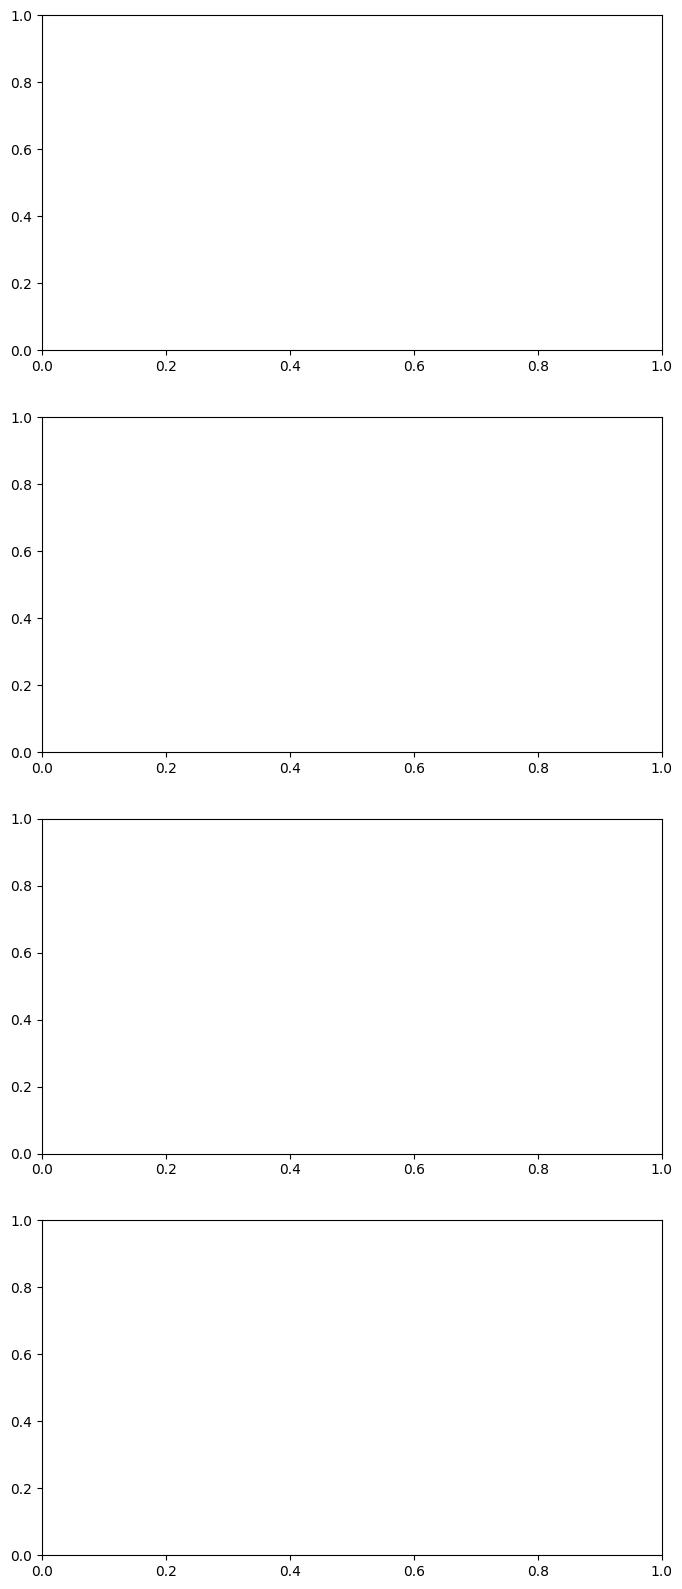

In [248]:
import os
import py3Dmol
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Define the folder where PDB files are saved
output_folder = "/content/exported_pdbs_with_pdb"

# List all the PDB files in the folder
pdb_files = [f for f in os.listdir(output_folder) if f.endswith(".pdb")]

# Create a matplotlib figure (this is optional if you don't need subplots for other things)
fig, axes = plt.subplots(len(pdb_files), 1, figsize=(8, 5 * len(pdb_files)))

# If there's only one plot, axes will not be an array, so we handle it
if len(pdb_files) == 1:
    axes = [axes]

# Loop through each PDB file and add it to the viewer
for i, pdb_file in enumerate(pdb_files):
    pdb_path = os.path.join(output_folder, pdb_file)
    pdb_id = pdb_file.split('.')[0]  # Extract the PDB ID (filename without extension)

    # Display the PDB ID as the headline
    display(HTML(f"<h3>{pdb_id}</h3>"))

    # Read the PDB data
    with open(pdb_path, 'r') as f:
        pdb_data = f.read()

    # Create py3Dmol viewer for each PDB file
    viewer = py3Dmol.view(width=800, height=400)  # Adjust the height for better display
    viewer.addModel(pdb_data, 'pdb')  # Add PDB model to viewer
    viewer.setStyle({'cartoon': {'color': 'spectrum'}})  # Set style
    viewer.zoomTo()  # Optional: Auto-zoom to fit the structure

    # Display the viewer
    display(viewer)

# Adjust layout
#plt.tight_layout()
#plt.show()



###Fetching Mobile Structures from AlphaFold DB

In [249]:
ddb_list=processed_df["Entry"].tolist()

In [250]:
len(ddb_list)

54

In [251]:
 pip install "biobb_io==4.2.0"

In [253]:
import os
from biobb_io.api.alphafold import alphafold

# Define the output directory
output_dir = '/content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List of 5000 UniProt codes (replace this with your actual list)
uniprot_codes = ddb_list #random_samples # Add your 5000 UniProt codes here

# Fetch PDB files for each UniProt code
for i, uniprot_code in enumerate(uniprot_codes):
    # Define the output PDB file path
    output_pdb_path = os.path.join(output_dir, f'{uniprot_code}.pdb')

    # Define the properties for AlphaFold
    prop = {
        'uniprot_code': uniprot_code
    }

    # Call the AlphaFold API
    alphafold(output_pdb_path=output_pdb_path, properties=prop)

    print(f'Saved: {output_pdb_path}')

2025-04-22 11:57:29,365 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log251.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:29,370 [MainThread  ] [INFO ]  Downloading P15482 from: https://alphafold.ebi.ac.uk/files/AF-P15482-F1-model_v3.pdb


INFO:/content/log251.out:Downloading P15482 from: https://alphafold.ebi.ac.uk/files/AF-P15482-F1-model_v3.pdb


2025-04-22 11:57:29,498 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P15482.pdb


INFO:/content/log251.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P15482.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P15482.pdb
2025-04-22 11:57:29,531 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log252.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:29,535 [MainThread  ] [INFO ]  Downloading Q2EES9 from: https://alphafold.ebi.ac.uk/files/AF-Q2EES9-F1-model_v3.pdb


INFO:/content/log252.out:Downloading Q2EES9 from: https://alphafold.ebi.ac.uk/files/AF-Q2EES9-F1-model_v3.pdb


2025-04-22 11:57:29,553 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q2EES9.pdb


INFO:/content/log252.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q2EES9.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q2EES9.pdb
2025-04-22 11:57:29,577 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log253.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:29,580 [MainThread  ] [INFO ]  Downloading Q1R904 from: https://alphafold.ebi.ac.uk/files/AF-Q1R904-F1-model_v3.pdb


INFO:/content/log253.out:Downloading Q1R904 from: https://alphafold.ebi.ac.uk/files/AF-Q1R904-F1-model_v3.pdb


2025-04-22 11:57:29,605 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q1R904.pdb


INFO:/content/log253.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q1R904.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q1R904.pdb
2025-04-22 11:57:29,631 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log254.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:29,636 [MainThread  ] [INFO ]  Downloading P9WKT6 from: https://alphafold.ebi.ac.uk/files/AF-P9WKT6-F1-model_v3.pdb


INFO:/content/log254.out:Downloading P9WKT6 from: https://alphafold.ebi.ac.uk/files/AF-P9WKT6-F1-model_v3.pdb


2025-04-22 11:57:29,693 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WKT6.pdb


INFO:/content/log254.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WKT6.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WKT6.pdb
2025-04-22 11:57:29,721 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log255.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:29,722 [MainThread  ] [INFO ]  Downloading Q9CK62 from: https://alphafold.ebi.ac.uk/files/AF-Q9CK62-F1-model_v3.pdb


INFO:/content/log255.out:Downloading Q9CK62 from: https://alphafold.ebi.ac.uk/files/AF-Q9CK62-F1-model_v3.pdb


2025-04-22 11:57:29,756 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q9CK62.pdb


INFO:/content/log255.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q9CK62.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q9CK62.pdb
2025-04-22 11:57:29,772 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log256.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:29,776 [MainThread  ] [INFO ]  Downloading P37510 from: https://alphafold.ebi.ac.uk/files/AF-P37510-F1-model_v3.pdb


INFO:/content/log256.out:Downloading P37510 from: https://alphafold.ebi.ac.uk/files/AF-P37510-F1-model_v3.pdb


2025-04-22 11:57:29,799 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P37510.pdb


INFO:/content/log256.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P37510.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P37510.pdb
2025-04-22 11:57:29,815 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log257.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:29,818 [MainThread  ] [INFO ]  Downloading P9WKT7 from: https://alphafold.ebi.ac.uk/files/AF-P9WKT7-F1-model_v3.pdb


INFO:/content/log257.out:Downloading P9WKT7 from: https://alphafold.ebi.ac.uk/files/AF-P9WKT7-F1-model_v3.pdb


2025-04-22 11:57:29,837 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WKT7.pdb


INFO:/content/log257.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WKT7.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WKT7.pdb
2025-04-22 11:57:29,856 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log258.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:29,861 [MainThread  ] [INFO ]  Downloading Q51506 from: https://alphafold.ebi.ac.uk/files/AF-Q51506-F1-model_v3.pdb


INFO:/content/log258.out:Downloading Q51506 from: https://alphafold.ebi.ac.uk/files/AF-Q51506-F1-model_v3.pdb


2025-04-22 11:57:29,888 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q51506.pdb


INFO:/content/log258.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q51506.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q51506.pdb
2025-04-22 11:57:29,919 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log259.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:29,921 [MainThread  ] [INFO ]  Downloading P22876 from: https://alphafold.ebi.ac.uk/files/AF-P22876-F1-model_v3.pdb


INFO:/content/log259.out:Downloading P22876 from: https://alphafold.ebi.ac.uk/files/AF-P22876-F1-model_v3.pdb


2025-04-22 11:57:29,939 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22876.pdb


INFO:/content/log259.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22876.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22876.pdb
2025-04-22 11:57:29,954 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log260.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:29,956 [MainThread  ] [INFO ]  Downloading P62174 from: https://alphafold.ebi.ac.uk/files/AF-P62174-F1-model_v3.pdb


INFO:/content/log260.out:Downloading P62174 from: https://alphafold.ebi.ac.uk/files/AF-P62174-F1-model_v3.pdb


2025-04-22 11:57:29,979 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P62174.pdb


INFO:/content/log260.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P62174.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P62174.pdb
2025-04-22 11:57:29,996 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log261.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:29,997 [MainThread  ] [INFO ]  Downloading P22874 from: https://alphafold.ebi.ac.uk/files/AF-P22874-F1-model_v3.pdb


INFO:/content/log261.out:Downloading P22874 from: https://alphafold.ebi.ac.uk/files/AF-P22874-F1-model_v3.pdb


2025-04-22 11:57:30,029 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22874.pdb


INFO:/content/log261.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22874.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22874.pdb
2025-04-22 11:57:30,060 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log262.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,062 [MainThread  ] [INFO ]  Downloading P50330 from: https://alphafold.ebi.ac.uk/files/AF-P50330-F1-model_v3.pdb


INFO:/content/log262.out:Downloading P50330 from: https://alphafold.ebi.ac.uk/files/AF-P50330-F1-model_v3.pdb


2025-04-22 11:57:30,086 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P50330.pdb


INFO:/content/log262.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P50330.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P50330.pdb
2025-04-22 11:57:30,102 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log263.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,103 [MainThread  ] [INFO ]  Downloading P37582 from: https://alphafold.ebi.ac.uk/files/AF-P37582-F1-model_v3.pdb


INFO:/content/log263.out:Downloading P37582 from: https://alphafold.ebi.ac.uk/files/AF-P37582-F1-model_v3.pdb


2025-04-22 11:57:30,122 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P37582.pdb


INFO:/content/log263.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P37582.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P37582.pdb
2025-04-22 11:57:30,143 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log264.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,146 [MainThread  ] [INFO ]  Downloading P0A2R1 from: https://alphafold.ebi.ac.uk/files/AF-P0A2R1-F1-model_v3.pdb


INFO:/content/log264.out:Downloading P0A2R1 from: https://alphafold.ebi.ac.uk/files/AF-P0A2R1-F1-model_v3.pdb


2025-04-22 11:57:30,168 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0A2R1.pdb


INFO:/content/log264.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0A2R1.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0A2R1.pdb
2025-04-22 11:57:30,187 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log265.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,191 [MainThread  ] [INFO ]  Downloading P62172 from: https://alphafold.ebi.ac.uk/files/AF-P62172-F1-model_v3.pdb


INFO:/content/log265.out:Downloading P62172 from: https://alphafold.ebi.ac.uk/files/AF-P62172-F1-model_v3.pdb


2025-04-22 11:57:30,211 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P62172.pdb


INFO:/content/log265.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P62172.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P62172.pdb
2025-04-22 11:57:30,228 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log266.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,233 [MainThread  ] [INFO ]  Downloading Q60329 from: https://alphafold.ebi.ac.uk/files/AF-Q60329-F1-model_v3.pdb


INFO:/content/log266.out:Downloading Q60329 from: https://alphafold.ebi.ac.uk/files/AF-Q60329-F1-model_v3.pdb


2025-04-22 11:57:30,258 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q60329.pdb


INFO:/content/log266.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q60329.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q60329.pdb
2025-04-22 11:57:30,280 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log267.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,285 [MainThread  ] [INFO ]  Downloading P0A2R0 from: https://alphafold.ebi.ac.uk/files/AF-P0A2R0-F1-model_v3.pdb


INFO:/content/log267.out:Downloading P0A2R0 from: https://alphafold.ebi.ac.uk/files/AF-P0A2R0-F1-model_v3.pdb


2025-04-22 11:57:30,306 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0A2R0.pdb


INFO:/content/log267.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0A2R0.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0A2R0.pdb
2025-04-22 11:57:30,322 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log268.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,323 [MainThread  ] [INFO ]  Downloading P50329 from: https://alphafold.ebi.ac.uk/files/AF-P50329-F1-model_v3.pdb


INFO:/content/log268.out:Downloading P50329 from: https://alphafold.ebi.ac.uk/files/AF-P50329-F1-model_v3.pdb


2025-04-22 11:57:30,343 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P50329.pdb


INFO:/content/log268.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P50329.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P50329.pdb
2025-04-22 11:57:30,359 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log269.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,360 [MainThread  ] [INFO ]  Downloading P62173 from: https://alphafold.ebi.ac.uk/files/AF-P62173-F1-model_v3.pdb


INFO:/content/log269.out:Downloading P62173 from: https://alphafold.ebi.ac.uk/files/AF-P62173-F1-model_v3.pdb


2025-04-22 11:57:30,379 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P62173.pdb


INFO:/content/log269.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P62173.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P62173.pdb
2025-04-22 11:57:30,394 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log270.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,395 [MainThread  ] [INFO ]  Downloading P0ACS2 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS2-F1-model_v3.pdb


INFO:/content/log270.out:Downloading P0ACS2 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS2-F1-model_v3.pdb


2025-04-22 11:57:30,418 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0ACS2.pdb


INFO:/content/log270.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0ACS2.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0ACS2.pdb
2025-04-22 11:57:30,438 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log271.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,443 [MainThread  ] [INFO ]  Downloading Q06566 from: https://alphafold.ebi.ac.uk/files/AF-Q06566-F1-model_v3.pdb


INFO:/content/log271.out:Downloading Q06566 from: https://alphafold.ebi.ac.uk/files/AF-Q06566-F1-model_v3.pdb


2025-04-22 11:57:30,470 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q06566.pdb


INFO:/content/log271.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q06566.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q06566.pdb
2025-04-22 11:57:30,494 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log272.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,502 [MainThread  ] [INFO ]  Downloading P22537 from: https://alphafold.ebi.ac.uk/files/AF-P22537-F1-model_v3.pdb


INFO:/content/log272.out:Downloading P22537 from: https://alphafold.ebi.ac.uk/files/AF-P22537-F1-model_v3.pdb


2025-04-22 11:57:30,520 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22537.pdb


INFO:/content/log272.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22537.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22537.pdb
2025-04-22 11:57:30,538 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log273.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,542 [MainThread  ] [INFO ]  Downloading Q9ZHI4 from: https://alphafold.ebi.ac.uk/files/AF-Q9ZHI4-F1-model_v3.pdb


INFO:/content/log273.out:Downloading Q9ZHI4 from: https://alphafold.ebi.ac.uk/files/AF-Q9ZHI4-F1-model_v3.pdb


2025-04-22 11:57:30,565 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q9ZHI4.pdb


INFO:/content/log273.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q9ZHI4.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q9ZHI4.pdb
2025-04-22 11:57:30,585 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log274.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,587 [MainThread  ] [INFO ]  Downloading P0ACS3 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS3-F1-model_v3.pdb


INFO:/content/log274.out:Downloading P0ACS3 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS3-F1-model_v3.pdb


2025-04-22 11:57:30,606 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0ACS3.pdb


INFO:/content/log274.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0ACS3.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0ACS3.pdb
2025-04-22 11:57:30,626 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log275.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,631 [MainThread  ] [INFO ]  Downloading P0ACS4 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS4-F1-model_v3.pdb


INFO:/content/log275.out:Downloading P0ACS4 from: https://alphafold.ebi.ac.uk/files/AF-P0ACS4-F1-model_v3.pdb


2025-04-22 11:57:30,655 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0ACS4.pdb


INFO:/content/log275.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0ACS4.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0ACS4.pdb
2025-04-22 11:57:30,675 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log276.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,680 [MainThread  ] [INFO ]  Downloading Q9RMW0 from: https://alphafold.ebi.ac.uk/files/AF-Q9RMW0-F1-model_v3.pdb


INFO:/content/log276.out:Downloading Q9RMW0 from: https://alphafold.ebi.ac.uk/files/AF-Q9RMW0-F1-model_v3.pdb


2025-04-22 11:57:30,703 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q9RMW0.pdb


INFO:/content/log276.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q9RMW0.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q9RMW0.pdb
2025-04-22 11:57:30,720 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log277.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,727 [MainThread  ] [INFO ]  Downloading Q45666 from: https://alphafold.ebi.ac.uk/files/AF-Q45666-F1-model_v3.pdb


INFO:/content/log277.out:Downloading Q45666 from: https://alphafold.ebi.ac.uk/files/AF-Q45666-F1-model_v3.pdb


2025-04-22 11:57:30,748 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q45666.pdb


INFO:/content/log277.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q45666.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q45666.pdb
2025-04-22 11:57:30,772 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log278.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,778 [MainThread  ] [INFO ]  Downloading O69717 from: https://alphafold.ebi.ac.uk/files/AF-O69717-F1-model_v3.pdb


INFO:/content/log278.out:Downloading O69717 from: https://alphafold.ebi.ac.uk/files/AF-O69717-F1-model_v3.pdb


2025-04-22 11:57:30,799 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/O69717.pdb


INFO:/content/log278.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/O69717.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/O69717.pdb
2025-04-22 11:57:30,821 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log279.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,826 [MainThread  ] [INFO ]  Downloading Q53W62 from: https://alphafold.ebi.ac.uk/files/AF-Q53W62-F1-model_v3.pdb


INFO:/content/log279.out:Downloading Q53W62 from: https://alphafold.ebi.ac.uk/files/AF-Q53W62-F1-model_v3.pdb


2025-04-22 11:57:30,845 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q53W62.pdb


INFO:/content/log279.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q53W62.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q53W62.pdb
2025-04-22 11:57:30,869 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log280.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,873 [MainThread  ] [INFO ]  Downloading O06474 from: https://alphafold.ebi.ac.uk/files/AF-O06474-F1-model_v3.pdb


INFO:/content/log280.out:Downloading O06474 from: https://alphafold.ebi.ac.uk/files/AF-O06474-F1-model_v3.pdb


2025-04-22 11:57:30,895 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/O06474.pdb


INFO:/content/log280.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/O06474.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/O06474.pdb
2025-04-22 11:57:30,917 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log281.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,919 [MainThread  ] [INFO ]  Downloading P13111 from: https://alphafold.ebi.ac.uk/files/AF-P13111-F1-model_v3.pdb


INFO:/content/log281.out:Downloading P13111 from: https://alphafold.ebi.ac.uk/files/AF-P13111-F1-model_v3.pdb


2025-04-22 11:57:30,944 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P13111.pdb


INFO:/content/log281.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P13111.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P13111.pdb
2025-04-22 11:57:30,963 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log282.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:30,965 [MainThread  ] [INFO ]  Downloading G2RUZ1 from: https://alphafold.ebi.ac.uk/files/AF-G2RUZ1-F1-model_v3.pdb


INFO:/content/log282.out:Downloading G2RUZ1 from: https://alphafold.ebi.ac.uk/files/AF-G2RUZ1-F1-model_v3.pdb


2025-04-22 11:57:30,988 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/G2RUZ1.pdb


INFO:/content/log282.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/G2RUZ1.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/G2RUZ1.pdb
2025-04-22 11:57:31,007 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log283.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,011 [MainThread  ] [INFO ]  Downloading P97032 from: https://alphafold.ebi.ac.uk/files/AF-P97032-F1-model_v3.pdb


INFO:/content/log283.out:Downloading P97032 from: https://alphafold.ebi.ac.uk/files/AF-P97032-F1-model_v3.pdb


2025-04-22 11:57:31,033 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P97032.pdb


INFO:/content/log283.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P97032.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P97032.pdb
2025-04-22 11:57:31,056 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log284.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,061 [MainThread  ] [INFO ]  Downloading P39075 from: https://alphafold.ebi.ac.uk/files/AF-P39075-F1-model_v3.pdb


INFO:/content/log284.out:Downloading P39075 from: https://alphafold.ebi.ac.uk/files/AF-P39075-F1-model_v3.pdb


2025-04-22 11:57:31,085 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P39075.pdb


INFO:/content/log284.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P39075.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P39075.pdb
2025-04-22 11:57:31,114 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log285.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,120 [MainThread  ] [INFO ]  Downloading Q50899 from: https://alphafold.ebi.ac.uk/files/AF-Q50899-F1-model_v3.pdb


INFO:/content/log285.out:Downloading Q50899 from: https://alphafold.ebi.ac.uk/files/AF-Q50899-F1-model_v3.pdb


2025-04-22 11:57:31,145 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q50899.pdb


INFO:/content/log285.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q50899.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q50899.pdb
2025-04-22 11:57:31,165 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log286.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,166 [MainThread  ] [INFO ]  Downloading Q50899 from: https://alphafold.ebi.ac.uk/files/AF-Q50899-F1-model_v3.pdb


INFO:/content/log286.out:Downloading Q50899 from: https://alphafold.ebi.ac.uk/files/AF-Q50899-F1-model_v3.pdb


2025-04-22 11:57:31,195 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q50899.pdb


INFO:/content/log286.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q50899.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q50899.pdb
2025-04-22 11:57:31,217 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log287.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,224 [MainThread  ] [INFO ]  Downloading P22853 from: https://alphafold.ebi.ac.uk/files/AF-P22853-F1-model_v3.pdb


INFO:/content/log287.out:Downloading P22853 from: https://alphafold.ebi.ac.uk/files/AF-P22853-F1-model_v3.pdb


2025-04-22 11:57:31,244 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22853.pdb


INFO:/content/log287.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22853.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22853.pdb
2025-04-22 11:57:31,266 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log288.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,271 [MainThread  ] [INFO ]  Downloading P45876 from: https://alphafold.ebi.ac.uk/files/AF-P45876-F1-model_v3.pdb


INFO:/content/log288.out:Downloading P45876 from: https://alphafold.ebi.ac.uk/files/AF-P45876-F1-model_v3.pdb


2025-04-22 11:57:31,296 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P45876.pdb


INFO:/content/log288.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P45876.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P45876.pdb
2025-04-22 11:57:31,320 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log289.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,321 [MainThread  ] [INFO ]  Downloading P44617 from: https://alphafold.ebi.ac.uk/files/AF-P44617-F1-model_v3.pdb


INFO:/content/log289.out:Downloading P44617 from: https://alphafold.ebi.ac.uk/files/AF-P44617-F1-model_v3.pdb


2025-04-22 11:57:31,347 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P44617.pdb


INFO:/content/log289.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P44617.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P44617.pdb
2025-04-22 11:57:31,369 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log290.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,371 [MainThread  ] [INFO ]  Downloading P40183 from: https://alphafold.ebi.ac.uk/files/AF-P40183-F1-model_v3.pdb


INFO:/content/log290.out:Downloading P40183 from: https://alphafold.ebi.ac.uk/files/AF-P40183-F1-model_v3.pdb


2025-04-22 11:57:31,397 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P40183.pdb


INFO:/content/log290.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P40183.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P40183.pdb
2025-04-22 11:57:31,432 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log291.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,436 [MainThread  ] [INFO ]  Downloading P39842 from: https://alphafold.ebi.ac.uk/files/AF-P39842-F1-model_v3.pdb


INFO:/content/log291.out:Downloading P39842 from: https://alphafold.ebi.ac.uk/files/AF-P39842-F1-model_v3.pdb


2025-04-22 11:57:31,461 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P39842.pdb


INFO:/content/log291.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P39842.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P39842.pdb
2025-04-22 11:57:31,495 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log292.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,501 [MainThread  ] [INFO ]  Downloading P67672 from: https://alphafold.ebi.ac.uk/files/AF-P67672-F1-model_v3.pdb


INFO:/content/log292.out:Downloading P67672 from: https://alphafold.ebi.ac.uk/files/AF-P67672-F1-model_v3.pdb


2025-04-22 11:57:31,530 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P67672.pdb


INFO:/content/log292.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P67672.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P67672.pdb
2025-04-22 11:57:31,585 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log293.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,589 [MainThread  ] [INFO ]  Downloading P30791 from: https://alphafold.ebi.ac.uk/files/AF-P30791-F1-model_v3.pdb


INFO:/content/log293.out:Downloading P30791 from: https://alphafold.ebi.ac.uk/files/AF-P30791-F1-model_v3.pdb


2025-04-22 11:57:31,610 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P30791.pdb


INFO:/content/log293.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P30791.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P30791.pdb
2025-04-22 11:57:31,629 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log294.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,631 [MainThread  ] [INFO ]  Downloading P44558 from: https://alphafold.ebi.ac.uk/files/AF-P44558-F1-model_v3.pdb


INFO:/content/log294.out:Downloading P44558 from: https://alphafold.ebi.ac.uk/files/AF-P44558-F1-model_v3.pdb


2025-04-22 11:57:31,654 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P44558.pdb


INFO:/content/log294.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P44558.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P44558.pdb
2025-04-22 11:57:31,668 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log295.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,670 [MainThread  ] [INFO ]  Downloading Q55963 from: https://alphafold.ebi.ac.uk/files/AF-Q55963-F1-model_v3.pdb


INFO:/content/log295.out:Downloading Q55963 from: https://alphafold.ebi.ac.uk/files/AF-Q55963-F1-model_v3.pdb


2025-04-22 11:57:31,687 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q55963.pdb


INFO:/content/log295.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q55963.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q55963.pdb
2025-04-22 11:57:31,703 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log296.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,704 [MainThread  ] [INFO ]  Downloading P0A2Q8 from: https://alphafold.ebi.ac.uk/files/AF-P0A2Q8-F1-model_v3.pdb


INFO:/content/log296.out:Downloading P0A2Q8 from: https://alphafold.ebi.ac.uk/files/AF-P0A2Q8-F1-model_v3.pdb


2025-04-22 11:57:31,724 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0A2Q8.pdb


INFO:/content/log296.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0A2Q8.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P0A2Q8.pdb
2025-04-22 11:57:31,737 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log297.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,738 [MainThread  ] [INFO ]  Downloading P55393 from: https://alphafold.ebi.ac.uk/files/AF-P55393-F1-model_v3.pdb


INFO:/content/log297.out:Downloading P55393 from: https://alphafold.ebi.ac.uk/files/AF-P55393-F1-model_v3.pdb


2025-04-22 11:57:31,754 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P55393.pdb


INFO:/content/log297.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P55393.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P55393.pdb
2025-04-22 11:57:31,765 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log298.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,766 [MainThread  ] [INFO ]  Downloading P22896 from: https://alphafold.ebi.ac.uk/files/AF-P22896-F1-model_v3.pdb


INFO:/content/log298.out:Downloading P22896 from: https://alphafold.ebi.ac.uk/files/AF-P22896-F1-model_v3.pdb


2025-04-22 11:57:31,783 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22896.pdb


INFO:/content/log298.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22896.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P22896.pdb
2025-04-22 11:57:31,795 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log299.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,797 [MainThread  ] [INFO ]  Downloading Q93CH6 from: https://alphafold.ebi.ac.uk/files/AF-Q93CH6-F1-model_v3.pdb


INFO:/content/log299.out:Downloading Q93CH6 from: https://alphafold.ebi.ac.uk/files/AF-Q93CH6-F1-model_v3.pdb


2025-04-22 11:57:31,812 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q93CH6.pdb


INFO:/content/log299.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q93CH6.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/Q93CH6.pdb
2025-04-22 11:57:31,826 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log300.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,827 [MainThread  ] [INFO ]  Downloading P94661 from: https://alphafold.ebi.ac.uk/files/AF-P94661-F1-model_v3.pdb


INFO:/content/log300.out:Downloading P94661 from: https://alphafold.ebi.ac.uk/files/AF-P94661-F1-model_v3.pdb


2025-04-22 11:57:31,843 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P94661.pdb


INFO:/content/log300.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P94661.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P94661.pdb
2025-04-22 11:57:31,857 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log301.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,858 [MainThread  ] [INFO ]  Downloading P9WME5 from: https://alphafold.ebi.ac.uk/files/AF-P9WME5-F1-model_v3.pdb


INFO:/content/log301.out:Downloading P9WME5 from: https://alphafold.ebi.ac.uk/files/AF-P9WME5-F1-model_v3.pdb


2025-04-22 11:57:31,876 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WME5.pdb


INFO:/content/log301.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WME5.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WME5.pdb
2025-04-22 11:57:31,894 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log302.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,896 [MainThread  ] [INFO ]  Downloading P9WME4 from: https://alphafold.ebi.ac.uk/files/AF-P9WME4-F1-model_v3.pdb


INFO:/content/log302.out:Downloading P9WME4 from: https://alphafold.ebi.ac.uk/files/AF-P9WME4-F1-model_v3.pdb


2025-04-22 11:57:31,917 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WME4.pdb


INFO:/content/log302.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WME4.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/P9WME4.pdb
2025-04-22 11:57:31,930 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log303.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,932 [MainThread  ] [INFO ]  Downloading A9KE66 from: https://alphafold.ebi.ac.uk/files/AF-A9KE66-F1-model_v3.pdb


INFO:/content/log303.out:Downloading A9KE66 from: https://alphafold.ebi.ac.uk/files/AF-A9KE66-F1-model_v3.pdb


2025-04-22 11:57:31,949 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/A9KE66.pdb


INFO:/content/log303.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/A9KE66.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/A9KE66.pdb
2025-04-22 11:57:31,961 [MainThread  ] [INFO ]  Executing biobb_io.api.alphafold Version: 4.2.0


INFO:/content/log304.out:Executing biobb_io.api.alphafold Version: 4.2.0


2025-04-22 11:57:31,962 [MainThread  ] [INFO ]  Downloading B6IZY6 from: https://alphafold.ebi.ac.uk/files/AF-B6IZY6-F1-model_v3.pdb


INFO:/content/log304.out:Downloading B6IZY6 from: https://alphafold.ebi.ac.uk/files/AF-B6IZY6-F1-model_v3.pdb


2025-04-22 11:57:31,979 [MainThread  ] [INFO ]  Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/B6IZY6.pdb


INFO:/content/log304.out:Writting pdb to: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/B6IZY6.pdb


Saved: /content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter/B6IZY6.pdb


####displaying Example Structure

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

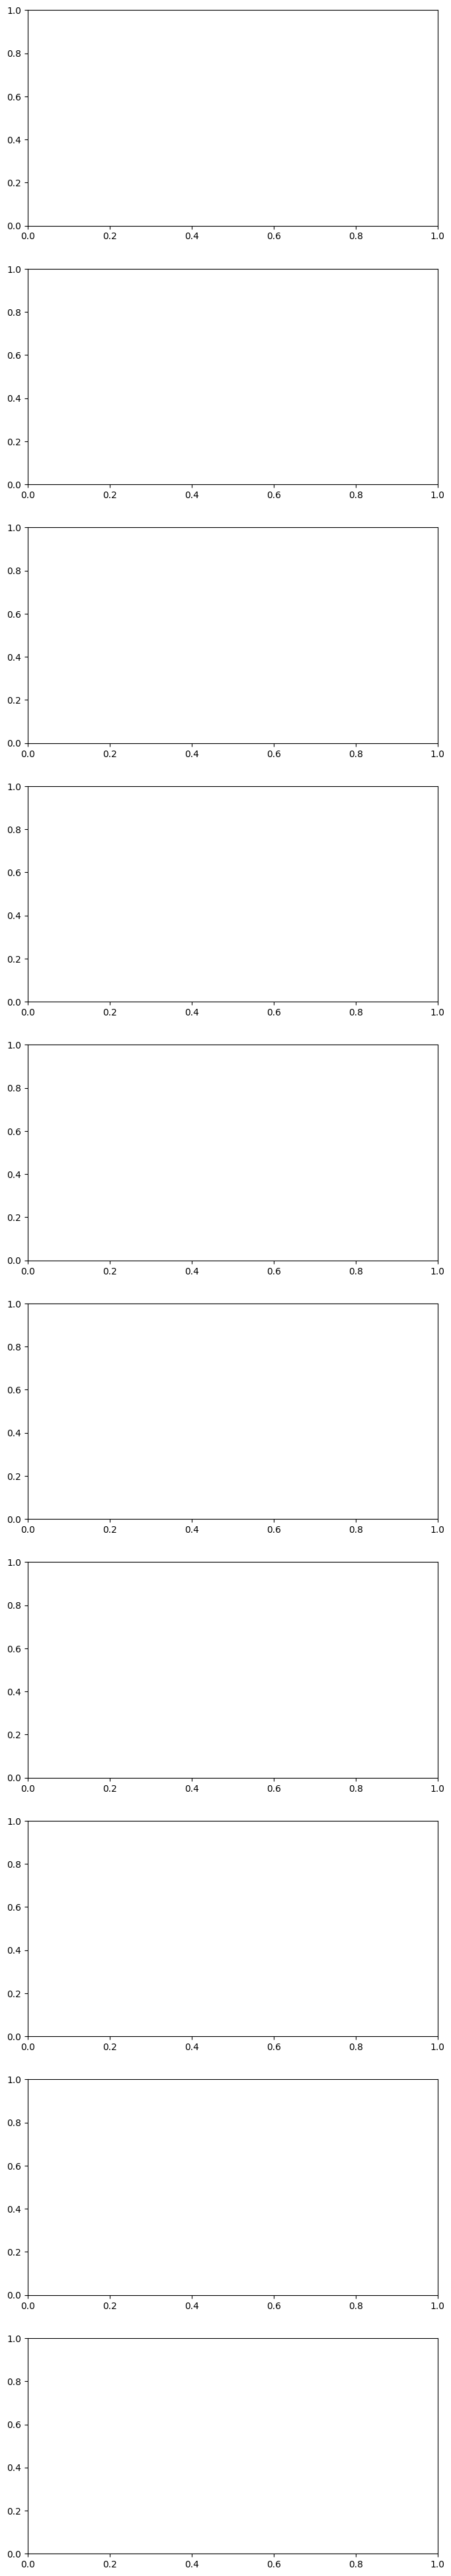

In [255]:
import os
import py3Dmol
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import random

# Define the folder where PDB files are saved
output_folder = "/content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter"

# List all the PDB files in the folder
pdb_files = [f for f in os.listdir(output_folder) if f.endswith(".pdb")]
pdb_files = random.sample(pdb_files, min(10, len(pdb_files)))

# Create a matplotlib figure (this is optional if you don't need subplots for other things)
fig, axes = plt.subplots(len(pdb_files), 1, figsize=(8, 5 * len(pdb_files)))

# If there's only one plot, axes will not be an array, so we handle it
if len(pdb_files) == 1:
    axes = [axes]

# Loop through each PDB file and add it to the viewer
for i, pdb_file in enumerate(pdb_files):
    pdb_path = os.path.join(output_folder, pdb_file)
    pdb_id = pdb_file.split('.')[0]  # Extract the PDB ID (filename without extension)

    # Display the PDB ID as the headline
    display(HTML(f"<h3>{pdb_id}</h3>"))

    # Read the PDB data
    with open(pdb_path, 'r') as f:
        pdb_data = f.read()

    # Create py3Dmol viewer for each PDB file
    viewer = py3Dmol.view(width=800, height=400)  # Adjust the height for better display
    viewer.addModel(pdb_data, 'pdb')  # Add PDB model to viewer
    viewer.setStyle({'cartoon': {'color': 'spectrum'}})  # Set style
    viewer.zoomTo()  # Optional: Auto-zoom to fit the structure

    # Display the viewer
    display(viewer)

# Adjust layout
#plt.tight_layout()
#plt.show()

###Loading Structures in Dictionary





In [256]:
import os
import biotite.structure.io.pdb as pdb
import biotite.structure as struc
from tqdm import tqdm
from collections import defaultdict

# Define folder path where PDB files are stored
pdb_folder = "/content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter"

# List all PDB files in the folder
pdb_files = [f for f in os.listdir(pdb_folder) if f.endswith(".pdb")]

# Dictionary to store structures
struc_dict_rmsd={}

def load_and_process(pdb_path):
    """Load a PDB file from local storage and process it."""
    pdb_file = pdb.PDBFile.read(pdb_path)  # Read PDB file
    structure = pdb.get_structure(pdb_file, model=1)  # Load first model

    # Generate bond list
    bond_list = struc.connect_via_residue_names(structure)
    structure.bonds = bond_list

    return structure

# Load and process each PDB file
for pdb_file in tqdm(pdb_files, desc="Loading and processing structures"):
    pdb_id = os.path.splitext(pdb_file)[0]  # Get PDB ID (filename without extension)
    pdb_path = os.path.join(pdb_folder, pdb_file)  # Full path
    struc_dict_rmsd[pdb_id] = load_and_process(pdb_path)

print(f"Loaded {len(struc_dict_rmsd)} structures.")


Loading and processing structures: 100%|██████████| 53/53 [00:01<00:00, 42.63it/s]

Loaded 53 structures.


In [257]:
df_domains=processed_df

In [258]:
df_domains=df_domains[df_domains["domain_note"]=="HTH merR-type"]

entry_dict_rsmd_motif = dict(zip(df_domains["Entry"], zip(df_domains["start_motif"], df_domains["end_motif"])))
entry_dict_rsmd_domain = dict(zip(df_domains["Entry"], zip(df_domains["start_domain"], df_domains["end_domain"])))

In [260]:
common_keys = entry_dict_rsmd_domain.keys() & struc_dict_rmsd.keys()
print("Common keys:", common_keys)
print(len(common_keys))



Common keys: {'P0ACS3', 'P50329', 'P9WME4', 'P37582', 'P44558', 'P9WME5', 'P13111', 'P0ACS4', 'Q93CH6', 'Q55963', 'Q45666', 'P67672', 'P22874', 'P0A2R0', 'Q9ZHI4', 'P39842', 'P62173', 'P22853', 'P37510', 'O06474', 'P22896', 'P50330', 'P22537', 'P40183', 'Q51506', 'P44617', 'G2RUZ1', 'P39075', 'P0A2R1', 'P0A2Q8', 'P62174', 'P0ACS2', 'Q50899', 'P62172', 'Q53W62'}
35


###Extracting Domain from Complete Protein Prediction

In [344]:
from collections import defaultdict
import pandas as pd

def filter_atoms(atoms_dict, pdb_range_expanded_fixed, name):
    filtered_atoms_dict = defaultdict(list)  # Use a properly named dictionary

    for pdb_id, atom_list in atoms_dict.items():
        if pdb_id in pdb_range_expanded_fixed:
            start, end = pdb_range_expanded_fixed[pdb_id]
            #print(type(atom_list))

    # Ensure they are integers
            start = int(start)
            end = int(end)

            #print(pdb_id)
            #print(start)
            #print(end)

            if pd.isna(start) or pd.isna(end):
              print(f"Skipping {pdb_id} due to NaN start/end values.")
            else:
              print(f"Processing {pdb_id} with range {start}-{end}")


            filtered_atoms = []

            for atom in atom_list:
              #print(atom.res_id)
                #if is_dna_residue(atom.res_name):
                 #   filtered_atoms.append(atom)
              if start <= atom.res_id <= end:
                    filtered_atoms.append(atom)

            filtered_atoms_dict[pdb_id].extend(filtered_atoms)
        else:
            #filtered_atoms_dict[pdb_id].extend(atom_list)
            print("problem")

    return filtered_atoms_dict

# Correct function call
filtered_atoms_dict_RSMD_4 = filter_atoms(struc_dict_rmsd, entry_dict_rsmd_domain, "RSMD<7")


Processing P62173 with range 10-78
problem
Processing P62174 with range 10-78
problem
Processing P37510 with range 3-72
Processing P0ACS3 with range 11-79
Processing Q50899 with range 2-73
problem
Processing P22896 with range 5-74
problem
Processing P0A2R0 with range 11-79
Processing Q9ZHI4 with range 5-73
Processing P0ACS4 with range 11-79
Processing P39075 with range 5-75
problem
problem
Processing P13111 with range 7-76
Processing P39842 with range 8-77
Processing P44617 with range 1-69
problem
Processing P9WME5 with range 64-136
Processing P0A2Q8 with range 7-76
Processing Q93CH6 with range 1-69
problem
Processing P22874 with range 1-71
Processing P22537 with range 10-79
problem
Processing P50329 with range 10-79
Processing Q45666 with range 13-81
Processing P40183 with range 17-86
problem
Processing P0A2R1 with range 11-79
Processing P22853 with range 2-71
Processing P0ACS2 with range 11-79
problem
Processing P62172 with range 10-78
Processing Q51506 with range 9-77
problem
Proces

In [345]:
for key, atoms in filtered_atoms_dict_RSMD_4.items():
    # Extract all residue IDs (res_id)
    res_ids = [atom.res_id for atom in atoms]

    # Get min and max residue ID
    try:
      min_res = min(res_ids)
      max_res = max(res_ids)
    except:
      continue

    # Print results
    #print(f"{key}: Min res_id = {min_res}, Max res_id = {max_res}")


In [264]:
def list_to_atom_array(atom_list):
    array = AtomArray(len(atom_list))
    for i, atom in enumerate(atom_list):
        array.coord[i] = atom.coord
        array.chain_id[i] = atom.chain_id
        array.res_id[i] = atom.res_id
        array.ins_code[i] = atom.ins_code
        array.res_name[i] = atom.res_name
        array.hetero[i] = atom.hetero
        array.atom_name[i] = atom.atom_name
        array.element[i] = atom.element
    return array

####exporting dict to pdb

In [346]:
import os
import biotite.structure.io.pdb as pdb
import os
import numpy as np
from collections import defaultdict
import biotite.structure as struc
import biotite.structure.io as strucio
from biotite.structure import AffineTransformation, AtomArray, partial_charges

from tqdm import tqdm
from biotite.structure.io import pdbx
import biotite.database.rcsb as rcsb
from scipy.spatial.distance import cdist



# Define the output folder
output_folder = "mobile_structures_sliced_foldseek_hits_rmsd_4_filtered"

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Dictionary containing Biotite AtomArrays


# Save each structure as a PDB file in the folder
for pdb_id, atom_array in filtered_atoms_dict_RSMD_4.items():
    atom_array=list_to_atom_array(atom_array)
    pdb_file = pdb.PDBFile()
    pdb_file.set_structure(atom_array)

    file_path = os.path.join(output_folder, f"{pdb_id}.pdb")  # Full path
    pdb_file.write(file_path)
    #print(f"Saved: {file_path}")


###Alignment of Mobile Structure to Previously Identified Fixed Structure

For the alignment, the helix-turn-helix motif extracted from the DNA binding column was aligned, and the remaining atoms of the domain were translated accordingly.


In [265]:
import os
import glob
import pandas as pd
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import biotite.structure.io as strucio
from biotite.structure import filter_nucleotides,filter_canonical_amino_acids
from tqdm import tqdm
import numpy as np
from collections import defaultdict
from biotite.structure.io import pdbx
import biotite.structure as struc
import biotite.structure.io as strucio
from tqdm import tqdm
import biotite.sequence as seq
import biotite.sequence.align as align
from biotite.structure.io import pdbx
from biotite.structure.io.pdb import PDBFile
import biotite
import biotite.database.rcsb as rcsb

import biotite.structure as struc
import biotite.structure.io as strucio
from datetime import datetime



def fetch_and_process(pdb_id):
    # Fetch and load structure
    pdbx_file = pdbx.BinaryCIFFile.read(rcsb.fetch(pdb_id, "bcif"))
    structure = pdbx.get_structure(pdbx_file, model=1)
    structure=structure[structure.chain_id!="B"]

    # Generate a bond list for the atom array
    bond_list = struc.connect_via_residue_names(structure)
    structure.bonds = bond_list

    # Ensure the atom array has a 'charge' attribute, set to 0 by default
    #structure.charge = np.zeros(structure.array_length(), dtype=int)

    # Check if the structure already contains hydrogen atoms
    #if not np.any(structure.element == "H"):
        # Add hydrogen atoms and relax their positions
     #   structure, _ = hydride.add_hydrogen(structure)
      #  structure.coord = hydride.relax_hydrogen(structure)

    # Return the processed structure
    return structure


struc_dict={}
sturc_dict_fixed={}
# Paths to the two folderson
file1 = "/4wlw (1).pdb"
folder2 = "/content/AlphaFold_Foldseek_hits_final_Evalue_05_filter_domain_filter"
output_folder = "/content/aligned_pdbs_prop_013_unbound"
os.makedirs(output_folder, exist_ok=True)




# Load the DataFrame
  # Initialize an empty column for RMSD scores


pdb_files2 = glob.glob(os.path.join(folder2, "*.pdb"))

# Extract unique Uniprot IDs from filenames (assuming format Uniprot_xxx.pdb)

uniprot_ids2 = {os.path.basename(f).split("_")[0]: f for f in pdb_files2}

print("Uniprot IDs in mobile folder:", uniprot_ids2.keys())

# Find common Uniprot IDs

# Store RMSD scores
rmsd_scores = {}



fixed_pdb_ids = ["4WLS"]

for pdb_id in tqdm(fixed_pdb_ids, desc="Fetching and processing structures"):
    sturc_dict_fixed[pdb_id] = fetch_and_process(pdb_id)

for uniprot_id in uniprot_ids2:

    file2 = uniprot_ids2[uniprot_id]



    # Load both PDB structures

    atom_array2 = pdb.PDBFile.read(file2).get_structure(model=1)
    struc_dict[uniprot_id]=atom_array2





Uniprot IDs in mobile folder: dict_keys(['P62173.pdb', 'P55393.pdb', 'P62174.pdb', 'Q60329.pdb', 'P37510.pdb', 'P0ACS3.pdb', 'Q50899.pdb', 'P9WKT7.pdb', 'P22896.pdb', 'Q9RMW0.pdb', 'P0A2R0.pdb', 'Q9ZHI4.pdb', 'P0ACS4.pdb', 'P39075.pdb', 'P30791.pdb', 'P15482.pdb', 'P13111.pdb', 'P39842.pdb', 'P44617.pdb', 'Q1R904.pdb', 'P9WME5.pdb', 'P0A2Q8.pdb', 'Q93CH6.pdb', 'P22876.pdb', 'P22874.pdb', 'P22537.pdb', 'A9KE66.pdb', 'P50329.pdb', 'Q45666.pdb', 'P40183.pdb', 'B6IZY6.pdb', 'P0A2R1.pdb', 'P22853.pdb', 'P0ACS2.pdb', 'Q06566.pdb', 'P62172.pdb', 'Q51506.pdb', 'P45876.pdb', 'P67672.pdb', 'Q53W62.pdb', 'P44558.pdb', 'G2RUZ1.pdb', 'P37582.pdb', 'P9WME4.pdb', 'O69717.pdb', 'P94661.pdb', 'P9WKT6.pdb', 'Q2EES9.pdb', 'P50330.pdb', 'P97032.pdb', 'O06474.pdb', 'Q9CK62.pdb', 'Q55963.pdb'])


Fetching and processing structures: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


In [266]:
# Rename keys to remove '.pdb' after storing them
struc_dict = {key.replace(".pdb", ""): value for key, value in struc_dict.items()}
sturc_dict_fixed = {key.replace(".pdb", ""): value for key, value in sturc_dict_fixed.items()}

In [347]:
#struc_dict.keys()

In [348]:
#sturc_dict_fixed.keys()

In [270]:
entry_dict_rsmd_domain["4WLS"]=(1,69)
entry_dict_rsmd_motif["4WLS"]=(4,23)

In [272]:
import os
import numpy as np
from collections import defaultdict
import biotite.structure as struc
import biotite.structure.io as strucio
from biotite.structure import AffineTransformation, AtomArray, partial_charges
#import hydride
from tqdm import tqdm
from biotite.structure.io import pdbx
import biotite.database.rcsb as rcsb
from scipy.spatial.distance import cdist


# Function to convert list of atoms back to an AtomArray
def list_to_atom_array(atom_list):
    array = AtomArray(len(atom_list))
    for i, atom in enumerate(atom_list):
        array.coord[i] = atom.coord
        array.chain_id[i] = atom.chain_id
        array.res_id[i] = atom.res_id
        array.ins_code[i] = atom.ins_code
        array.res_name[i] = atom.res_name
        array.hetero[i] = atom.hetero
        array.atom_name[i] = atom.atom_name
        array.element[i] = atom.element
    return array

# Function to filter atoms based on residue ranges
def filter_atoms(atoms_dict, position_ranges, default_start, default_end):
    filtered_atoms_dict = defaultdict(list)
    for pdb_id, atom_array in atoms_dict.items():
        # Check if custom range exists for pdb_id
        if  pdb_id in position_ranges:
            start, end = position_ranges[pdb_id]
        else:
            start, end = default_start, default_end  # Use default range if not in position_ranges

        # Filter atoms based on the range
        filtered_atoms = [atom for atom in atom_array if start <= atom.res_id <= end]
        filtered_atoms_dict[pdb_id].extend(filtered_atoms)

    return filtered_atoms_dict



default_start=3
default_end=4


# Filter the atom dictionary
filtered_atoms_dict_domain = filter_atoms(struc_dict, entry_dict_rsmd_domain, default_start, default_end)
filtered_atoms_dict_motif = filter_atoms(struc_dict, entry_dict_rsmd_motif, default_start, default_end)
filtered_atoms_dict_motif_fixed = filter_atoms(sturc_dict_fixed, entry_dict_rsmd_motif, default_start, default_end)
filtered_atoms_dict_domain_fixed = filter_atoms(sturc_dict_fixed, entry_dict_rsmd_domain, default_start, default_end)


# Fetch and process each structure

fixed_pdb_id="4WLS"

superimposed_structures={}
superimposed_structures_domain={}
for mobile_pdb_id in struc_dict.keys():
    print(mobile_pdb_id)
    if mobile_pdb_id == fixed_pdb_id:
        continue

    # Get the complete structure of the mobile protein
    mobile_structure_complete = struc_dict[mobile_pdb_id]
    mobile_structure_complete = list_to_atom_array(mobile_structure_complete)

    # Get the filtered structure from the filtered atoms dict
    mobile_structure_filtered = filtered_atoms_dict_motif[mobile_pdb_id]
    mobile_structure_filtered_domain=filtered_atoms_dict_domain[mobile_pdb_id]
    fixed_structure_filtered=filtered_atoms_dict_motif_fixed[fixed_pdb_id]






    mobile_structure_filtered = list_to_atom_array(mobile_structure_filtered)
    mobile_structure_filtered_domain = list_to_atom_array(mobile_structure_filtered_domain)
    fixed_structure_filtered = list_to_atom_array(fixed_structure_filtered)

    # Filter for chain A and CA atoms for alignment
    fixed_atoms_mask = (fixed_structure_filtered.chain_id == 'A') & (struc.filter_peptide_backbone(fixed_structure_filtered))
    mobile_atoms_mask = (mobile_structure_filtered.chain_id == 'A') & (struc.filter_peptide_backbone(mobile_structure_filtered))

    fixed_filtered_chain_A_CA = fixed_structure_filtered[fixed_atoms_mask]
    mobile_filtered_chain_A_CA = mobile_structure_filtered[mobile_atoms_mask]

    # Align the filtered structures based on chain A and CA atoms
    min_length = min(len(fixed_filtered_chain_A_CA), len(mobile_filtered_chain_A_CA))
    fitted_mobile_structure, transform = struc.superimpose(
        fixed_filtered_chain_A_CA[:min_length],
        mobile_filtered_chain_A_CA[:min_length]
    )
    print(min_length)

    distance_matrix = cdist(fitted_mobile_structure.coord, fixed_filtered_chain_A_CA.coord)

# For each mobile Cα atom, find the index of the closest fixed Cα atom
    min_indices = np.argmin(distance_matrix, axis=1)
    min_distances = distance_matrix[np.arange(distance_matrix.shape[0]), min_indices]

# Extract the residue ids from the fixed structure (adjust attribute name as needed)
# Here, I'm assuming that each fixed atom has an attribute "res_id" that holds the residue identifier.
    fixed_res_ids = fixed_filtered_chain_A_CA.res_id  # This should be an array-like of length N_fixed

# Now, for each mobile Cα atom, record the closest fixed residue id and the distance
    closest_info = []
    for mobile_idx, (min_idx, d) in enumerate(zip(min_indices, min_distances)):
      res_id = fixed_res_ids[min_idx]
      closest_info.append({
        'mobile_index': mobile_idx,    # index in the mobile structure
        'fixed_res_id': res_id,          # residue id of the closest fixed Cα atom
        'distance': d                  # distance between mobile and fixed Cα atoms
    })

    # Store the superimposed filtered structure
    superimposed_structures[mobile_pdb_id] = fitted_mobile_structure

    # Apply the transformation to the complete structure
    transformed_coordinates = AffineTransformation.apply(transform, atoms=mobile_structure_filtered_domain)

    # Store the transformed complete structure
    superimposed_structures_domain[mobile_pdb_id] = transformed_coordinates

    # Calculate RMSD for the filtered region
    rmsd = struc.rmsd(
        fixed_filtered_chain_A_CA.coord[:min_length],
        fitted_mobile_structure.coord[:min_length]
    )
    print(f"RMSD between {fixed_pdb_id} and {mobile_pdb_id}: {rmsd:.3f}")

P62173
60
RMSD between 4WLS and P62173: 2.865
P55393
6
RMSD between 4WLS and P55393: 0.607
P62174
60
RMSD between 4WLS and P62174: 2.866
Q60329
6
RMSD between 4WLS and Q60329: 0.702
P37510
60
RMSD between 4WLS and P37510: 3.081
P0ACS3
60
RMSD between 4WLS and P0ACS3: 2.998
Q50899
60
RMSD between 4WLS and Q50899: 3.159
P9WKT7
6
RMSD between 4WLS and P9WKT7: 0.667
P22896
60
RMSD between 4WLS and P22896: 3.183
Q9RMW0
6
RMSD between 4WLS and Q9RMW0: 0.746
P0A2R0
60
RMSD between 4WLS and P0A2R0: 3.000
Q9ZHI4
60
RMSD between 4WLS and Q9ZHI4: 3.075
P0ACS4
60
RMSD between 4WLS and P0ACS4: 2.996
P39075
60
RMSD between 4WLS and P39075: 3.107
P30791
6
RMSD between 4WLS and P30791: 0.785
P15482
6
RMSD between 4WLS and P15482: 0.672
P13111
60
RMSD between 4WLS and P13111: 3.074
P39842
60
RMSD between 4WLS and P39842: 3.070
P44617
60
RMSD between 4WLS and P44617: 0.261
Q1R904
6
RMSD between 4WLS and Q1R904: 0.611
P9WME5


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning:

invalid value encountered in divide



0
RMSD between 4WLS and P9WME5: nan
P0A2Q8
60
RMSD between 4WLS and P0A2Q8: 3.048
Q93CH6
60
RMSD between 4WLS and Q93CH6: 0.305
P22876
6
RMSD between 4WLS and P22876: 0.103
P22874
60
RMSD between 4WLS and P22874: 3.084
P22537
60
RMSD between 4WLS and P22537: 3.127
A9KE66
6
RMSD between 4WLS and A9KE66: 0.706
P50329
60
RMSD between 4WLS and P50329: 3.096
Q45666
60
RMSD between 4WLS and Q45666: 2.963
P40183
60
RMSD between 4WLS and P40183: 3.123
B6IZY6
6
RMSD between 4WLS and B6IZY6: 0.695
P0A2R1
60
RMSD between 4WLS and P0A2R1: 3.000
P22853
60
RMSD between 4WLS and P22853: 3.023
P0ACS2
60
RMSD between 4WLS and P0ACS2: 3.011
Q06566
6
RMSD between 4WLS and Q06566: 0.669
P62172
60
RMSD between 4WLS and P62172: 2.883
Q51506
60
RMSD between 4WLS and Q51506: 3.056
P45876
6
RMSD between 4WLS and P45876: 0.075
P67672
0
RMSD between 4WLS and P67672: nan
Q53W62
60
RMSD between 4WLS and Q53W62: 3.014
P44558
60
RMSD between 4WLS and P44558: 3.275
G2RUZ1
60
RMSD between 4WLS and G2RUZ1: 2.916
P37582

####Exporting Aligned Structures to PDB

In [274]:
import os
import biotite.structure.io.pdb as pdb
from biotite.structure import AffineTransformation, AtomArray, partial_charges

# Define the output folder
output_folder = "aligned_Evalue_05_unbound"

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Dictionary containing Biotite AtomArrays


# Save each structure as a PDB file in the folder
for pdb_id, atom_array in superimposed_structures_domain.items():
    atom_array=list_to_atom_array(atom_array)
    pdb_file = pdb.PDBFile()
    try:
      pdb_file.set_structure(atom_array)
    except:
      continue

    file_path = os.path.join(output_folder, f"{pdb_id}.pdb")  # Full path
    pdb_file.write(file_path)
    #print(f"Saved: {file_path}")

###Loading Aligned Structures in a DataFrame

In [349]:
import pandas as pd
import numpy as np

# Example: Convert dictionary of Biotite AtomArray structures into a DataFrame

# Initialize dictionary of PDB to AtomArray
# struc_dict = {'PDB_ID1': atom_array1, 'PDB_ID2': atom_array2, ...}

# Create an empty list to store the rows for the DataFrame
data = []

# Loop over each structure in the dictionary
for pdb_id, atom_array in superimposed_structures_domain.items():
    # Extract relevant information from the AtomArray
    for atom in atom_array:
        # Collect info for each atom (adjust as needed)
        row = {
            'PDB_ID': pdb_id,
            'Residue_ID': atom.res_id,
            'Residue_Name': atom.res_name,
            'Atom_Name': atom.atom_name,
            'Chain_ID': atom.chain_id,
            'Coordinate_X': atom.coord[0],
            'Coordinate_Y': atom.coord[1],
            'Coordinate_Z': atom.coord[2],
            'Element': atom.element
        }
        data.append(row)

# Convert the list of rows into a pandas DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
#print(df)


###Finding Distance to Closest Fixed Ca Atom for Each Mobile Structure Ca Atom









In [276]:
import numpy as np
from scipy.spatial.distance import cdist
import biotite.structure as struc

# Function to find closest Cα atoms
def find_closest_ca(fixed_structure, mobile_structure):
    """
    For each Cα atom in the mobile structure, find the closest Cα atom in the fixed structure.

    Parameters:
    - fixed_structure: AtomArray of the fixed structure
    - mobile_structure: AtomArray of the aligned mobile structure

    Returns:
    - closest_ca_info: List of tuples (mobile_res_id, closest_fixed_res_id, min_distance)
    """
    # Extract only Cα atoms
    fixed_ca_mask = (fixed_structure.atom_name == "CA") & (struc.filter_amino_acids(fixed_structure))
    mobile_ca_mask = (mobile_structure.atom_name == "CA") & (struc.filter_amino_acids(mobile_structure))

    fixed_ca_atoms = fixed_structure[fixed_ca_mask]
    mobile_ca_atoms = mobile_structure[mobile_ca_mask]

    # Compute pairwise distances
    distance_matrix = cdist(mobile_ca_atoms.coord, fixed_ca_atoms.coord)

    # Find the closest Cα atom in the fixed structure for each mobile Cα atom
    closest_ca_info = []
    for i, mobile_res_id in enumerate(mobile_ca_atoms.res_id):
        min_index = np.argmin(distance_matrix[i])  # Index of closest fixed Cα
        min_distance = distance_matrix[i, min_index]
        closest_fixed_res_id = fixed_ca_atoms.res_id[min_index]
        closest_ca_info.append((mobile_res_id, closest_fixed_res_id, min_distance))

    return closest_ca_info

# Example usage:
fixed_pdb_id = "4WLS"
fixed_structure = sturc_dict_fixed[fixed_pdb_id]  # Fixed structure from dictionary

all_closest_ca_dicts = {}  # Store closest Cα info for all mobile structures

for mobile_pdb_id, mobile_structure in superimposed_structures_domain.items():
    if mobile_pdb_id == fixed_pdb_id:
        continue  # Skip fixed structure

    closest_ca_info = find_closest_ca(fixed_structure, mobile_structure)
    all_closest_ca_dicts[mobile_pdb_id] = closest_ca_info

# Print results for one structure
for res_id_mobile, res_id_fixed, distance in all_closest_ca_dicts[list(superimposed_structures_domain.keys())[0]]:
    print(f"Mobile ResID: {res_id_mobile} -> Closest Fixed ResID: {res_id_fixed}, Distance: {distance:.2f} Å")


Mobile ResID: 10 -> Closest Fixed ResID: 40, Distance: 3.20 Å
Mobile ResID: 11 -> Closest Fixed ResID: 1, Distance: 3.64 Å
Mobile ResID: 12 -> Closest Fixed ResID: 2, Distance: 2.10 Å
Mobile ResID: 13 -> Closest Fixed ResID: 3, Distance: 1.07 Å
Mobile ResID: 14 -> Closest Fixed ResID: 4, Distance: 1.23 Å
Mobile ResID: 15 -> Closest Fixed ResID: 5, Distance: 1.71 Å
Mobile ResID: 16 -> Closest Fixed ResID: 6, Distance: 1.43 Å
Mobile ResID: 17 -> Closest Fixed ResID: 7, Distance: 0.57 Å
Mobile ResID: 18 -> Closest Fixed ResID: 8, Distance: 0.65 Å
Mobile ResID: 19 -> Closest Fixed ResID: 9, Distance: 1.86 Å
Mobile ResID: 20 -> Closest Fixed ResID: 10, Distance: 2.06 Å
Mobile ResID: 21 -> Closest Fixed ResID: 11, Distance: 1.87 Å
Mobile ResID: 22 -> Closest Fixed ResID: 12, Distance: 1.41 Å
Mobile ResID: 23 -> Closest Fixed ResID: 13, Distance: 1.34 Å
Mobile ResID: 24 -> Closest Fixed ResID: 14, Distance: 1.34 Å
Mobile ResID: 25 -> Closest Fixed ResID: 15, Distance: 1.49 Å
Mobile ResID: 26 

####Cleaving Mobile Structure for Similar Starting Position
 To ensure a consistent starting point for all structures, each alignment was analyzed for the distance of each Cα atom to its closest Cα atom in the fixed structure using the cdist module from the SciPy library. Atoms were removed from the mobile structure if the distance to their closest Cα atom exceeded 5 Å and if the residue IDs in the fixed and mobile structures were not increasing simultaneously

In [280]:
import biotite.structure as struc

def filter_non_increasing_residues_from_structures(distances_dict, struc_dict):
    """
    Removes the first residue from the structure dictionary if the second residue ID
    in distances_dict decreases or stays the same.
    """
    filtered_struc_dict = {}

    for pdb_id, atom_array in struc_dict.items():
        if pdb_id in distances_dict and len(distances_dict[pdb_id]) > 1:
            # Extract all second values (closest fixed residue IDs)
            closest_fixed_res_ids = [entry[1] for entry in distances_dict[pdb_id]]

            # If the second fixed residue ID decreases or stays the same, remove the first mobile residue
            if closest_fixed_res_ids[1] <= closest_fixed_res_ids[0]:
                first_mobile_res_id = distances_dict[pdb_id][0][0]
                mask = atom_array.res_id != first_mobile_res_id
                atom_array = atom_array[mask]
                print(f"{pdb_id}: Removed Residue {first_mobile_res_id}")


        # Store the modified structure
        filtered_struc_dict[pdb_id] = atom_array

    return filtered_struc_dict

# Apply filtering function
filtered_struc_dict = filter_non_increasing_residues_from_structures(all_closest_ca_dicts, superimposed_structures_domain)
filtered_struc_dict1 = filter_non_increasing_residues_from_structures(all_closest_ca_dicts, filtered_struc_dict)



P62173: Removed Residue 10
P62174: Removed Residue 10
P37510: Removed Residue 3
P0ACS3: Removed Residue 11
Q50899: Removed Residue 2
P22896: Removed Residue 5
P0A2R0: Removed Residue 11
Q9ZHI4: Removed Residue 5
P0ACS4: Removed Residue 11
P39075: Removed Residue 5
P13111: Removed Residue 7
P39842: Removed Residue 8
P9WME5: Removed Residue 64
P0A2Q8: Removed Residue 7
P22874: Removed Residue 1
P22537: Removed Residue 10
P50329: Removed Residue 10
Q45666: Removed Residue 13
P40183: Removed Residue 17
P0A2R1: Removed Residue 11
P22853: Removed Residue 2
P0ACS2: Removed Residue 11
P62172: Removed Residue 10
Q51506: Removed Residue 9
P67672: Removed Residue 64
Q53W62: Removed Residue 6
P44558: Removed Residue 2
G2RUZ1: Removed Residue 13
P37582: Removed Residue 11
P9WME4: Removed Residue 64
P50330: Removed Residue 10
O06474: Removed Residue 1
Q55963: Removed Residue 4
P62173: Removed Residue 10
P62174: Removed Residue 10
P37510: Removed Residue 3
P0ACS3: Removed Residue 11
Q50899: Removed R

In [277]:
#filtered_struc_dict1.keys()

####Exporting Cleaved Structures to PDB

In [281]:
import os
import biotite.structure.io.pdb as pdb

# Define the output folder
output_folder = "aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound"

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Dictionary containing Biotite AtomArrays


# Save each structure as a PDB file in the folder
for pdb_id, atom_array in filtered_struc_dict1.items():
    atom_array=list_to_atom_array(atom_array)
    pdb_file = pdb.PDBFile()
    try:
      pdb_file.set_structure(atom_array)
    except:
      continue

    file_path = os.path.join(output_folder, f"{pdb_id}.pdb")  # Full path
    pdb_file.write(file_path)
    print(f"Saved: {file_path}")

Saved: aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound/P62173.pdb
Saved: aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound/P55393.pdb
Saved: aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound/P62174.pdb
Saved: aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound/Q60329.pdb
Saved: aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound/P37510.pdb
Saved: aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound/P0ACS3.pdb
Saved: aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound/Q50899.pdb
Saved: aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound/P9WKT7.pdb
Saved: aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound/P22896.pdb
Saved: aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound/Q9RMW0.pdb
Saved: aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound/P0A2R0.pdb
Saved: aligned_sliced_foldseek_h

#####Checking Start and End of Cleaved Structures

In [282]:
leng={}
for key, atoms in filtered_struc_dict1.items():
    # Extract all residue IDs (res_id)
    res_ids = [atom.res_id for atom in atoms]

    # Get min and max residue ID
    try:
      min_res = min(res_ids)
      max_res = max(res_ids)
    except:
      continue


    # Print results
    print(f"{key}: Min res_id = {min_res}, Max res_id = {max_res}")
    l=max_res-min_res
    leng[key]=l

P62173: Min res_id = 11, Max res_id = 78
P55393: Min res_id = 3, Max res_id = 4
P62174: Min res_id = 11, Max res_id = 78
Q60329: Min res_id = 3, Max res_id = 4
P37510: Min res_id = 4, Max res_id = 72
P0ACS3: Min res_id = 12, Max res_id = 79
Q50899: Min res_id = 3, Max res_id = 73
P9WKT7: Min res_id = 3, Max res_id = 4
P22896: Min res_id = 6, Max res_id = 74
Q9RMW0: Min res_id = 3, Max res_id = 4
P0A2R0: Min res_id = 12, Max res_id = 79
Q9ZHI4: Min res_id = 6, Max res_id = 73
P0ACS4: Min res_id = 12, Max res_id = 79
P39075: Min res_id = 6, Max res_id = 75
P30791: Min res_id = 3, Max res_id = 4
P15482: Min res_id = 3, Max res_id = 4
P13111: Min res_id = 8, Max res_id = 76
P39842: Min res_id = 9, Max res_id = 77
P44617: Min res_id = 1, Max res_id = 69
Q1R904: Min res_id = 3, Max res_id = 4
P9WME5: Min res_id = 65, Max res_id = 136
P0A2Q8: Min res_id = 8, Max res_id = 76
Q93CH6: Min res_id = 1, Max res_id = 69
P22876: Min res_id = 3, Max res_id = 4
P22874: Min res_id = 2, Max res_id = 71
P

####Exporting Dictionary of Cleaved and Aligned Structures

In [283]:
import pickle

# Example dictionary
my_dict = filtered_struc_dict1
# Save dictionary to a pickle file
with open('filtered_structures_Evalue_05_correct_unbound', 'wb') as f:
    pickle.dump(my_dict, f)


####Loading Atom Array Dictionary

In [284]:
import pickle

# Load dictionary from a pickle file
with open('/content/drive/MyDrive/filtered_structures_RMSD_4', 'rb') as f:
    loaded_dict = pickle.load(f)



###Calculating Distance of Each Atom to DNA in Fixed Structure to Identify Active Residues

Next, all hits from the Foldseek search (SwissProt entries with merR domain annotations) were aligned to both structures. The frequency of each position within an 8 Å distance from the DNA across all structures was analyzed. The 8 Å cutoff was selected based on the electrostatic interaction threshold used in the OPLS force field applied by HADDOCK. Additionally, the hits were filtered according to specific criteria, aligned, and the frequency determined to examine changes resulting from variations in alignment or structure.

In [285]:
pip install Biotite

In [286]:

import os
import glob
import pandas as pd
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import biotite.structure.io as strucio
from biotite.structure import filter_nucleotides,filter_canonical_amino_acids

folder2="/content/aligned_sliced_foldseek_hits_filtered_Evalue_05_cleavaged_new_unbound"
struc_dict={}

pdb_files2 = glob.glob(os.path.join(folder2, "*.pdb"))

# Extract unique Uniprot IDs from filenames (assuming format Uniprot_xxx.pdb)

uniprot_ids2 = {os.path.basename(f).split("_")[0]: f for f in pdb_files2}

print("Uniprot IDs in mobile folder:", uniprot_ids2.keys())

# Find common Uniprot IDs




#fixed_pdb_ids = ["4WLW"]
#for pdb_id in tqdm(fixed_pdb_ids, desc="Fetching and processing structures"):
 #   sturc_dict_fixed[pdb_id] = fetch_and_process(pdb_id)

for uniprot_id in uniprot_ids2:

    file2 = uniprot_ids2[uniprot_id]



    # Load both PDB structures

    atom_array2 = pdb.PDBFile.read(file2).get_structure(model=1)
    struc_dict[uniprot_id]=atom_array2


Uniprot IDs in mobile folder: dict_keys(['P62173.pdb', 'P55393.pdb', 'P62174.pdb', 'Q60329.pdb', 'P37510.pdb', 'P0ACS3.pdb', 'Q50899.pdb', 'P9WKT7.pdb', 'P22896.pdb', 'Q9RMW0.pdb', 'P0A2R0.pdb', 'Q9ZHI4.pdb', 'P0ACS4.pdb', 'P39075.pdb', 'P30791.pdb', 'P15482.pdb', 'P13111.pdb', 'P39842.pdb', 'P44617.pdb', 'Q1R904.pdb', 'P0A2Q8.pdb', 'Q93CH6.pdb', 'P22876.pdb', 'P22874.pdb', 'P22537.pdb', 'A9KE66.pdb', 'P50329.pdb', 'Q45666.pdb', 'P40183.pdb', 'B6IZY6.pdb', 'P0A2R1.pdb', 'P22853.pdb', 'P0ACS2.pdb', 'Q06566.pdb', 'P62172.pdb', 'Q51506.pdb', 'P45876.pdb', 'Q53W62.pdb', 'P44558.pdb', 'G2RUZ1.pdb', 'P37582.pdb', 'O69717.pdb', 'P94661.pdb', 'P9WKT6.pdb', 'Q2EES9.pdb', 'P50330.pdb', 'P97032.pdb', 'O06474.pdb', 'Q9CK62.pdb', 'Q55963.pdb'])


In [287]:
len(struc_dict.keys())

50

In [288]:
from tqdm import tqdm
import os
import numpy as np
from collections import defaultdict
import biotite.structure as struc
import biotite.structure.io as strucio

from tqdm import tqdm
from biotite.structure.io import pdbx
import biotite.database.rcsb as rcsb


def fetch_and_process(pdb_id):
    # Fetch and load structure
    pdbx_file = pdbx.BinaryCIFFile.read(rcsb.fetch(pdb_id, "bcif"))
    structure = pdbx.get_structure(pdbx_file, model=1)
    structure=structure[structure.chain_id!="B"]
    # Generate a bond list for the atom array
    bond_list = struc.connect_via_residue_names(structure)
    structure.bonds = bond_list

    # Ensure the atom array has a 'charge' attribute, set to 0 by default
    #structure.charge = np.zeros(structure.array_length(), dtype=int)

    # Check if the structure already contains hydrogen atoms
    #if not np.any(structure.element == "H"):
        # Add hydrogen atoms and relax their positions
     #   structure, _ = hydride.add_hydrogen(structure)
      #  structure.coord = hydride.relax_hydrogen(structure)

    # Return the processed structure
    return structure

fixed_pdb_ids = ["4WLS"]
for pdb_id in tqdm(fixed_pdb_ids, desc="Fetching and processing structures"):
    structur=fetch_and_process(pdb_id)
    DNA=structur[struc.filter_nucleotides(structur)]
    struc_dict[pdb_id] = DNA

Fetching and processing structures: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


In [289]:
def calculate_distances_to_dna_with_cdist(dna_coords, mobile_structure):
    """Calculate distances from each atom in mobile_structure to the closest DNA atom in fixed_structure using cdist."""
    mobile_structure=list_to_atom_array(mobile_structure)
    mobile_coords = mobile_structure.coord
    atom_names = mobile_structure.atom_name  # Extract atom names
    res_ids = mobile_structure.res_id  # Extract residue IDs
    res_names = mobile_structure.res_name  # Extract residue names

    distances_dict = defaultdict(dict)  # Dictionary to store distances

    # Ensure there are atoms to compare
    if len(dna_coords) > 0 and len(mobile_coords) > 0:
        distances = cdist(mobile_coords, dna_coords)  # Pairwise distances

        # For each mobile atom, find the closest DNA atom
        for i, mobile_atom in enumerate(atom_names):
            res_id = res_ids[i]
            res_name = res_names[i]
            closest_distance = np.min(distances[i])  # Minimum distance for this atom

            distances_dict[(res_id, res_name)][mobile_atom] = closest_distance  # Store result

    return distances_dict


In [290]:
def list_to_atom_array(atom_list):
    try:
        if isinstance(atom_list, np.ndarray):  # If already a NumPy array, return as-is
            print("Warning: Input is already a NumPy array. Expected a list of atoms.")
            return None

        array = AtomArray(len(atom_list))
        for i, atom in enumerate(atom_list):
            array.coord[i] = atom.coord
            array.chain_id[i] = atom.chain_id
            array.res_id[i] = atom.res_id
            array.ins_code[i] = atom.ins_code
            array.res_name[i] = atom.res_name
            array.hetero[i] = atom.hetero
            array.atom_name[i] = atom.atom_name
            array.element[i] = atom.element
        return array
    except TypeError as e:
        print(f"TypeError occurred: {e}")
        return None


In [291]:
distances={}
for pdb_id, array_ in struc_dict.items():
    if pdb_id != "4WLS":  # Skip "4WLW", process others
        array_ = list_to_atom_array(array_)  # Convert mobile structure
        DNA = list_to_atom_array(DNA)  # Convert DNA structure

        if array_ is not None and DNA is not None:
            s=calculate_distances_to_dna_with_cdist(DNA.coord, array_)
            distances[pdb_id]=s
        else:
            print(f"Skipping {pdb_id} due to conversion issues.")


####exporting distances as dict

In [ ]:
import pickle

# Define save path
save_path = "/content/drive/MyDrive/distances_Evalue_05_unbound.pkl"

# Save dictionary as a pickle file
with open(save_path, "wb") as pkl_file:
    pickle.dump(distances, pkl_file)

print(f"Dictionary saved to {save_path}")


Dictionary saved to /content/drive/MyDrive/distances_Evalue_05_unbound.pkl


In [292]:
rows = []
for uniprot_id, residues in distances.items():
    for (pos, res_name), atoms in residues.items():
        for atom_name, distance in atoms.items():
            rows.append([uniprot_id, pos, res_name, atom_name, distance])

df = pd.DataFrame(rows, columns=['Uniprot_ID', 'Position', 'Residue_Name', 'Atom_Name', 'Distance'])

# Display the DataFrame
print(df)

       Uniprot_ID  Position Residue_Name Atom_Name   Distance
0      P62173.pdb        11          PHE         N  10.793656
1      P62173.pdb        11          PHE        CA   9.666230
2      P62173.pdb        11          PHE         C   8.386544
3      P62173.pdb        11          PHE        CB  10.190847
4      P62173.pdb        11          PHE         O   8.496366
...           ...       ...          ...       ...        ...
17982  Q55963.pdb        73          LEU        CB  18.869317
17983  Q55963.pdb        73          LEU         O  21.216928
17984  Q55963.pdb        73          LEU        CG  18.402799
17985  Q55963.pdb        73          LEU       CD1  17.994970
17986  Q55963.pdb        73          LEU       CD2  19.556269

[17987 rows x 5 columns]


In [293]:
grouped_df = df.loc[df.groupby(['Uniprot_ID', 'Position'])["Distance"].idxmin()]

###Normalizing Starting Positions

In [294]:
grouped_df["Normalized_Position"] = (grouped_df["Position"] - grouped_df.groupby("Uniprot_ID")["Position"].transform("min"))+1


In [295]:
uniprot_counts = grouped_df["Uniprot_ID"].value_counts().reset_index()
uniprot_counts.columns = ["Uniprot_ID", "Count"]


###Filtering for Hits with Structures Where More Than 80% of the Residues Correspond to the Foldseek-Determined Query Range

In [297]:
# Count occurrences of each Uniprot_ID
uniprot_counts = grouped_df["Uniprot_ID"].value_counts()

# Filter to keep only Uniprot_IDs that appear at least 50 times
filtered_ids = uniprot_counts[uniprot_counts >= 50].index

# Filter the original DataFrame
df_filtered = grouped_df[grouped_df["Uniprot_ID"].isin(filtered_ids)]

print(df_filtered)

       Uniprot_ID  Position Residue_Name Atom_Name   Distance  \
15079  G2RUZ1.pdb        14          MET         C   8.357475   
15090  G2RUZ1.pdb        15          SER        OG   4.696870   
15097  G2RUZ1.pdb        16          ILE       CG2   3.990163   
15099  G2RUZ1.pdb        17          GLY         N   3.785343   
15103  G2RUZ1.pdb        18          ILE         N   5.837075   
...           ...       ...          ...       ...        ...   
4403   Q9ZHI4.pdb        69          ALA         N  10.470073   
4411   Q9ZHI4.pdb        70          ALA        CB  11.936955   
4419   Q9ZHI4.pdb        71          LEU       CD1  11.072869   
4421   Q9ZHI4.pdb        72          ALA         N  14.261240   
4433   Q9ZHI4.pdb        73          ASP       OD2  16.337346   

       Normalized_Position  
15079                    1  
15090                    2  
15097                    3  
15099                    4  
15103                    5  
...                    ...  
4403            

####Exporting Distances as DataFrame

In [ ]:
df_filtered.to_csv("/content/drive/MyDrive/Filtered_dist_Evalue_05_unbound.csv")

##Analyzing Results for All Criteria

In [299]:
import pandas as pd

In [300]:
prop_085=pd.read_csv("/content/drive/MyDrive/Filtered_dist_prop_085_unbound.csv")
prop_085["Run"]="prop_085"
prop_013=pd.read_csv("/content/drive/MyDrive/Filtered_dist_prop_013_unbound.csv")
prop_013["Run"]="prop_013"
RMSD_7=pd.read_csv("/content/drive/MyDrive/Filtered_dist_RMSD_7_unbound.csv")
RMSD_7["Run"]="RMSD_7"
RMSD_4=pd.read_csv("/content/drive/MyDrive/Filtered_dist_RMSD_4_unbound.csv")
RMSD_4["Run"]="RMSD_4"
Evalue_585=pd.read_csv("/content/drive/MyDrive/Filtered_dist_E_value_585_unbound.csv")
Evalue_585["Run"]="Evalue_585"
Evalue_05=pd.read_csv("/content/drive/MyDrive/Filtered_dist_Evalue_05_unbound.csv")
Evalue_05["Run"]="Evalue_05"


complete_bound=pd.concat([prop_085,prop_013, RMSD_7,RMSD_4,Evalue_585,Evalue_05])

In [301]:
complete_bound["fixed"]="unbound"

In [302]:
unique_counts = [
    prop_085["Uniprot_ID"].nunique(),
    prop_013["Uniprot_ID"].nunique(),
    RMSD_7["Uniprot_ID"].nunique(),
    RMSD_4["Uniprot_ID"].nunique(),
    Evalue_585["Uniprot_ID"].nunique(),
    Evalue_05["Uniprot_ID"].nunique(),
]

total_unique = sum(unique_counts)

print("Unique Uniprot counts per DataFrame:", unique_counts)
print("Total sum of unique Uniprot values across all DataFrames:", total_unique)



Unique Uniprot counts per DataFrame: [32, 64, 65, 32, 65, 32]
Total sum of unique Uniprot values across all DataFrames: 290


In [ ]:
complete_bound.to_csv("/content/drive/MyDrive/complete_unbound_dist")

In [304]:
import pandas as pd
df_unbound=pd.read_csv("/content/drive/MyDrive/complete_unbound_dist")
df_unbound
df_bound=pd.read_csv("/content/drive/MyDrive/complete_bound_dist")
df_bound["fixed"]="bound"

In [305]:
df_complete=pd.concat([df_unbound,df_bound])

In [307]:
import pandas as pd
import numpy as np  # Import NumPy for NaN handling

# Define the conditions for categorization
def categorize_distance(distance):
    if distance < 5:
        return "dist_5"
    elif distance < 8:
        return "dist_8"
    else:
        return np.nan  # Use np.nan instead of pd.nan

# Apply the function to create a new column
prop_085["Distance_Category"] = prop_085["Distance"].apply(categorize_distance)
prop_013["Distance_Category"] = prop_013["Distance"].apply(categorize_distance)


In [308]:
dist_5=df_complete[df_complete["Distance"]<5]
dist_8=df_complete[df_complete["Distance"]<8]

In [309]:
dist_8.sort_values("Normalized_Position")

Unnamed: 0.1  Unnamed: 0  Uniprot_ID  Position Residue_Name Atom_Name  \
3309           1106       32050  P0A9G4.pdb         1          MET         C   
7723           1106        1693  P0A9G4.pdb         1          MET         C   
2066           2066        3893  Q93CH6.pdb         1          MET         C   
8203           1586        7220  P0C6D2.pdb         1          MET         C   
6480           4277        6684  Q9X5X4.pdb         1          MET         C   
...             ...         ...         ...       ...          ...       ...   
13595           272       32120  O06474.pdb        68          GLN         N   
2475            272       21550  O06474.pdb        68          GLN         N   
9581           2964       20004  P58378.pdb        68          LEU       CD1   
10133          3516       11201  P9WME6.pdb        79          ILE       CD1   
10133          3516        8320  P9WME6.pdb        79          ILE       CD1   

       Distance  Normalized_Position         Run    fixed  
3309   6.864084                    1    prop_013  unbound  
7723   7.539475                    1      RMSD_7    bound  
2066   6.842215                    1    prop_085  unbound  
8203   6.953348                    1      RMSD_7  unbound  
6480   7.788697                    1    prop_013    bound  
...         ...                  ...         ...      ...  
13595  6.762822                   67  Evalue_585  unbound  
2475   6.762822                   67    prop_013  unbound  
9581   7.564213                   67      RMSD_7    bound  
10133  4.700754                   69      RMSD_7    bound  
10133  4.462562                   69      RMSD_7  unbound  

[24462 rows x 10 columns]

In [310]:
df_counts = dist_8.groupby(["Normalized_Position"])["Residue_Name"].value_counts().reset_index(name="Count")


###Filtering Results for Specific Amino Acids and Occurrence

In [312]:
df_counts = (
    dist_8.groupby(["Normalized_Position"])["Residue_Name"]
    .value_counts()
    .reset_index(name="Count")
)

# Get the top 3 residues for each (Normalized_Position, Run)
df_top3 = df_counts.groupby(["Normalized_Position"]).apply(lambda x: x.nlargest(3, "Count")).reset_index(drop=True)

print(df_top3)


     Normalized_Position Residue_Name  Count
0                      1          MET    106
1                      1          LEU     12
2                      1          ASN      8
3                      2          THR    220
4                      2          ASN    108
..                   ...          ...    ...
175                   66          ASP      6
176                   66          ILE      6
177                   67          GLN     12
178                   67          LEU      8
179                   69          ILE      2

[180 rows x 3 columns]


<ipython-input-312-71d5748b8c4d>:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [313]:
s=df_counts.groupby(["Normalized_Position"])["Count"].sum()

In [314]:
s=pd.DataFrame(s)

In [315]:
s["Count"].max()

580

In [316]:
df_counts = (
    dist_8.groupby(["Normalized_Position"])["Residue_Name"]
    .value_counts()
    .reset_index(name="Count")
)

# Get the top 3 residues for each (Normalized_Position, Run)
df_top3 = df_counts.groupby(["Normalized_Position"]).apply(lambda x: x.nlargest(3, "Count")).reset_index(drop=True)

print(df_top3)


     Normalized_Position Residue_Name  Count
0                      1          MET    106
1                      1          LEU     12
2                      1          ASN      8
3                      2          THR    220
4                      2          ASN    108
..                   ...          ...    ...
175                   66          ASP      6
176                   66          ILE      6
177                   67          GLN     12
178                   67          LEU      8
179                   69          ILE      2

[180 rows x 3 columns]


<ipython-input-316-71d5748b8c4d>:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



###Converting it to Percentage

In [318]:
df_top3["%"]=df_top3["Count"]/580*100

##Plotting Result

###Based on Residue Name

In [320]:
import plotly.express as px

# Group by Normalized_Position and count Residue_Name occurrences
#df_counts = dist_5.groupby(["Normalized_Position"])["Residue_Name"].value_counts().reset_index(name="Count")

# Plot the bar chart with text labels inside the bars
fig = px.bar(
    df_top3,
    x="Normalized_Position",
    y="Count",
    color="Residue_Name",
     #pattern_shape="Run",# Different colors for each residue
    title="Residue Name Counts per Normalized Position",
    labels={"Normalized_Position": "Normalized Position", "Count": "Residue Count"},
    barmode="stack",  # Stack bars for better visibility
    text="Residue_Name"  # Add residue name as text in the bars
)

# Show the plot
fig.update_traces(textposition="inside")  # Position the text inside the bars
fig.show()

In [ ]:
df_complete.to_csv("/content/drive/MyDrive/all_res_dist_to_DNA")

In [ ]:
import pandas as pd

In [ ]:
df_complete=pd.read_csv("/content/drive/MyDrive/all_res_dist_to_DNA")

###Filtering Results Based on Residues Characteristic

In [350]:
d = {
    "polar": ["S", "T", "C", "Q", "N"],
    "acidic": ["E", "D"],
    "basic": ["K", "R", "H"],
    "nonpolar": ["A", "V", "I", "L", "M"],
    "aromatic": ["Y", "F", "W"],
    "special": ["G", "P"]
}

f={
    "hydrogen_bonding": ["S", "T", "C", "Q", "N","E", "D","K", "R", "H","Y","W"],
    "non_bonding": ["G", "P","F","A", "V", "I", "L", "M"],

}


# Mapping of one-letter code to three-letter code (capitalized)
amino_acid_map = {
    "A": "ALA", "C": "CYS", "D": "ASP", "E": "GLU", "F": "PHE", "G": "GLY",
    "H": "HIS", "I": "ILE", "K": "LYS", "L": "LEU", "M": "MET", "N": "ASN",
    "P": "PRO", "Q": "GLN", "R": "ARG", "S": "SER", "T": "THR", "V": "VAL",
    "W": "TRP", "Y": "TYR"
}

# Function to replace one-letter code with three-letter code in a list
def replace_with_three_letter_codes(d):
    return {key: [amino_acid_map[aa] for aa in value] for key, value in d.items()}

# Convert d and f to three-letter codes (capitalized)
d_three_letter = replace_with_three_letter_codes(d)
f_three_letter = replace_with_three_letter_codes(f)

# Output the new dictionaries
#print("d (three-letter codes):", d_three_letter)
#print("f (three-letter codes):", f_three_letter)

In [322]:
def find_as_type(residue):
    for key, value in d_three_letter.items():
        if residue in value:
            return key
    return None

def find_as_bond(residue):
    for key, value in f_three_letter.items():
        if residue in value:
            return key
    return None

# Add AS_type column
df_counts['AS_type'] = df_counts['Residue_Name'].apply(find_as_type)
df_counts['bond'] = df_counts['Residue_Name'].apply(find_as_bond)
#transposed_column_sums_end1["pos"]=transposed_column_sums_end1["pos"].astype(int)
#transposed_column_sums_end=transposed_column_sums_end.drop("AS", axis=1)

#transposed_column_sums_end11=transposed_column_sums_end.groupby(['pos', 'AS_type']).sum().reset_index()
#transposed_column_sums_end1=transposed_column_sums_end.groupby(['pos', 'bond']).sum().reset_index()

In [323]:
import plotly.express as px
import pandas as pd
import numpy as np

# Color mapping dictionary
colors = {
    'polar': '#e03c31',
    'acidic': '#ff7f41',
    'basic': '#f7ea48',
    'nonpolar': '#2dc84d',
    'aromatic': '#147bd1',
    'special': '#753bbd',
}

def plot_stacked_bar_chart_char(df, len_df, name):
    # Group and prepare the data
    df = df.groupby(["Normalized_Position", "AS_type"]).sum().reset_index()
    df["Normalized_Position"] = df["Normalized_Position"].astype(int)
    df = df.sort_values(by="Normalized_Position")

    # Create a text column with concatenated information
    df['text'] = df.apply(lambda row: f"{row['AS_type']}", axis=1)
    df["%"] = df["Count"] / len_df * 100
    df['color'] = df['AS_type'].apply(lambda x: colors.get(x, '#7d0b09'))  # Default color if not in dictionary

    # Create the stacked bar chart
    fig = px.bar(df, x='Normalized_Position', y="%", color='AS_type', text='text',
                 color_discrete_map=colors)  # Use the color mapping

    # Update layout
    fig.update_layout(
        #title="Conservation HTH",
        barmode='stack',
        xaxis_title='Domain Sequence Position',
        yaxis_title='Percentage of AA property <br> at Position [%]<br>',
        xaxis=dict(
            title=dict(text='Domain Sequence Position', font=dict(size=20, color="black")),
            tickfont=dict(size=20, color="black"),
            dtick=5
            #range=[0.1, 100.02]
        ),
        yaxis=dict(
            title=dict(text='Percentage of AA property <br> at Position [%]<br>', font=dict(size=20, color="black")),
            tickfont=dict(size=18, color="black"),
              dtick=10
        ),
        legend=dict(
            title='AS Type',
            title_font=dict(size=16),
            font=dict(size=14)
        )
    )
    fig.write_html(f"/content/sequence_features_{name}.png.html")

    fig.update_layout(
    height=800,
    width=2000,
    title_text="6 Rows Subplots",
    barmode="stack"
)


    fig.show()

# Example usage with multiple dataframes
# Assuming df_complete is a list of dataframes and len_dfs is a list of their corresponding lengths
# df_complete = [df1, df2, ...]  # List of dataframes
# len_dfs = [len(df1), len(df2), ...]  # Corresponding lengths

# Uncomment the following lines to run the function
name="RMSD<7"

plot_stacked_bar_chart_char(df_counts,580,name)

In [329]:
df_complete.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Uniprot_ID', 'Position', 'Residue_Name',
       'Atom_Name', 'Distance', 'Normalized_Position', 'Run', 'fixed'],
      dtype='object')

#####Checking the Number of IDs Falling Under Each Criteria

In [330]:
# Group by 'Run' and count unique 'Uniprot_ID' values for each run
unique_uniprot_counts = df_complete.groupby(["Run","fixed"])['Uniprot_ID'].nunique().reset_index()

# Rename the column to reflect the count of unique Uniprot IDs
unique_uniprot_counts = unique_uniprot_counts.rename(columns={'Uniprot_ID': 'Unique_Uniprot_ID_Count'})

# Display the resultprint(unique_uniprot_counts.groupby(["fixed"])["Uniprot_ID"].nunique())


In [335]:
#df_complete['criteria'] = df_complete['Run'].apply(lambda x: 'hard' if x in valid_runs else 'soft')

###Plotting All Results Together

In [333]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Group by Normalized_Position and Residue_Name, then count unique entries
amino_cont_pos_8 = dist_8.groupby(["Normalized_Position", "Residue_Name"])['Unnamed: 0'].nunique().reset_index()
amino_cont_pos_8 = amino_cont_pos_8.rename(columns={'Unnamed: 0': "count"})
amino_cont_pos_8["%"]=amino_cont_pos_8["count"]/522*100



amino_cont_pos_5 = dist_5.groupby(["Normalized_Position", "Residue_Name"])['Unnamed: 0'].nunique().reset_index()
amino_cont_pos_5 = amino_cont_pos_5.rename(columns={'Unnamed: 0': "count"})
amino_cont_pos_5["%"]=amino_cont_pos_5["count"]/522*100

# Define the list of valid Run values
valid_runs = ['prop_085', 'Evalue_05', 'RMSD_4']  # Replace with your actual values

# Create the 'criteria' column and assign 'hard' if the value in 'Run' is in the list
dist_8['criteria'] = dist_8['Run'].apply(lambda x: 'hard' if x in valid_runs else 'soft')

# Display the result



dist_8_hard=dist_8[dist_8["criteria"]=="hard"]
dist_8_soft=dist_8[dist_8["criteria"]=="soft"]

dist_8_bound=dist_8[dist_8["fixed"]=="bound"]
dist_8_unbound=dist_8[dist_8["fixed"]=="unbound"]


amino_cont_run_hard = dist_8_hard.groupby(["Normalized_Position","Run"])['Unnamed: 0'].nunique().reset_index()
amino_cont_run_hard = amino_cont_run_hard.rename(columns={'Unnamed: 0': "count"})
amino_cont_run_hard["%"]=amino_cont_run_hard["count"]/192*100


amino_cont_run_soft = dist_8_soft.groupby(["Normalized_Position","Run"])['Unnamed: 0'].nunique().reset_index()
amino_cont_run_soft = amino_cont_run_soft.rename(columns={'Unnamed: 0': "count"})
amino_cont_run_soft["%"]=amino_cont_run_soft["count"]/390*100


amino_cont_run_fixed = dist_8_soft.groupby(["Normalized_Position","fixed"])['Unnamed: 0'].nunique().reset_index()
amino_cont_run_fixed = amino_cont_run_fixed.rename(columns={'Unnamed: 0': "count"})
amino_cont_run_fixed["%"]=amino_cont_run_fixed["count"]/360*100




amino_cont_run_fixed = dist_8_soft.groupby(["Normalized_Position","fixed"])['Unnamed: 0'].nunique().reset_index()
amino_cont_run_fixed = amino_cont_run_fixed.rename(columns={'Unnamed: 0': "count"})
amino_cont_run_fixed["%"]=amino_cont_run_fixed["count"]/360*100



# Create subplots
fig = make_subplots(rows=6, cols=1)

# Assuming 'amino_cont_run_soft' has the columns 'Normalized_Position', '%', 'color', and 'Run'
run_colors = {
    'prop_085': '#C14600',  # Red
    'Evalue_05': '#FF9D23',  # Tomato
    'RMSD_4': '#E5D0AC',
    "hard":"#E3D2C3",
    "soft":"#66D2CE",
    "RMSD_7":"#A94A4A",
    "Evalue_585":"#F4D793",
    "prop_013":"#889E73",
    "bound":"#E6C767",
    "unbound":"#F87A53"
    # Dark Red
    # Add more runs and colors as needed
}
amino_cont_run_fixed['color'] = amino_cont_run_fixed['fixed'].apply(
    lambda x: run_colors.get(x, '#8c564b')  # Default to brown if the run is not in the mapping
)




# Ensure all runs have a color, using a default color if not in the mapping
amino_cont_run_hard['color'] = amino_cont_run_hard['Run'].apply(
    lambda x: run_colors.get(x, '#8c564b')  # Default to brown if the run is not in the mapping
)
amino_cont_run_soft['color'] = amino_cont_run_soft['Run'].apply(
    lambda x: run_colors.get(x, '#8c564b')  # Default to brown if the run is not in the mapping
)



amino_cont_run_fixed['color'] = amino_cont_run_fixed['fixed'].apply(
    lambda x: run_colors.get(x, '#8c564b'))





# Define residue groups and their colors
residue_colors = {
    # Hydrophobic (blue shades)
    "ALA": "#89AC46", "VAL": "#D3E671", "LEU": "#41644A", "ILE": "#898121", "MET": "#A0C878",
    #Aromatic
    "PHE": "#3674B5","TYR": "#578FCA", "TRP":"#A1E3F9",


    # Polar (green shades)
    "SER": "#B82132", "THR": "#D2665A", "ASN": "#C96868", "GLN": "#C62300", "CYS": "#C96868",

    #partially positive
    "HIS": "#A27B5C",

    # Positively charged (red shades)
    "LYS": "#FFB200", "ARG": "#FFD95F",

    # Negatively charged (orange shades)
    "ASP": "#ff7f0e", "GLU": "#ff6700",

    # Special cases

    "PRO": "#A35C7A",  # Purple
    "GLY": "#C890A7"   # Brown
}

# Ensure all residues in df_counts have an assigned color
unique_residues = amino_cont_pos_8["Residue_Name"].unique()
for res in unique_residues:
    if res not in residue_colors:
        residue_colors[res] = "#7f7f7f"  # Gray for unknown residues

# Create subplots with 6 rows and 1 column
fig = make_subplots(rows=6, cols=1)

fig.add_trace(
        go.Bar(
            x=amino_cont_pos_8["Normalized_Position"],
            y=amino_cont_pos_8["%"],
            marker=dict(color=[residue_colors[res] for res in amino_cont_pos_8["Residue_Name"]]),  # Assign colors
            text=amino_cont_pos_8["Residue_Name"],  # Add residue names as text
            # Unique legend entries
        ),
        row=1,
        col=1
    )
fig.add_trace(
        go.Bar(
            x=amino_cont_pos_5["Normalized_Position"],
            y=amino_cont_pos_5["%"],
            marker=dict(color=[residue_colors[res] for res in amino_cont_pos_5["Residue_Name"]]),  # Assign colors
            text=amino_cont_pos_5["Residue_Name"],  # Add residue names as text
              # Unique legend entries
        ),
        row=2,
        col=1
    )
fig.add_trace(
    go.Bar(
        x=amino_cont_run_hard["Normalized_Position"],
        y=amino_cont_run_hard["%"],
        marker=dict(color=amino_cont_run_hard["color"]),  # Use the 'color' column
        text=amino_cont_run_hard["Run"],  # Add run names as text


    ),
    row=3,
    col=1
)


fig.add_trace(
    go.Bar(
        x=amino_cont_run_soft["Normalized_Position"],
        y=amino_cont_run_soft["%"],
        marker=dict(color=amino_cont_run_soft["color"]),  # Use the 'color' column
        text=amino_cont_run_soft["Run"],  # Add run names as text
       # Unique legend entries
    ),
    row=4,
    col=1
)

fig.add_trace(
    go.Bar(
        x=amino_cont_run_fixed["Normalized_Position"],
        y=amino_cont_run_fixed["%"],
        marker=dict(color=amino_cont_run_fixed["color"]),  # Use the 'color' column
        text=amino_cont_run_fixed["fixed"],  # Add run names as text
          # Unique legend entries
    ),
    row=5,
    col=1
)


fig.add_trace(
    go.Bar(
        x=amino_cont_run_soft["Normalized_Position"],
        y=amino_cont_run_soft["%"],
        marker=dict(color=amino_cont_run_soft["color"]),  # Use the 'color' column
        text=amino_cont_run_soft["Run"],  # Add run names as text
          # Unique legend entries
    ),

    row=6,
    col=1
)

for i in range(1, 7):
    fig.update_yaxes(
        title_text="Percentage of Position  <br> in distance of 8A to DNA [%]<br>",
        title_font=dict(size=20, color="black"),
        range=[0, 100],  # Set y-axis limits
        tickfont=dict(size=18, color="black"),
        dtick=10,  # Set tick spacing
        row=i, col=1
    )


# Set x-axis title only on the last subplot+
for i in range(1,7):
    fig.update_xaxes(title_text="Domain Sequence Position", title_font=dict(size=20, color="black"),tickfont=dict(size=18, color="black"),
        dtick=5,  # Set tick spacing
        row=i, col=1)



# Show the figure


# Update layout
fig.update_layout(
    height=5000,
    width=2000,
    title_text="6 Rows Subplots",
    barmode="stack"
)



fig.show()




<ipython-input-333-3018420e3505>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#fig.write_html("/content/drive/MyDrive/Haddock_pos analysis")

###Exporting Analysis Results to DataFrame

In [ ]:
import os

# Specify the folder path where you want to save the CSVs
folder_path = "/content/drive/MyDrive/Hoddock_active_res_FP5"  # Replace with the actual path to your folder

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Export each DataFrame to a CSV file in the specified folder
amino_cont_pos_8.to_csv(os.path.join(folder_path, 'amino_cont_pos_8.csv'), index=False)
amino_cont_pos_5.to_csv(os.path.join(folder_path, 'amino_cont_pos_5.csv'), index=False)
amino_cont_run_hard.to_csv(os.path.join(folder_path, 'amino_cont_run_hard.csv'), index=False)
amino_cont_run_soft.to_csv(os.path.join(folder_path, 'amino_cont_run_soft.csv'), index=False)
amino_cont_run_fixed.to_csv(os.path.join(folder_path, 'amino_cont_run_fixed.csv'), index=False)

print("DataFrames have been successfully exported to CSV.")


DataFrames have been successfully exported to CSV.


##Filtering Results to Identify Active Residues
Since HADDOCK allows active residues to interact through their side chains or main chains (including main chain contacts), all positions that appeared in at least 80% of the alignments within this 8 Å distance were designated as active residues.



In [336]:
import os
import pandas as pd

# Specify the folder containing the CSV files
folder_path = "/content/drive/MyDrive/Hoddock_active_res_FP5"  # Replace with your actual folder path

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Loop through each file in the folder
for csv_file in csv_files:
    # Load the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(folder_path, csv_file))

    # Group by 'Normalized_Position' and sum the '%' column
    grouped = df.groupby('Normalized_Position')['%'].sum().reset_index()

    # Filter positions where the sum of '%' is greater than 80
    filtered_positions = grouped[grouped['%'] > 80]

    # Get the rows from the original DataFrame that correspond to these positions
    filtered_data = df[df['Normalized_Position'].isin(filtered_positions['Normalized_Position'])]

    # Save the filtered data back to a new CSV file (with '_filtered' appended to the filename)
    filtered_data.to_csv(os.path.join(folder_path, f"filtered_{csv_file}"), index=False)

print("All DataFrames have been filtered and saved to new CSV files.")






All DataFrames have been filtered and saved to new CSV files.


###Printing Active Residues

In [337]:
import os
import pandas as pd

# Specify the folder containing the CSV files
folder_path = "/content/drive/MyDrive/Hoddock_active_res_FP5" # Replace with your actual folder path

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Loop through each file in the folder
for csv_file in csv_files:
    # Load the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(folder_path, csv_file))

    # Group by 'Normalized_Position' and sum the '%' column
    grouped = df.groupby('Normalized_Position')['%'].sum().reset_index()

    # Filter positions where the sum of '%' is greater than 80
    filtered_positions = grouped[grouped['%'] > 80]['Normalized_Position'].unique()

    # Print the filename and filtered positions
    print(f"{csv_file}: {filtered_positions.tolist()}")


amino_cont_pos_8.csv: [2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 34, 35, 36, 37, 50, 51, 54, 55, 57, 58, 59, 60, 61, 62]
amino_cont_pos_5.csv: [3, 4, 13, 15, 16, 18, 19, 20, 59, 60]
amino_cont_run_hard.csv: [2, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 34, 35, 36, 37, 50, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63]
amino_cont_run_soft.csv: [2, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 34, 35, 36, 37, 50, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63]
amino_cont_run_fixed.csv: [2, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 34, 35, 36, 37, 50, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63]
filtered_amino_cont_pos_8.csv: [2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 34, 35, 36, 37, 50, 51, 54, 55, 57, 58, 59, 60, 61, 62]
filtered_amino_cont_pos_5.csv: [3, 4, 13, 15, 16, 18, 19, 20, 59, 60]
filtered_amino_cont_run_hard.csv: [2, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 